<a href="https://colab.research.google.com/github/Lilchoto3/DS-Unit-2-Applied-Modeling/blob/master/module4-model-interpretation/LS_DS_234_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---

# Model Interpretation

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Make at least 1 Shapley force plot to explain an individual prediction.
- [ ] **Share at least 1 visualization (of any type) on Slack!**

If you aren't ready to make these plots with your own dataset, you can practice these objectives with any dataset you've worked with previously. Example solutions are available for Partial Dependence Plots with the Tanzania Waterpumps dataset, and Shapley force plots with the Titanic dataset. (These datasets are available in the data directory of this repository.)

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).

## Stretch Goals

#### Partial Dependence Plots
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

#### Shap Values
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!

### Links

#### Partial Dependence Plots
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [pdpbox repo](https://github.com/SauceCat/PDPbox) & [docs](https://pdpbox.readthedocs.io/en/latest/)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

#### Shapley Values
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

In [1]:
!pip install category_encoders==2.*
!pip install eli5
!pip install pdpbox
!pip install shap
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
#from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
import category_encoders as ce
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

     |████████████████████████████████| 102kB 2.4MB/s 
     |████████████████████████████████| 112kB 2.9MB/s 
     |████████████████████████████████| 57.7MB 65kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp36-none-any.whl size=57690722 sha256=a3a204d700ae9c3665c0530a4a9801bb8a906b07fcb71c2f467f9ef8d5c24500
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox
     |████████████████████████████████| 276kB 2.8MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394127 sha256=c9df26cc9f0a91a3a2b2b1ae9ba36287553fdaff36918b934acdbb854842b912
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [2]:
# First, I wanna bring in my data and all the changes I made in the last two assignments

train = pd.read_csv('https://raw.githubusercontent.com/Lilchoto3/lilchoto3.github.io/master/Destiny2.csv')
test = pd.read_csv('https://raw.githubusercontent.com/Lilchoto3/lilchoto3.github.io/master/Destiny2_Worthy.csv')

train = train.drop(columns='Unnamed: 0')
test = test.drop(columns='Unnamed: 0')

# swap two sets of perks for Duke Mk. 44, since that weapon in particular is weird.
temp = train.ix[229, 'Perk 2 Rolls']
train.ix[229, 'Perk 2 Rolls'] = train.ix[229, 'Perk 3 Rolls']
train.ix[229, 'Perk 3 Rolls'] = temp
# pd.ix is deprecated, but it works over iloc, so I'm fine with it

# remove some unneeded columns
bad_data = [x for x in train.columns if 'Hash' in x or 'Intrinsic' in x or 'Perk 1' in x or 'Perk 2' in x]
train = train.drop(columns=bad_data)
test = test.drop(columns=bad_data)

# de-string-ify some lists to fiddle with their data
def string_to_list(string_in):
  if isinstance(string_in, str):
    list_out = string_in.replace('[','').replace('"',"'").replace(']','').replace(',','').replace("' '","','").split(',')
    for i, string in enumerate(list_out):
      list_out[i] = string.strip("'")
    return list_out
  else:
    return np.NaN
    
train['Perk 3 Rolls'] = train['Perk 3 Rolls'].apply(string_to_list)
train['Perk 4 Rolls'] = train['Perk 4 Rolls'].apply(string_to_list)
test['Perk 3 Rolls'] = test['Perk 3 Rolls'].apply(string_to_list)
test['Perk 4 Rolls'] = test['Perk 4 Rolls'].apply(string_to_list)

# Get a list of all perks 
perklist = []
for i, perk in enumerate(train[['Perk 3 Init','Perk 3 Rolls','Perk 4 Init','Perk 4 Rolls']].values):
  # Check initial perks first
  if isinstance(perk[0], str):
    if perk[0] not in perklist:
      perklist.append(perk[0])
  if isinstance(perk[2], str):
    if perk[2] not in perklist:
      perklist.append(perk[2])
  # Now check the lists
  if isinstance(perk[1], list):
    for p in perk[1]:
      if p not in perklist:
        perklist.append(p)
  if isinstance(perk[3], list):
    for p in perk[3]:
      if p not in perklist:
        perklist.append(p)
for i, perk in enumerate(test[['Perk 3 Init','Perk 3 Rolls','Perk 4 Init','Perk 4 Rolls']].values):
  # Check initial perks first
  if isinstance(perk[0], str):
    if perk[0] not in perklist:
      perklist.append(perk[0])
  if isinstance(perk[2], str):
    if perk[2] not in perklist:
      perklist.append(perk[2])
  # Now check the lists
  if isinstance(perk[1], list):
    for p in perk[1]:
      if p not in perklist:
        perklist.append(p)
  if isinstance(perk[3], list):
    for p in perk[3]:
      if p not in perklist:
        perklist.append(p)

perklist = pd.Series(perklist)

# Drop some bad perks from year 1 guns or exotics that are only for stats
perklist = perklist.drop([69,70,72,74,83,85,86,92,94,96,101,103,106,108,112,120,139])
perklist = perklist.to_list()

# Encode perks as one-hot columns for each weapon
for perk in perklist:
  train['Rolls '+perk] = 0
  test['Rolls '+perk] = 0

def encode_perks(df):
  for i, weapon in enumerate(df.values):
    # How do I see which rolls the weapons have?
    #print(i,train['Perk 3 Rolls'][i])
    # That works, lets get the initial perks first
    if isinstance(df['Perk 3 Init'][i], str):
      if df['Perk 3 Init'][i] in perklist: # Check for bad perks
        df['Rolls '+df['Perk 3 Init'][i]][i] = 1
        #print(train['Rolls '+train['Perk 3 Init'][i]][i])
    if isinstance(df['Perk 4 Init'][i], str):
      if df['Perk 4 Init'][i] in perklist:
        df['Rolls '+df['Perk 4 Init'][i]][i] = 1
        #print(train['Rolls '+train['Perk 4 Init'][i]][i])
    # Now for the lists
    if isinstance(df['Perk 3 Rolls'][i], list):
      for perk in df['Perk 3 Rolls'][i]:
        if perk in perklist:
          df['Rolls '+perk][i] = 1
          #print(train['Rolls '+perk][i])
    if isinstance(df['Perk 4 Rolls'][i], list):
      for perk in df['Perk 4 Rolls'][i]:
        if perk in perklist:
          df['Rolls '+perk][i] = 1
          #print(train['Rolls '+perk][i])

encode_perks(train)
encode_perks(test)

# drop the columns I just encoded
train = train.drop(columns=['Perk 3 Init','Perk 3 Rolls','Perk 4 Init','Perk 4 Rolls'])
test = test.drop(columns=['Perk 3 Init','Perk 3 Rolls','Perk 4 Init','Perk 4 Rolls'])

# impute missing values
# for weapons from previous seasons, this missing value is the leftover percentage
# of usage divided amongst every weapon without a usage stat
fillna = 100 - train['Usage'].sum()
fillna = fillna / train[train['Usage'].isnull()].shape[0]
fillna

train['Usage'] = train['Usage'].fillna(value=fillna)

# Missing usage values for test data should be zeroes, since the weapons haven't
# been made available to the players yet.
test['Usage'] = test['Usage'].fillna(0)

# Log Transform the Usage target given its skew
train['Usage__Log'] = train['Usage'].apply(np.log)
test['Usage__Log'] = test['Usage'].apply(np.log)

train_seperated = {}
for wep_type in train['Weapon Type'].unique():
  train_seperated[wep_type] = train[train['Weapon Type']==wep_type]
  train_seperated[wep_type] = train_seperated[wep_type].dropna(how='all', axis=1)

# remove charge time and velocity stats from sidearms because
# Devil's Ruin is a cool gun
train_seperated['Sidearm'] = train_seperated['Sidearm'].drop(columns=['Velocity','Charge Time'])

# remove velocity and blast radius for pulse rifles because of bad stats
# also give claws of the wolf a proper impact stat
train_seperated['Pulse Rifle'].ix[132,'Impact'] = 23
train_seperated['Pulse Rifle'] = train_seperated['Pulse Rifle'].drop(columns=['Velocity','Blast Radius'])

# Give 1 second TTKs for Anarchy and Bastion, because they didn't have any before
train_seperated['Grenade Launcher'].ix[464,'Optimal TTK'] = 1
train_seperated['Grenade Launcher'].ix[464,'Bodyshot TTK'] = 1
train_seperated['Fusion Rifle'].ix[465,'Optimal TTK'] = 1
train_seperated['Fusion Rifle'].ix[465,'Bodyshot TTK'] = 1

# Drop Trace Rifles entirely since Trace Rifles are just weird and
# there's not a lot of them and they're all exotic, unique weapons
# and it would be impossible to use them to gauge how good a new one would be.
del train_seperated['Trace Rifle']

test_seperated = {}
for wep_type in test['Weapon Type'].unique():
  test_seperated[wep_type] = test[test['Weapon Type']==wep_type]
  test_seperated[wep_type] = test_seperated[wep_type].dropna(how='all', axis=1)

# Set up the model and model the data
# set up the pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    RandomForestRegressor(random_state=42,n_jobs=-1)
)

# set up the variables that will change as it descends
max_depth = {}
n_estimators = {}
max_features = {}
for wep_type in train_seperated:
  max_depth[wep_type] = 20
  n_estimators[wep_type] = 100
  max_features[wep_type] = .3

param_distributions = {}
for wep_type in train_seperated:
  param_distributions[wep_type] = {}

# I wanna save the best models and the features each one uses for later
# so that I can recall them and their features
# prev_scores is to see if the model improved after a descent and update it
# if its score is better
best_models = {}
prev_scores = {}
features = {}

for wep_type in train_seperated:
  for x in [.5, .25, .1]:
    param_distributions[wep_type]['randomforestregressor__max_depth'] = range(
        int(max_depth[wep_type] - (max_depth[wep_type] * x)),
        int(max_depth[wep_type] + (max_depth[wep_type] * x) + 2),
        1
    )
    param_distributions[wep_type]['randomforestregressor__n_estimators'] = range(
        int(n_estimators[wep_type] - (n_estimators[wep_type] * x)),
        int(n_estimators[wep_type] + (n_estimators[wep_type] * x) + 1),
        int(x * 10)
    )
    param_distributions[wep_type]['randomforestregressor__max_features'] = [(x/1000) for x in range(
        int((max_features[wep_type] - (max_features[wep_type] * x)) * 1000),
        int((max_features[wep_type] + (max_features[wep_type] * x)) * 1000 + 1),
        int((max_features[wep_type] / 10) * 1000)
    )]

    # set up the search
    search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_distributions[wep_type],
        n_iter=10,  # 10 times
        cv=4,       # with 4 validation folds
        scoring='neg_mean_absolute_error',  # use MAE to score validation
        verbose=10,
        return_train_score=True,
        n_jobs=-1
    )

    # set up targets and features
    # you need to do this because every weapon has different kinds of stats
    target = 'Usage__Log'
    bad_features = ['Name','Weapon Type','Usage'] + [target]
    features[wep_type] = train_seperated[wep_type].drop(columns=bad_features).columns
    X_train = train_seperated[wep_type][features[wep_type]]
    #print(X_train.head())
    y_train = train_seperated[wep_type][target]
    #print(y_train.head())

    # fit the search
    print(f'Fitting Search for weapon type {wep_type} with hyperparameters:')
    print(f'Max Depth: {max_depth[wep_type]}')
    print(f'Max Depth: {n_estimators[wep_type]}')
    print(f'Max Depth: {max_features[wep_type]}')
    search.fit(X_train, y_train)
    print()

    # Save the best scores and models for later
    if wep_type in best_models:
      # if the score is better, update the best score and the parameters used
      if search.best_score_ > prev_scores[wep_type]:
        prev_scores[wep_type] = search.best_score_
        # update parameters
        max_depth[wep_type] = search.best_params_['randomforestregressor__max_depth']
        n_estimators[wep_type] = search.best_params_['randomforestregressor__n_estimators']
        max_features[wep_type] = search.best_params_['randomforestregressor__max_features']
        # Save the best model by re-creating the pipeline with the best params
        best_models[wep_type] = RandomForestRegressor(
            max_depth=max_depth[wep_type],
            n_estimators=n_estimators[wep_type],
            max_features=max_features[wep_type],
            random_state=42,
            n_jobs=-1
        )
    else:
      # if the scores aren't in the dicts yet, create them
      prev_scores[wep_type] = search.best_score_
      best_models[wep_type] = RandomForestRegressor(
          max_depth=max_depth[wep_type],
          n_estimators=n_estimators[wep_type],
          max_features=max_features[wep_type],
          random_state=42,
          n_jobs=-1
      )
      # update parameters
      max_depth[wep_type] = search.best_params_['randomforestregressor__max_depth']
      n_estimators[wep_type] = search.best_params_['randomforestregressor__n_estimators']
      max_features[wep_type] = search.best_params_['randomforestregressor__max_features']

    # Show me the best so far
    print('Best Hyperparameters:',search.best_params_)
    print('Cross Validation MAE:',search.best_score_)
    print('-----------------------------------------------------------')

Fitting Search for weapon type Scout Rifle with hyperparameters:
Max Depth: 20
Max Depth: 100
Max Depth: 0.3
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   10.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



Best Hyperparameters: {'randomforestregressor__n_estimators': 50, 'randomforestregressor__max_features': 0.39, 'randomforestregressor__max_depth': 23}
Cross Validation MAE: -0.4091261771244433
-----------------------------------------------------------
Fitting Search for weapon type Scout Rifle with hyperparameters:
Max Depth: 23
Max Depth: 50
Max Depth: 0.39
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    7.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



Best Hyperparameters: {'randomforestregressor__n_estimators': 61, 'randomforestregressor__max_features': 0.409, 'randomforestregressor__max_depth': 21}
Cross Validation MAE: -0.40869943457626934
-----------------------------------------------------------
Fitting Search for weapon type Scout Rifle with hyperparameters:
Max Depth: 21
Max Depth: 61
Max Depth: 0.409
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    7.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



Best Hyperparameters: {'randomforestregressor__n_estimators': 63, 'randomforestregressor__max_features': 0.408, 'randomforestregressor__max_depth': 19}
Cross Validation MAE: -0.40842707453389215
-----------------------------------------------------------
Fitting Search for weapon type Hand Cannon with hyperparameters:
Max Depth: 20
Max Depth: 100
Max Depth: 0.3
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    9.7s finished



Best Hyperparameters: {'randomforestregressor__n_estimators': 115, 'randomforestregressor__max_features': 0.33, 'randomforestregressor__max_depth': 21}
Cross Validation MAE: -1.2621494728612557
-----------------------------------------------------------
Fitting Search for weapon type Hand Cannon with hyperparameters:
Max Depth: 21
Max Depth: 115
Max Depth: 0.33
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   10.2s finished



Best Hyperparameters: {'randomforestregressor__n_estimators': 102, 'randomforestregressor__max_features': 0.247, 'randomforestregressor__max_depth': 23}
Cross Validation MAE: -1.2597634771627109
-----------------------------------------------------------
Fitting Search for weapon type Hand Cannon with hyperparameters:
Max Depth: 23
Max Depth: 102
Max Depth: 0.247
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    9.8s finished



Best Hyperparameters: {'randomforestregressor__n_estimators': 110, 'randomforestregressor__max_features': 0.27, 'randomforestregressor__max_depth': 20}
Cross Validation MAE: -1.265304835992992
-----------------------------------------------------------
Fitting Search for weapon type Shotgun with hyperparameters:
Max Depth: 20
Max Depth: 100
Max Depth: 0.3
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   10.2s finished



Best Hyperparameters: {'randomforestregressor__n_estimators': 140, 'randomforestregressor__max_features': 0.15, 'randomforestregressor__max_depth': 10}
Cross Validation MAE: -1.1744611228673676
-----------------------------------------------------------
Fitting Search for weapon type Shotgun with hyperparameters:
Max Depth: 10
Max Depth: 140
Max Depth: 0.15
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   10.5s finished



Best Hyperparameters: {'randomforestregressor__n_estimators': 105, 'randomforestregressor__max_features': 0.142, 'randomforestregressor__max_depth': 7}
Cross Validation MAE: -1.1869528843534445
-----------------------------------------------------------
Fitting Search for weapon type Shotgun with hyperparameters:
Max Depth: 10
Max Depth: 140
Max Depth: 0.15
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   10.9s finished



Best Hyperparameters: {'randomforestregressor__n_estimators': 150, 'randomforestregressor__max_features': 0.135, 'randomforestregressor__max_depth': 10}
Cross Validation MAE: -1.1749734974594503
-----------------------------------------------------------
Fitting Search for weapon type Machine Gun with hyperparameters:
Max Depth: 20
Max Depth: 100
Max Depth: 0.3
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    9.3s finished



Best Hyperparameters: {'randomforestregressor__n_estimators': 105, 'randomforestregressor__max_features': 0.15, 'randomforestregressor__max_depth': 31}
Cross Validation MAE: -0.8138543659108904
-----------------------------------------------------------
Fitting Search for weapon type Machine Gun with hyperparameters:
Max Depth: 31
Max Depth: 105
Max Depth: 0.15
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    9.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



Best Hyperparameters: {'randomforestregressor__n_estimators': 78, 'randomforestregressor__max_features': 0.112, 'randomforestregressor__max_depth': 37}
Cross Validation MAE: -0.7898837218890744
-----------------------------------------------------------
Fitting Search for weapon type Machine Gun with hyperparameters:
Max Depth: 37
Max Depth: 78
Max Depth: 0.112
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



Best Hyperparameters: {'randomforestregressor__n_estimators': 71, 'randomforestregressor__max_features': 0.111, 'randomforestregressor__max_depth': 39}
Cross Validation MAE: -0.7746102481547661
-----------------------------------------------------------
Fitting Search for weapon type Sidearm with hyperparameters:
Max Depth: 20
Max Depth: 100
Max Depth: 0.3
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    9.7s finished



Best Hyperparameters: {'randomforestregressor__n_estimators': 105, 'randomforestregressor__max_features': 0.27, 'randomforestregressor__max_depth': 31}
Cross Validation MAE: -0.5002573976527931
-----------------------------------------------------------
Fitting Search for weapon type Sidearm with hyperparameters:
Max Depth: 31
Max Depth: 105
Max Depth: 0.27
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    9.9s finished



Best Hyperparameters: {'randomforestregressor__n_estimators': 106, 'randomforestregressor__max_features': 0.337, 'randomforestregressor__max_depth': 35}
Cross Validation MAE: -0.5097672312680664
-----------------------------------------------------------
Fitting Search for weapon type Sidearm with hyperparameters:
Max Depth: 31
Max Depth: 105
Max Depth: 0.27
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   10.0s finished



Best Hyperparameters: {'randomforestregressor__n_estimators': 97, 'randomforestregressor__max_features': 0.27, 'randomforestregressor__max_depth': 27}
Cross Validation MAE: -0.502120108344315
-----------------------------------------------------------
Fitting Search for weapon type Auto Rifle with hyperparameters:
Max Depth: 20
Max Depth: 100
Max Depth: 0.3
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    9.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



Best Hyperparameters: {'randomforestregressor__n_estimators': 55, 'randomforestregressor__max_features': 0.24, 'randomforestregressor__max_depth': 22}
Cross Validation MAE: -0.30378755979383565
-----------------------------------------------------------
Fitting Search for weapon type Auto Rifle with hyperparameters:
Max Depth: 22
Max Depth: 55
Max Depth: 0.24
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    7.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



Best Hyperparameters: {'randomforestregressor__n_estimators': 51, 'randomforestregressor__max_features': 0.3, 'randomforestregressor__max_depth': 24}
Cross Validation MAE: -0.3050762452034604
-----------------------------------------------------------
Fitting Search for weapon type Auto Rifle with hyperparameters:
Max Depth: 22
Max Depth: 55
Max Depth: 0.24
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    7.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



Best Hyperparameters: {'randomforestregressor__n_estimators': 58, 'randomforestregressor__max_features': 0.264, 'randomforestregressor__max_depth': 21}
Cross Validation MAE: -0.29827952379529754
-----------------------------------------------------------
Fitting Search for weapon type Submachine Gun with hyperparameters:
Max Depth: 20
Max Depth: 100
Max Depth: 0.3
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    9.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



Best Hyperparameters: {'randomforestregressor__n_estimators': 50, 'randomforestregressor__max_features': 0.15, 'randomforestregressor__max_depth': 25}
Cross Validation MAE: -0.22845476698043332
-----------------------------------------------------------
Fitting Search for weapon type Submachine Gun with hyperparameters:
Max Depth: 25
Max Depth: 50
Max Depth: 0.15
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    7.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



Best Hyperparameters: {'randomforestregressor__n_estimators': 43, 'randomforestregressor__max_features': 0.112, 'randomforestregressor__max_depth': 25}
Cross Validation MAE: -0.22318403295759937
-----------------------------------------------------------
Fitting Search for weapon type Submachine Gun with hyperparameters:
Max Depth: 25
Max Depth: 43
Max Depth: 0.112
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    7.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



Best Hyperparameters: {'randomforestregressor__n_estimators': 42, 'randomforestregressor__max_features': 0.111, 'randomforestregressor__max_depth': 27}
Cross Validation MAE: -0.21973809014565987
-----------------------------------------------------------
Fitting Search for weapon type Rocket Launcher with hyperparameters:
Max Depth: 20
Max Depth: 100
Max Depth: 0.3
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    9.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



Best Hyperparameters: {'randomforestregressor__n_estimators': 65, 'randomforestregressor__max_features': 0.15, 'randomforestregressor__max_depth': 13}
Cross Validation MAE: -0.7510084122882716
-----------------------------------------------------------
Fitting Search for weapon type Rocket Launcher with hyperparameters:
Max Depth: 13
Max Depth: 65
Max Depth: 0.15
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    7.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



Best Hyperparameters: {'randomforestregressor__n_estimators': 72, 'randomforestregressor__max_features': 0.127, 'randomforestregressor__max_depth': 16}
Cross Validation MAE: -0.7375541862124555
-----------------------------------------------------------
Fitting Search for weapon type Rocket Launcher with hyperparameters:
Max Depth: 16
Max Depth: 72
Max Depth: 0.127
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    7.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



Best Hyperparameters: {'randomforestregressor__n_estimators': 68, 'randomforestregressor__max_features': 0.126, 'randomforestregressor__max_depth': 16}
Cross Validation MAE: -0.7371086613696711
-----------------------------------------------------------
Fitting Search for weapon type Pulse Rifle with hyperparameters:
Max Depth: 20
Max Depth: 100
Max Depth: 0.3
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    8.8s finished



Best Hyperparameters: {'randomforestregressor__n_estimators': 90, 'randomforestregressor__max_features': 0.18, 'randomforestregressor__max_depth': 16}
Cross Validation MAE: -0.7539270720950019
-----------------------------------------------------------
Fitting Search for weapon type Pulse Rifle with hyperparameters:
Max Depth: 16
Max Depth: 90
Max Depth: 0.18
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    9.5s finished



Best Hyperparameters: {'randomforestregressor__n_estimators': 99, 'randomforestregressor__max_features': 0.189, 'randomforestregressor__max_depth': 19}
Cross Validation MAE: -0.7286798402498272
-----------------------------------------------------------
Fitting Search for weapon type Pulse Rifle with hyperparameters:
Max Depth: 19
Max Depth: 99
Max Depth: 0.189
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    9.9s finished



Best Hyperparameters: {'randomforestregressor__n_estimators': 101, 'randomforestregressor__max_features': 0.188, 'randomforestregressor__max_depth': 17}
Cross Validation MAE: -0.729329549675793
-----------------------------------------------------------
Fitting Search for weapon type Grenade Launcher with hyperparameters:
Max Depth: 20
Max Depth: 100
Max Depth: 0.3
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    9.5s finished



Best Hyperparameters: {'randomforestregressor__n_estimators': 135, 'randomforestregressor__max_features': 0.18, 'randomforestregressor__max_depth': 30}
Cross Validation MAE: -0.6621345344712105
-----------------------------------------------------------
Fitting Search for weapon type Grenade Launcher with hyperparameters:
Max Depth: 30
Max Depth: 135
Max Depth: 0.18
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   10.6s finished



Best Hyperparameters: {'randomforestregressor__n_estimators': 163, 'randomforestregressor__max_features': 0.207, 'randomforestregressor__max_depth': 32}
Cross Validation MAE: -0.6547191252199667
-----------------------------------------------------------
Fitting Search for weapon type Grenade Launcher with hyperparameters:
Max Depth: 32
Max Depth: 163
Max Depth: 0.207
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   12.1s finished



Best Hyperparameters: {'randomforestregressor__n_estimators': 155, 'randomforestregressor__max_features': 0.206, 'randomforestregressor__max_depth': 36}
Cross Validation MAE: -0.6568269751029348
-----------------------------------------------------------
Fitting Search for weapon type Fusion Rifle with hyperparameters:
Max Depth: 20
Max Depth: 100
Max Depth: 0.3
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    9.3s finished



Best Hyperparameters: {'randomforestregressor__n_estimators': 135, 'randomforestregressor__max_features': 0.21, 'randomforestregressor__max_depth': 18}
Cross Validation MAE: -0.9136751504009162
-----------------------------------------------------------
Fitting Search for weapon type Fusion Rifle with hyperparameters:
Max Depth: 18
Max Depth: 135
Max Depth: 0.21
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   10.3s finished



Best Hyperparameters: {'randomforestregressor__n_estimators': 155, 'randomforestregressor__max_features': 0.197, 'randomforestregressor__max_depth': 14}
Cross Validation MAE: -0.8910861046805951
-----------------------------------------------------------
Fitting Search for weapon type Fusion Rifle with hyperparameters:
Max Depth: 14
Max Depth: 155
Max Depth: 0.197
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   10.9s finished



Best Hyperparameters: {'randomforestregressor__n_estimators': 158, 'randomforestregressor__max_features': 0.196, 'randomforestregressor__max_depth': 12}
Cross Validation MAE: -0.8864639076778469
-----------------------------------------------------------
Fitting Search for weapon type Combat Bow with hyperparameters:
Max Depth: 20
Max Depth: 100
Max Depth: 0.3
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



Best Hyperparameters: {'randomforestregressor__n_estimators': 60, 'randomforestregressor__max_features': 0.27, 'randomforestregressor__max_depth': 18}
Cross Validation MAE: -1.1134615047608118
-----------------------------------------------------------
Fitting Search for weapon type Combat Bow with hyperparameters:
Max Depth: 18
Max Depth: 60
Max Depth: 0.27
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    7.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



Best Hyperparameters: {'randomforestregressor__n_estimators': 73, 'randomforestregressor__max_features': 0.202, 'randomforestregressor__max_depth': 23}
Cross Validation MAE: -1.0933878361373426
-----------------------------------------------------------
Fitting Search for weapon type Combat Bow with hyperparameters:
Max Depth: 23
Max Depth: 73
Max Depth: 0.202
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    7.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



Best Hyperparameters: {'randomforestregressor__n_estimators': 70, 'randomforestregressor__max_features': 0.201, 'randomforestregressor__max_depth': 25}
Cross Validation MAE: -1.0882913537409578
-----------------------------------------------------------
Fitting Search for weapon type Sword with hyperparameters:
Max Depth: 20
Max Depth: 100
Max Depth: 0.3
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    9.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



Best Hyperparameters: {'randomforestregressor__n_estimators': 65, 'randomforestregressor__max_features': 0.21, 'randomforestregressor__max_depth': 23}
Cross Validation MAE: -2.220446049250313e-15
-----------------------------------------------------------
Fitting Search for weapon type Sword with hyperparameters:
Max Depth: 23
Max Depth: 65
Max Depth: 0.21
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    7.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



Best Hyperparameters: {'randomforestregressor__n_estimators': 58, 'randomforestregressor__max_features': 0.157, 'randomforestregressor__max_depth': 29}
Cross Validation MAE: -1.7763568394002505e-15
-----------------------------------------------------------
Fitting Search for weapon type Sword with hyperparameters:
Max Depth: 29
Max Depth: 58
Max Depth: 0.157
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    7.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



Best Hyperparameters: {'randomforestregressor__n_estimators': 53, 'randomforestregressor__max_features': 0.156, 'randomforestregressor__max_depth': 27}
Cross Validation MAE: -8.881784197001252e-16
-----------------------------------------------------------
Fitting Search for weapon type Sniper Rifle with hyperparameters:
Max Depth: 20
Max Depth: 100
Max Depth: 0.3
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    9.8s finished



Best Hyperparameters: {'randomforestregressor__n_estimators': 95, 'randomforestregressor__max_features': 0.21, 'randomforestregressor__max_depth': 28}
Cross Validation MAE: -0.7736749863150371
-----------------------------------------------------------
Fitting Search for weapon type Sniper Rifle with hyperparameters:
Max Depth: 28
Max Depth: 95
Max Depth: 0.21
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    9.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



Best Hyperparameters: {'randomforestregressor__n_estimators': 81, 'randomforestregressor__max_features': 0.197, 'randomforestregressor__max_depth': 35}
Cross Validation MAE: -0.7845281715199135
-----------------------------------------------------------
Fitting Search for weapon type Sniper Rifle with hyperparameters:
Max Depth: 28
Max Depth: 95
Max Depth: 0.21
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    9.8s finished



Best Hyperparameters: {'randomforestregressor__n_estimators': 91, 'randomforestregressor__max_features': 0.209, 'randomforestregressor__max_depth': 28}
Cross Validation MAE: -0.7671863247636951
-----------------------------------------------------------
Fitting Search for weapon type Linear Fusion Rifle with hyperparameters:
Max Depth: 20
Max Depth: 100
Max Depth: 0.3
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    9.7s finished



Best Hyperparameters: {'randomforestregressor__n_estimators': 120, 'randomforestregressor__max_features': 0.36, 'randomforestregressor__max_depth': 14}
Cross Validation MAE: -0.6772729082154905
-----------------------------------------------------------
Fitting Search for weapon type Linear Fusion Rifle with hyperparameters:
Max Depth: 14
Max Depth: 120
Max Depth: 0.36
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   10.3s finished



Best Hyperparameters: {'randomforestregressor__n_estimators': 112, 'randomforestregressor__max_features': 0.27, 'randomforestregressor__max_depth': 18}
Cross Validation MAE: -0.6557074197439128
-----------------------------------------------------------
Fitting Search for weapon type Linear Fusion Rifle with hyperparameters:
Max Depth: 18
Max Depth: 112
Max Depth: 0.27
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   10.1s finished



Best Hyperparameters: {'randomforestregressor__n_estimators': 117, 'randomforestregressor__max_features': 0.27, 'randomforestregressor__max_depth': 17}
Cross Validation MAE: -0.6527931645450511
-----------------------------------------------------------


In [5]:
# Use permutation to figure out feature importances

# I wanted to use ELI5 but it doesn't like pipelines, which is sad
from sklearn.model_selection import train_test_split
pd.options.display.max_rows = 150

# pre-encode my categorical variables
encoder = ce.OrdinalEncoder()
X_train_encoded = {}
X_train = {}
y_train = {}
for wep_type in train_seperated:
  X_train[wep_type] = train_seperated[wep_type][features[wep_type]]
  y_train[wep_type] = train_seperated[wep_type][target]
  X_train_encoded[wep_type] = encoder.fit_transform(X_train[wep_type], y_train[wep_type])

# I wanna get the feature importances for each weapon
importances = {}
for wep_type in train_seperated:
  # and I need to do it for every feature for every weapon
  importances[wep_type] = {}

  # make a train/val split to get feature importances
  X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
      X_train_encoded[wep_type], y_train[wep_type], test_size=0.2, random_state=42
  )

  best_models[wep_type].fit(X_train_split, y_train_split)

  for feature in X_train[wep_type].columns:
    # Do the permutation on the validate data
    X_val_permuted = X_val_split.copy()
    X_val_permuted[feature] = np.random.permutation(X_val_split[feature])

    # get the importance of that features
    importances[wep_type][feature] = best_models[wep_type].score(X_val_split, y_val_split) - best_models[wep_type].score(X_val_permuted, y_val_split)
  
  importances[wep_type] = pd.Series(importances[wep_type])
  print(f'{wep_type} importances:')
  print(importances[wep_type].sort_values(ascending=False))

Scout Rifle importances:
Rarity                            7.537545e-02
Stability                         4.287129e-02
Rolls Snapshot Sights             3.330669e-16
Rolls Under Pressure              3.330669e-16
Rolls Explosive Head              3.330669e-16
Rolls Timed Payload               0.000000e+00
Rolls Subsistence                 0.000000e+00
Rolls Onslaught                   0.000000e+00
Rolls Backup Plan                 0.000000e+00
Rolls Headseeker                  0.000000e+00
Rolls Surrounded                  0.000000e+00
Rolls Flash Counter               0.000000e+00
Rolls Magnificent Howl            0.000000e+00
Rolls Demolitionist               0.000000e+00
Rolls Tracking Module             0.000000e+00
Rolls Mulligan                    0.000000e+00
Rolls Tap the Trigger             0.000000e+00
Rolls Archer's Tempo              0.000000e+00
Rolls Air Assault                 0.000000e+00
Rolls Underdog                    0.000000e+00
Rolls Sneak Bow                   0

In [13]:
# Okay, now onto today's work, masking and visualizations

# Set the minimum importance low enough to get zero and near-zero importances
# but ignore the actually kinda low importances since most of my importances are
# kinda low to begin with.
minimum_importance = 0.0000000001
masks = {}

for wep_type in train_seperated:
  # Create the mask
  masks[wep_type] = importances[wep_type] > minimum_importance
  # Get the features
  features[wep_type] = X_train[wep_type].columns[masks[wep_type]]
  #print(features[wep_type])
  if features[wep_type].empty:
    print('No Features are of importance for',wep_type)
    continue

  # train/val split
  X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
      X_train_encoded[wep_type], y_train[wep_type], test_size=0.2, random_state=42
  )

  # mask them
  X_train_split = X_train_split[features[wep_type]]
  X_val_split = X_val_split[features[wep_type]]

  # fit it to the best model found earlier for that weapon type and get the score
  #print(X_train_split, y_train_split)
  best_models[wep_type].fit(X_train_split, y_train_split)
  print(f'Masked Validation Mean Absolute Error for {wep_type}: {best_models[wep_type].score(X_val_split, y_val_split)}')

Masked Validation Mean Absolute Error for Scout Rifle: 0.185256393066351
Masked Validation Mean Absolute Error for Hand Cannon: 0.5827356880500411
Masked Validation Mean Absolute Error for Shotgun: -0.10143152997278637
No Features are of importance for Machine Gun
No Features are of importance for Sidearm
Masked Validation Mean Absolute Error for Auto Rifle: 0.17684155459325923
Masked Validation Mean Absolute Error for Submachine Gun: -0.1262209970050645
No Features are of importance for Rocket Launcher
Masked Validation Mean Absolute Error for Pulse Rifle: 0.651420983495356
Masked Validation Mean Absolute Error for Grenade Launcher: 0.6536467477438849
Masked Validation Mean Absolute Error for Fusion Rifle: 0.3227110753856104
Masked Validation Mean Absolute Error for Combat Bow: -1.2619068466376873
No Features are of importance for Sword
Masked Validation Mean Absolute Error for Sniper Rifle: 0.7146683643754679
No Features are of importance for Linear Fusion Rifle


---------------------------------------------------------------------
PDP visualizations for weapon type: Scout Rifle


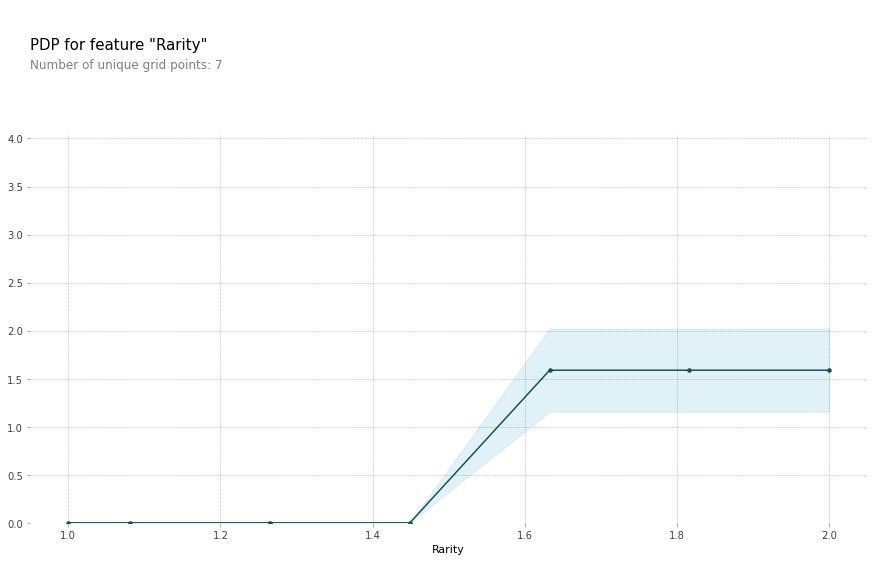

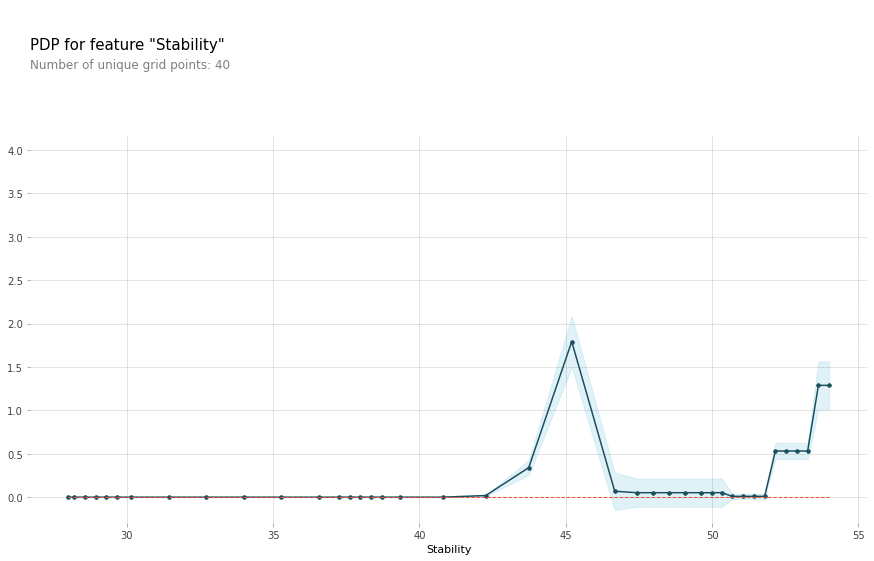

---------------------------------------------------------------------
PDP visualizations for weapon type: Hand Cannon


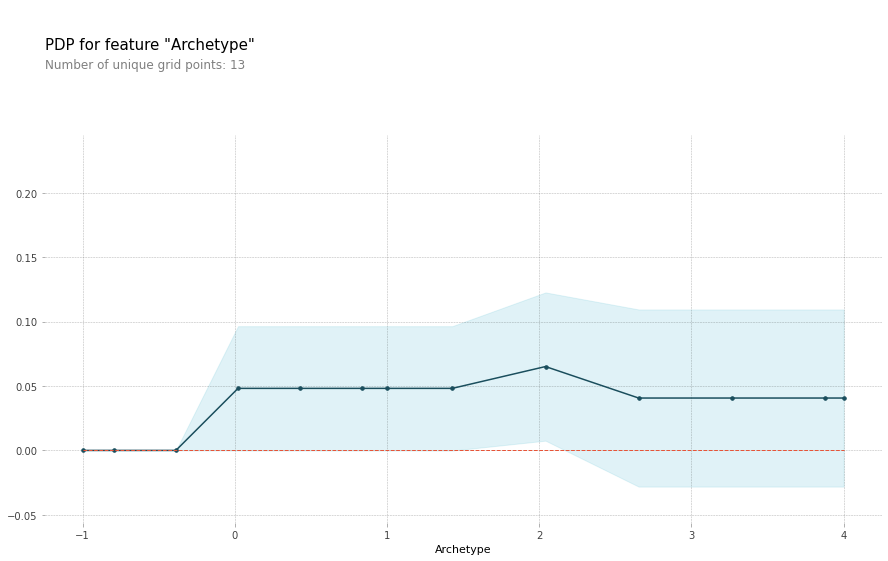

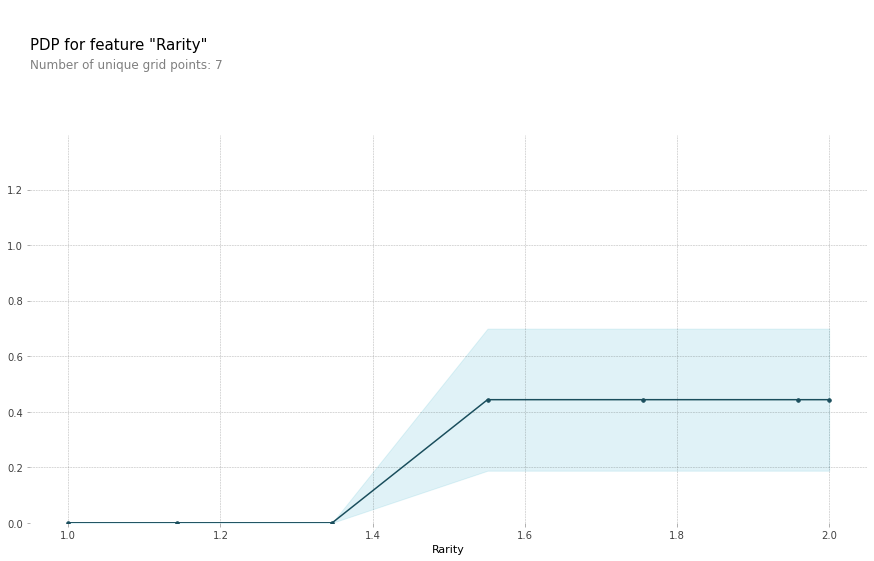

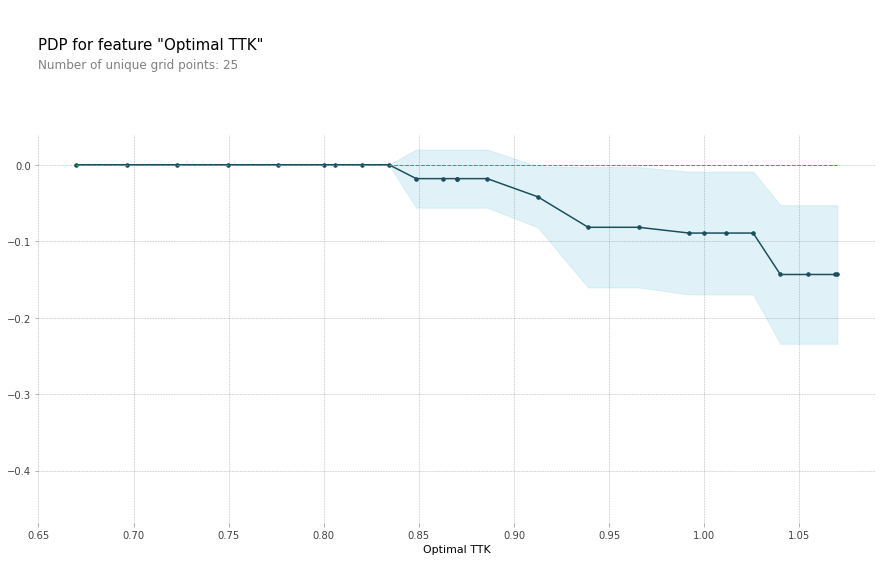

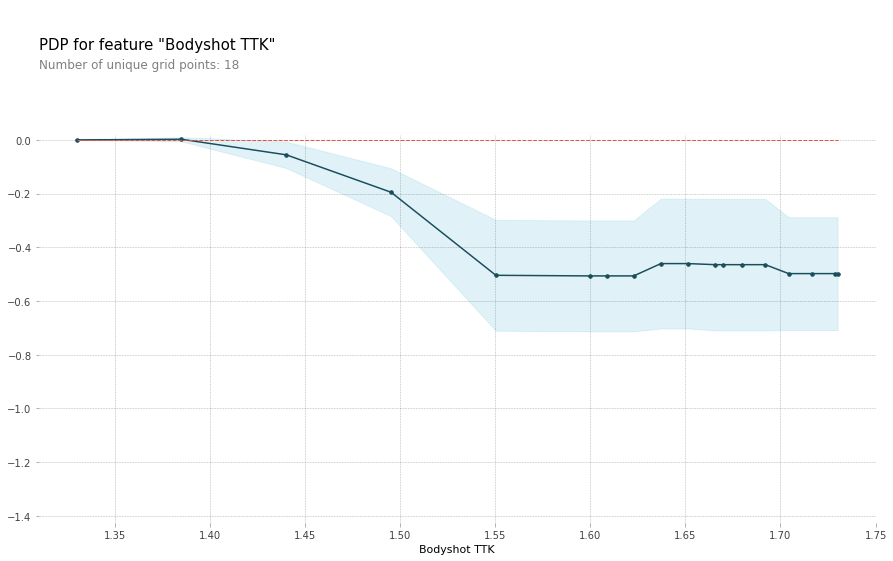

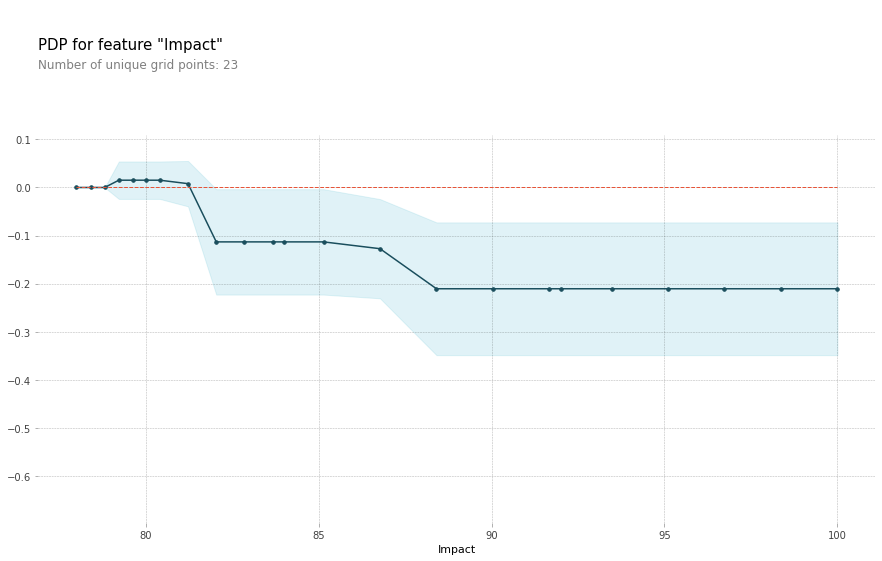

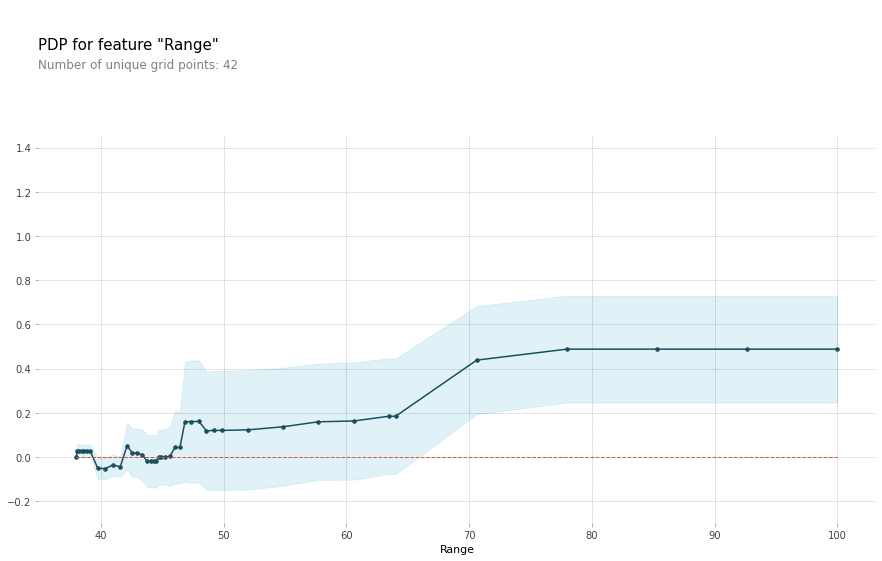

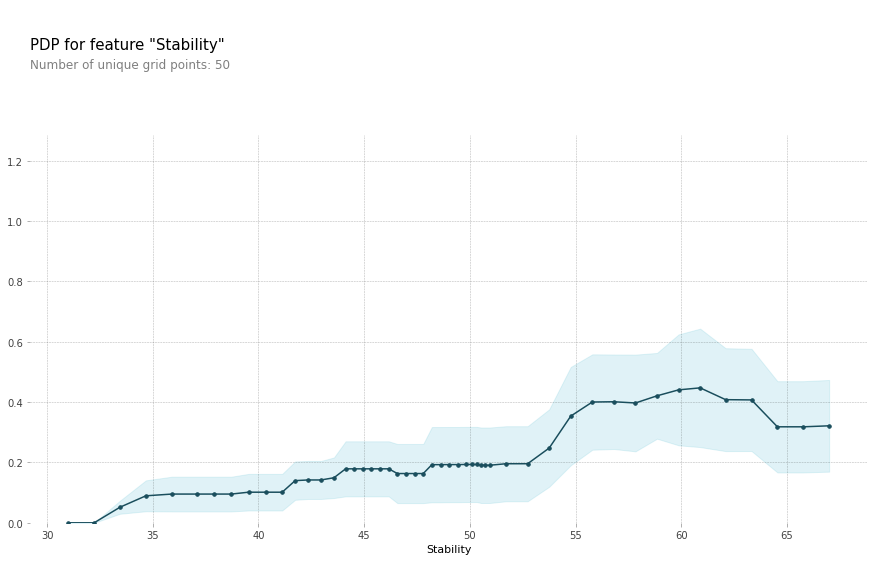

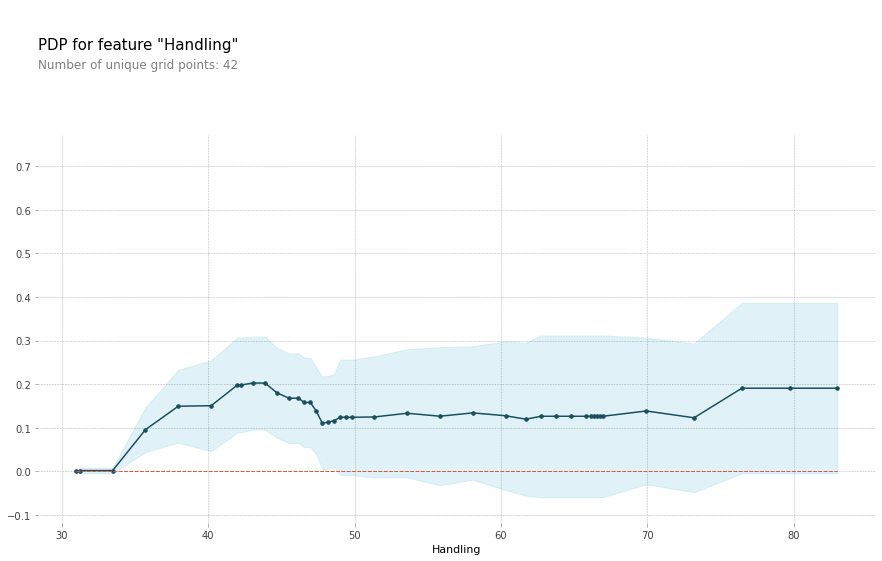

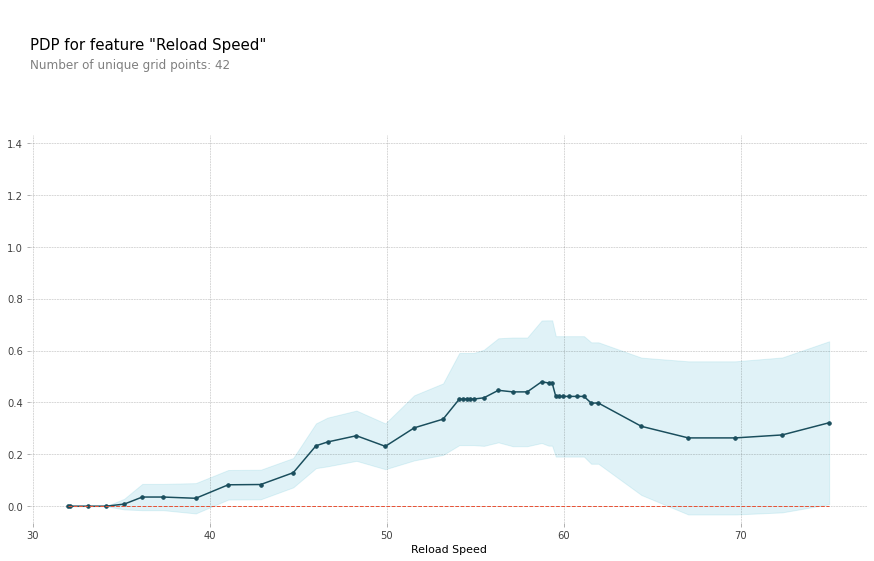

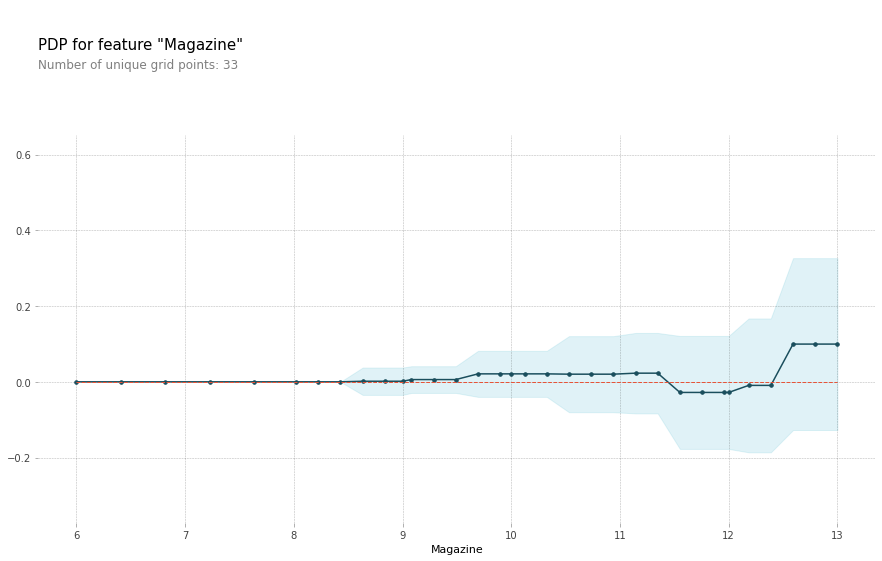

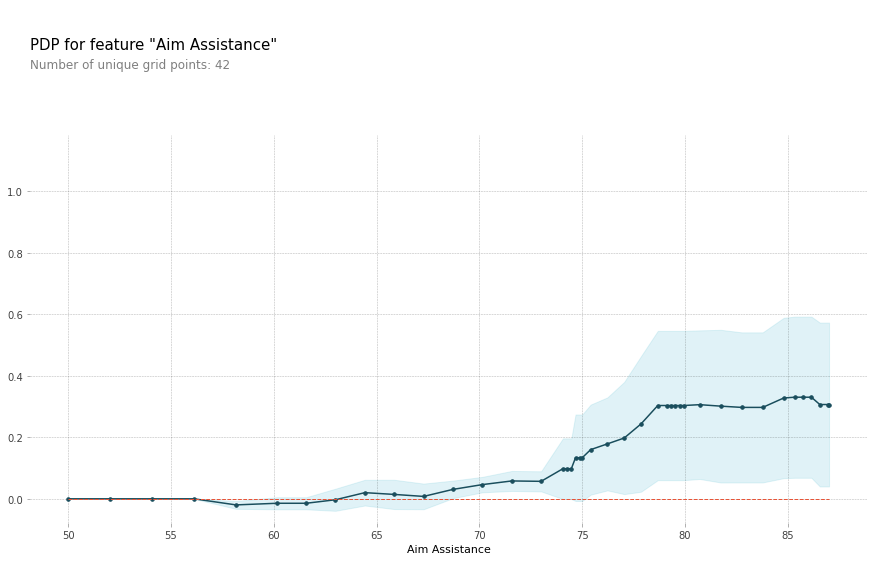

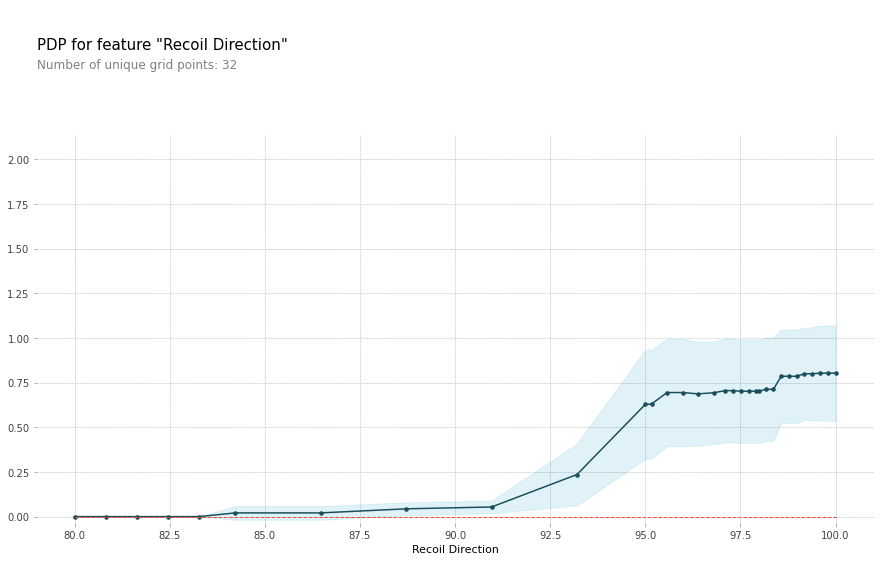

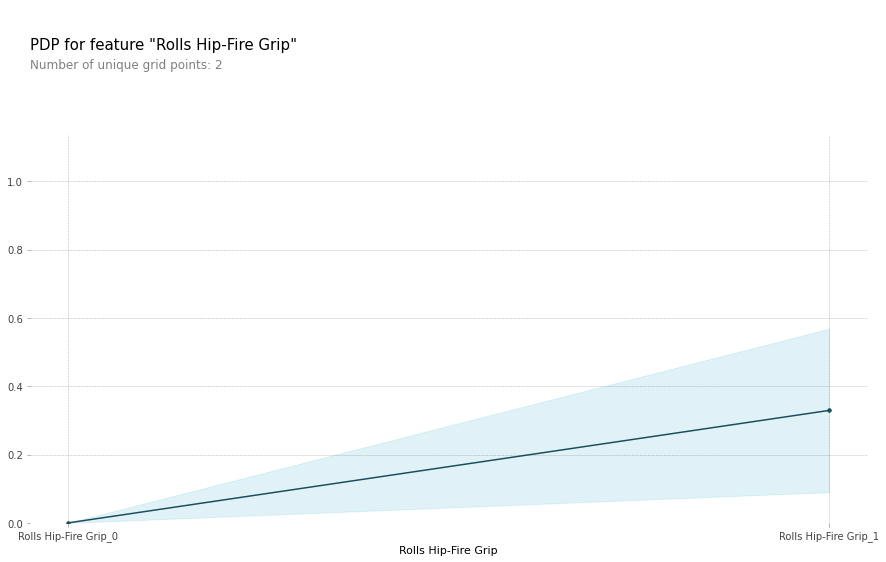

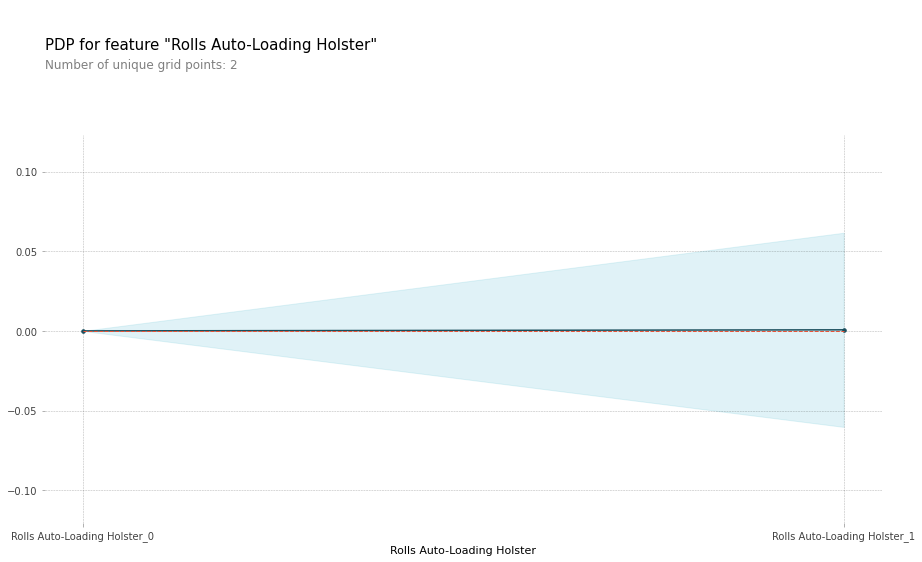

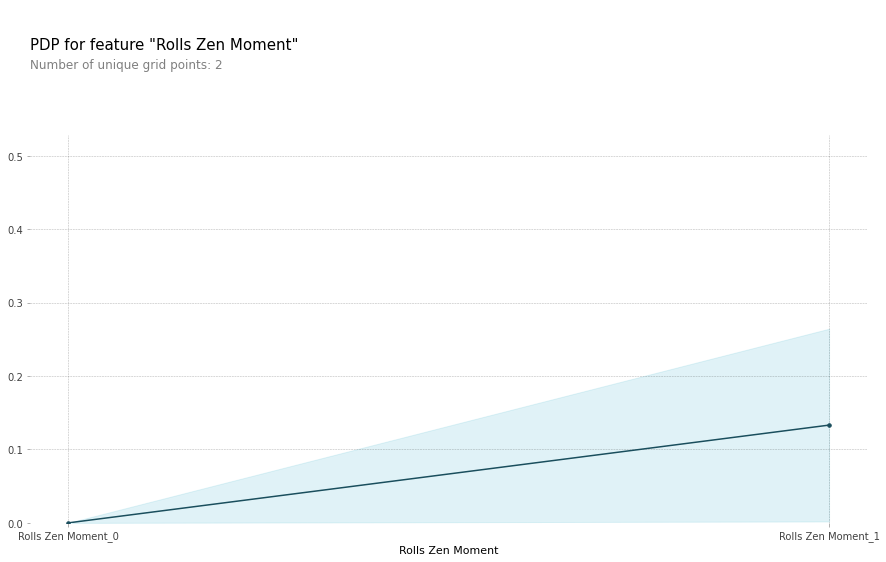

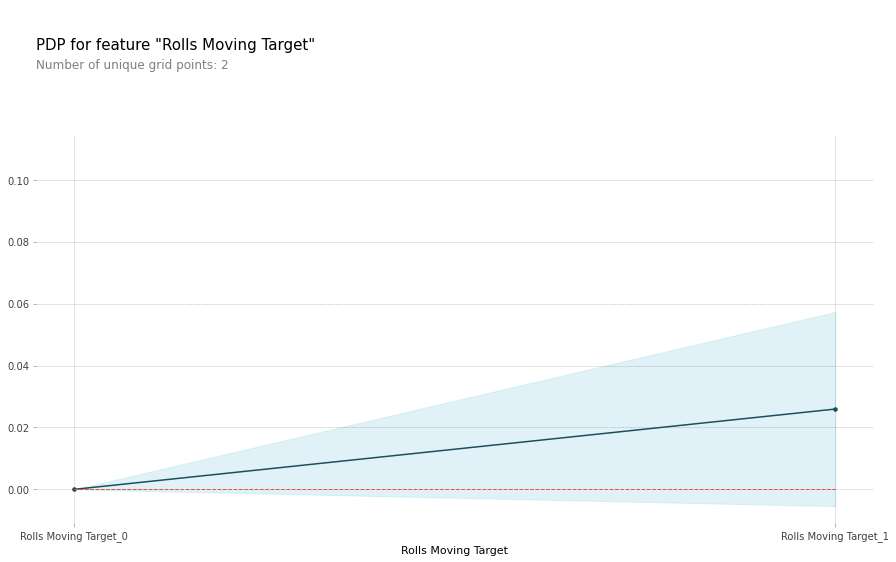

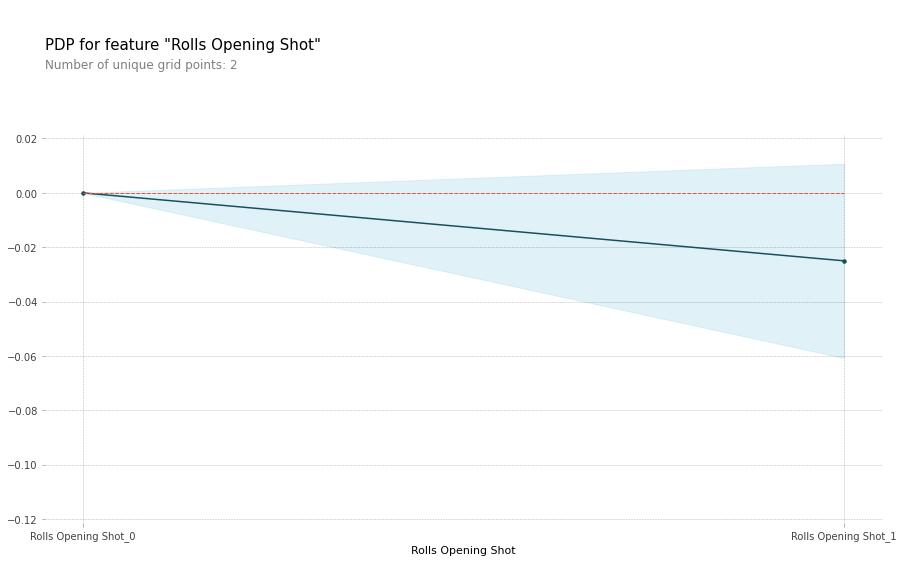

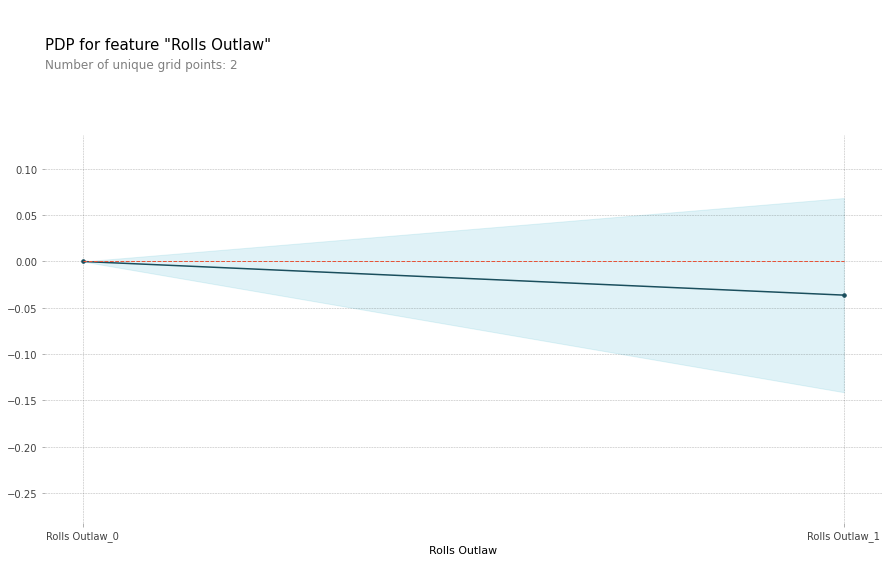

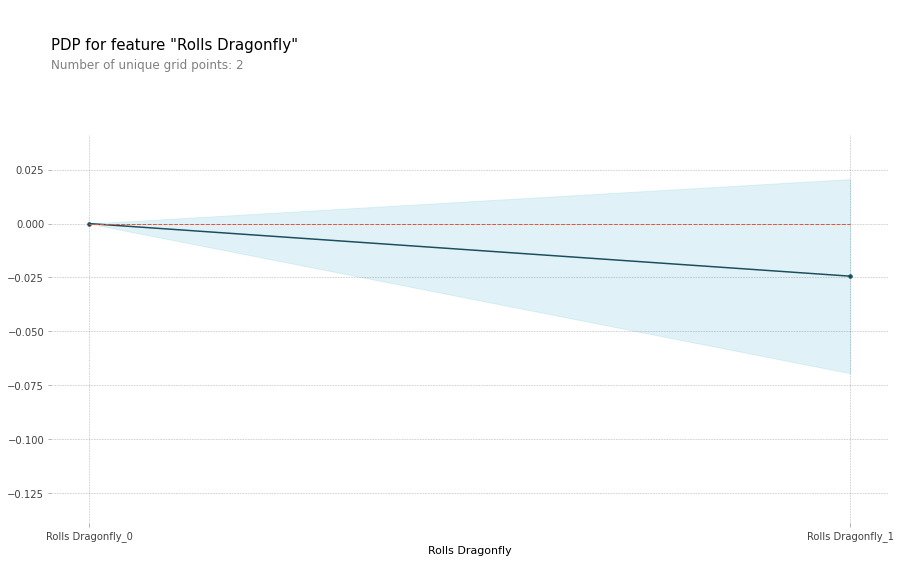

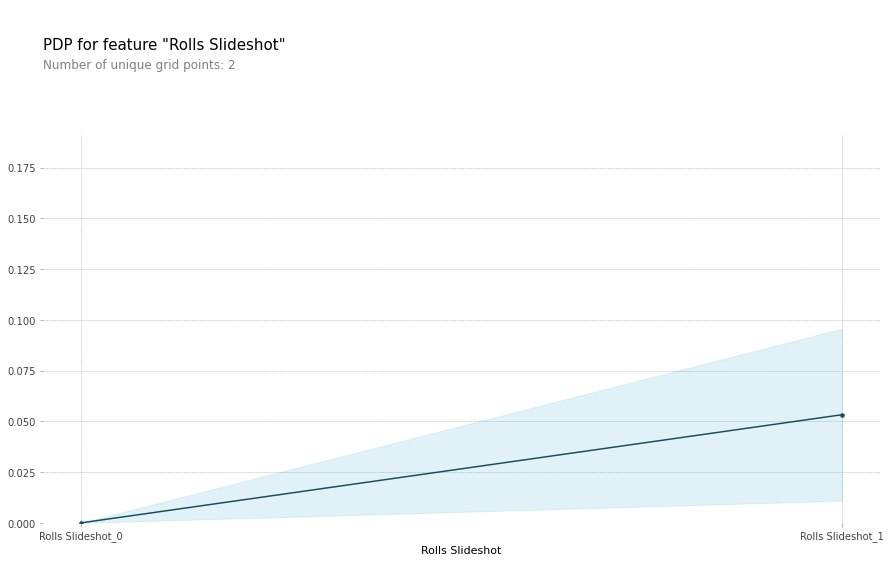

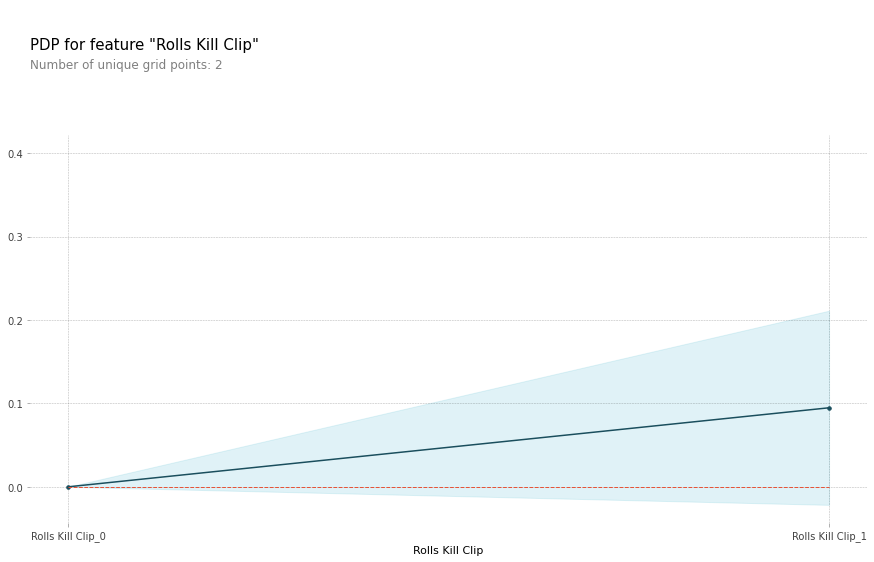

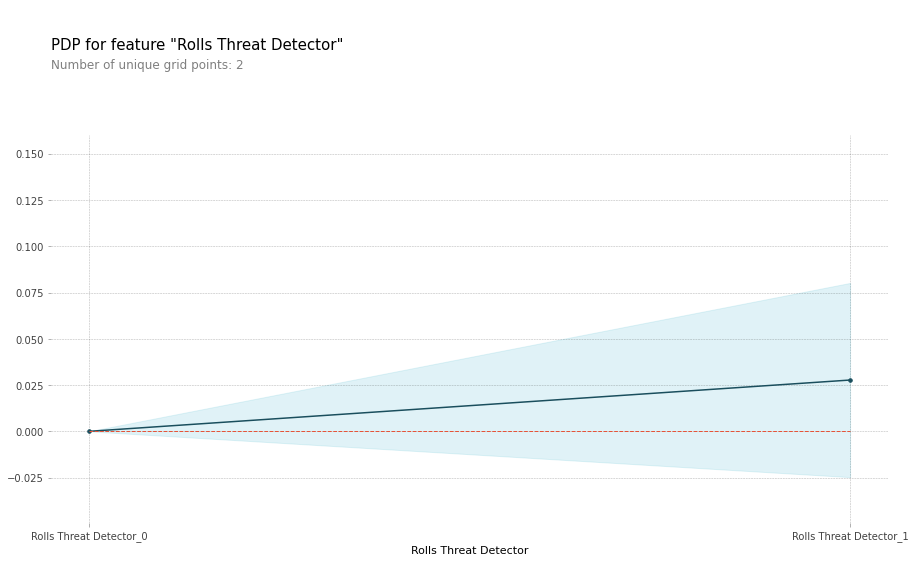

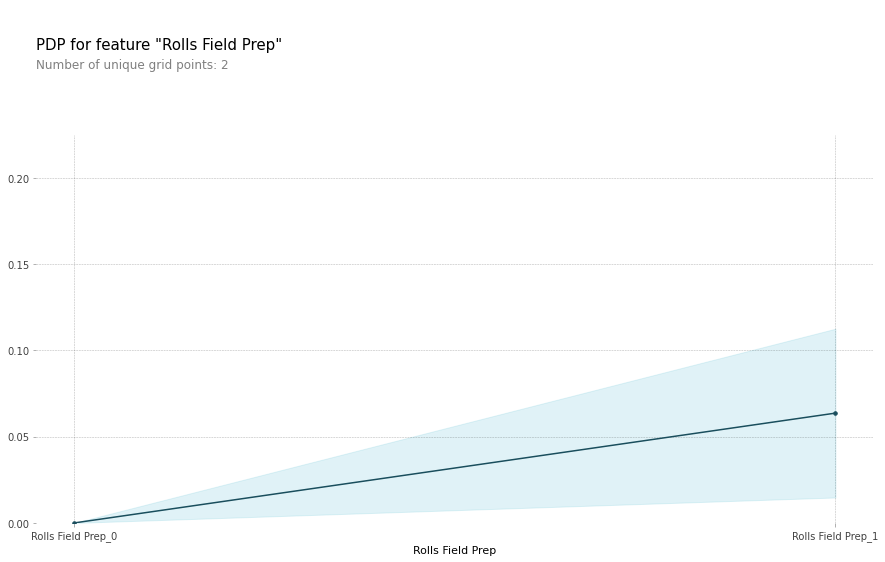

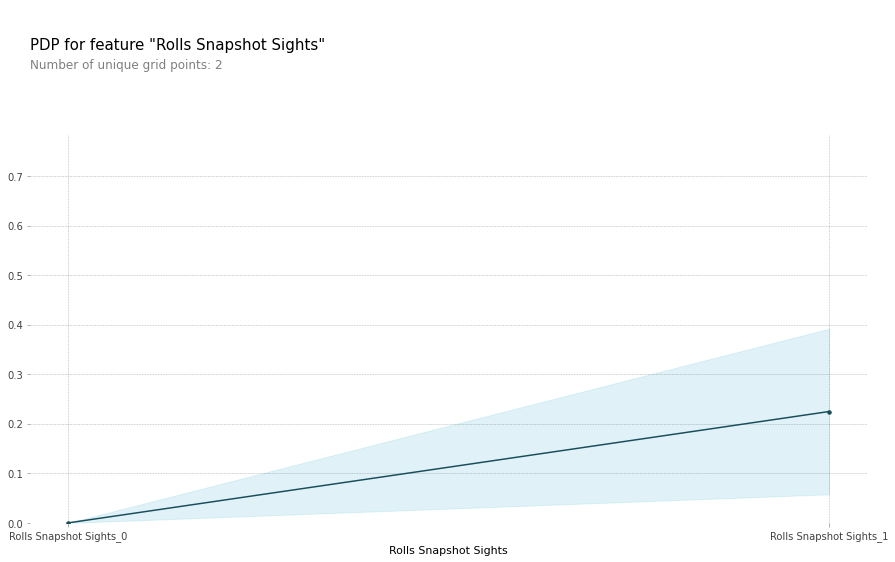

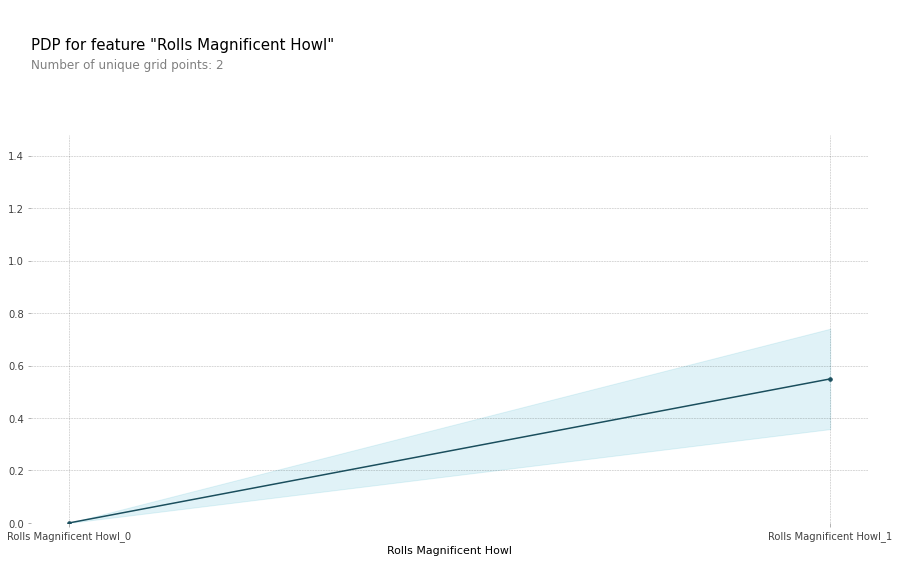

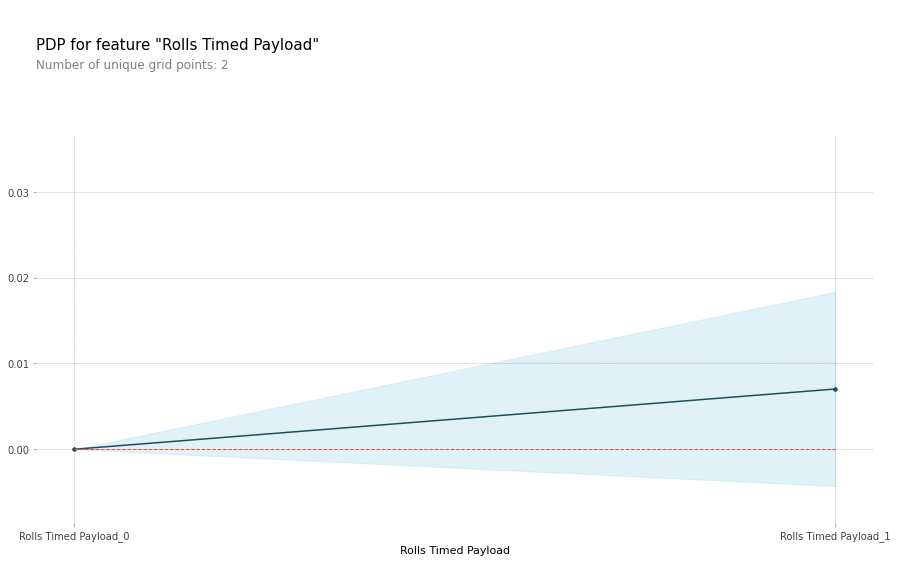

---------------------------------------------------------------------
PDP visualizations for weapon type: Shotgun


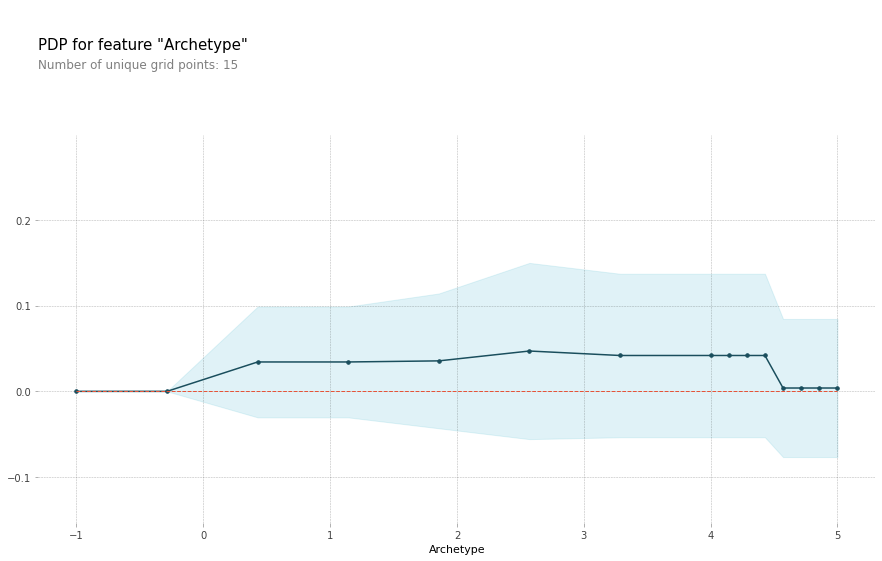

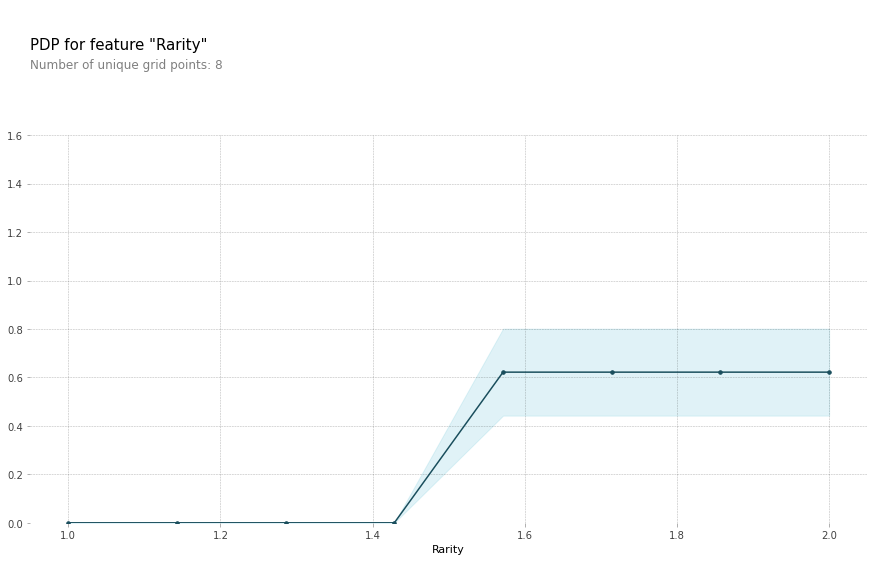

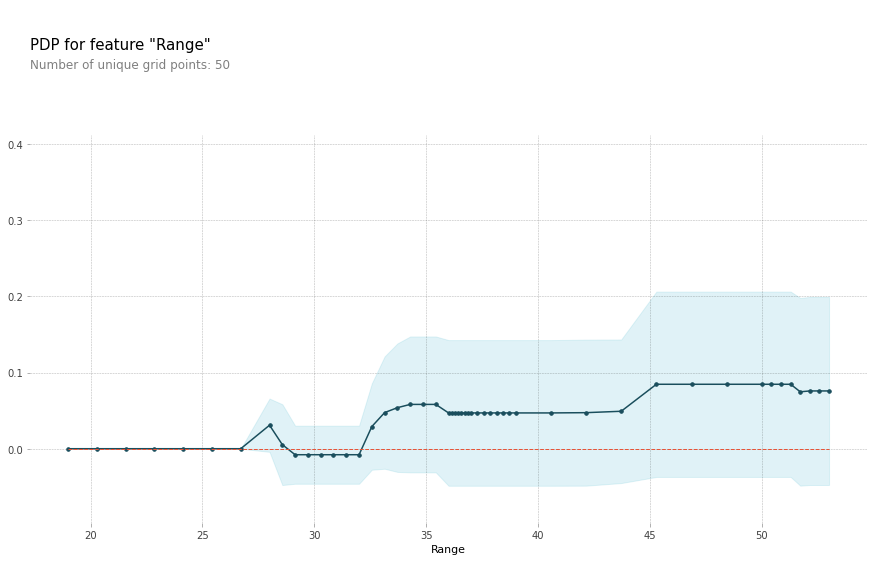

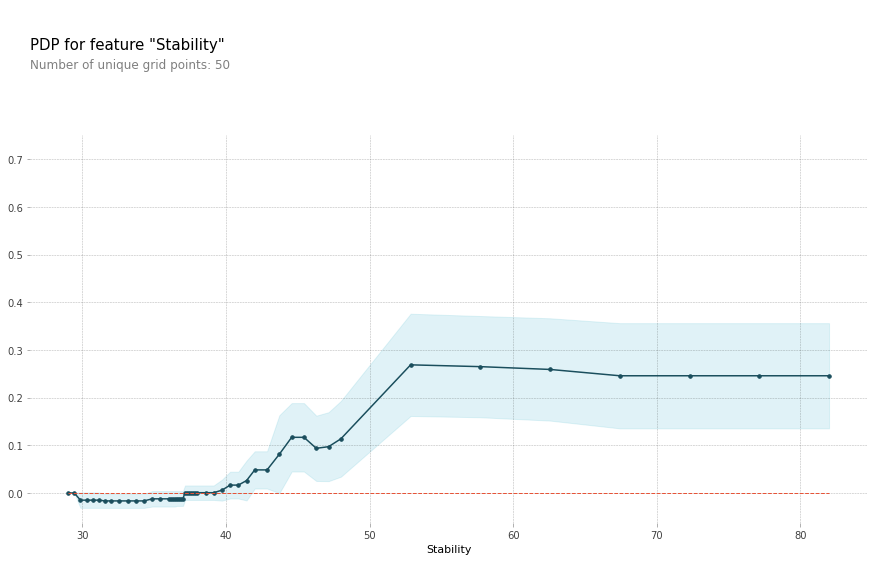

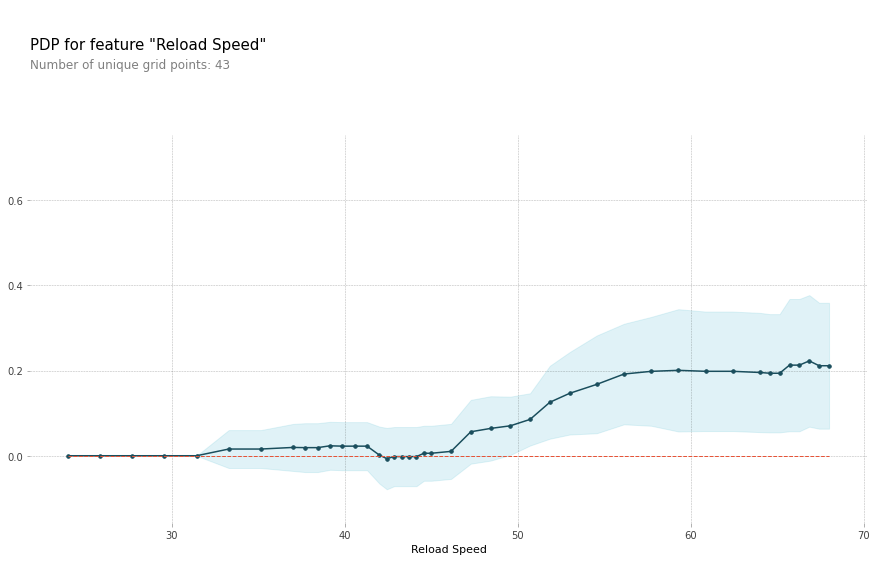

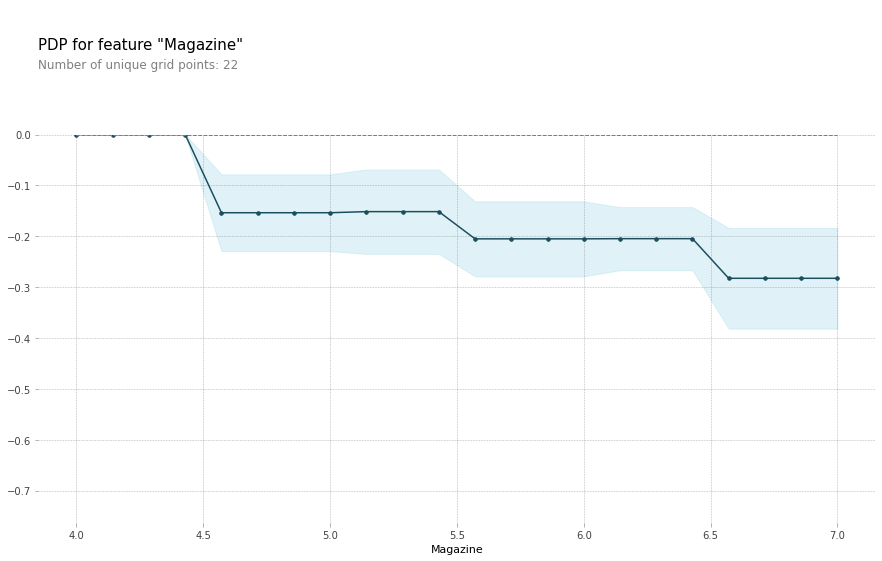

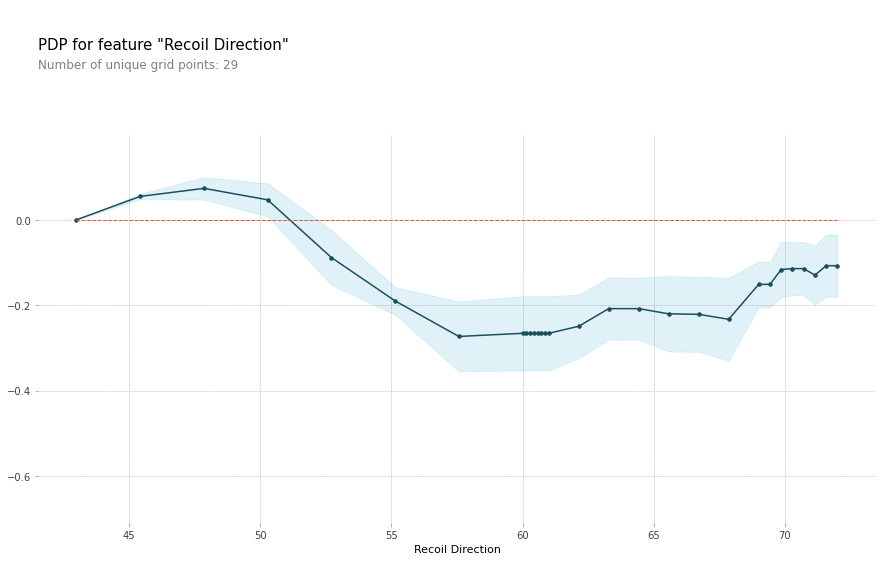

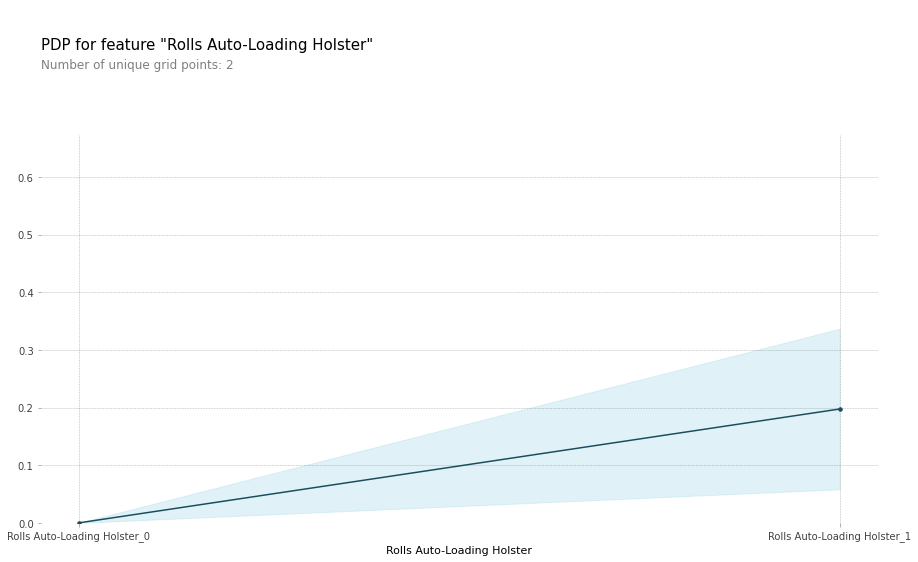

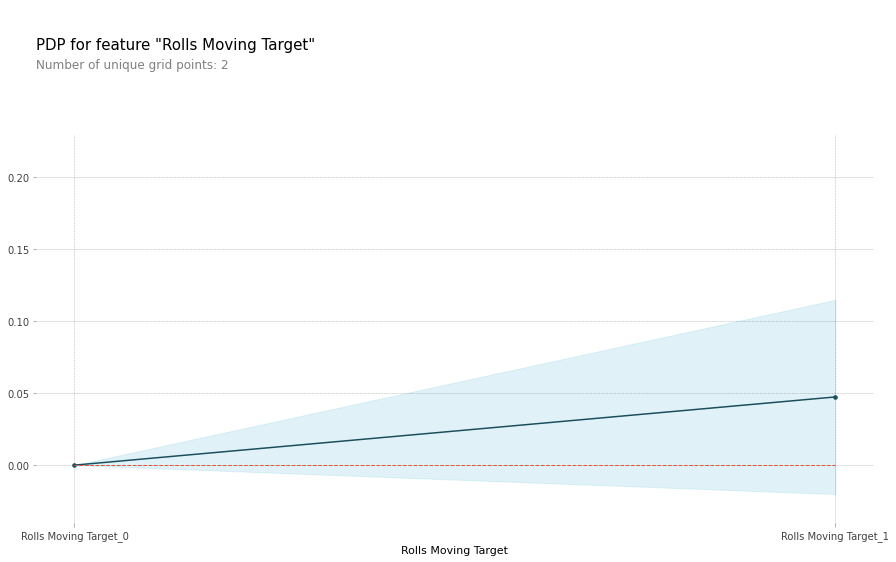

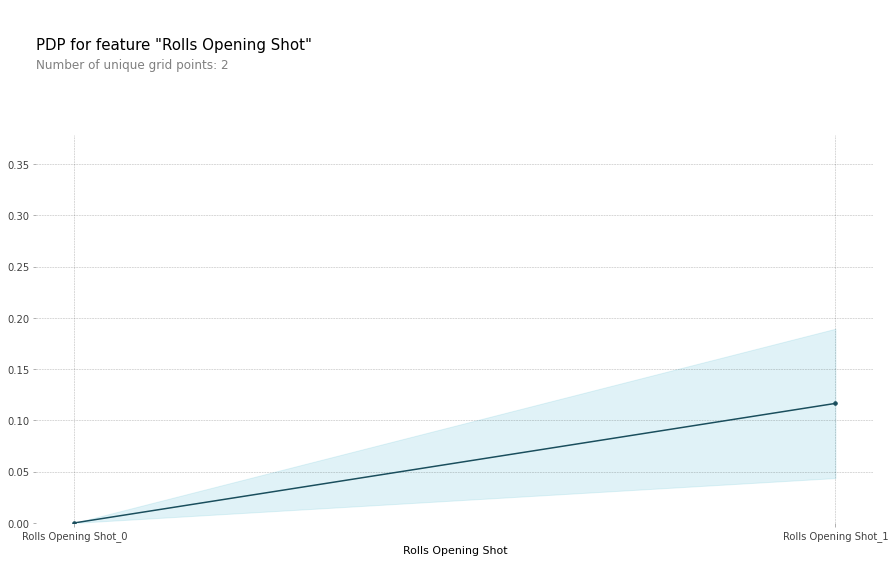

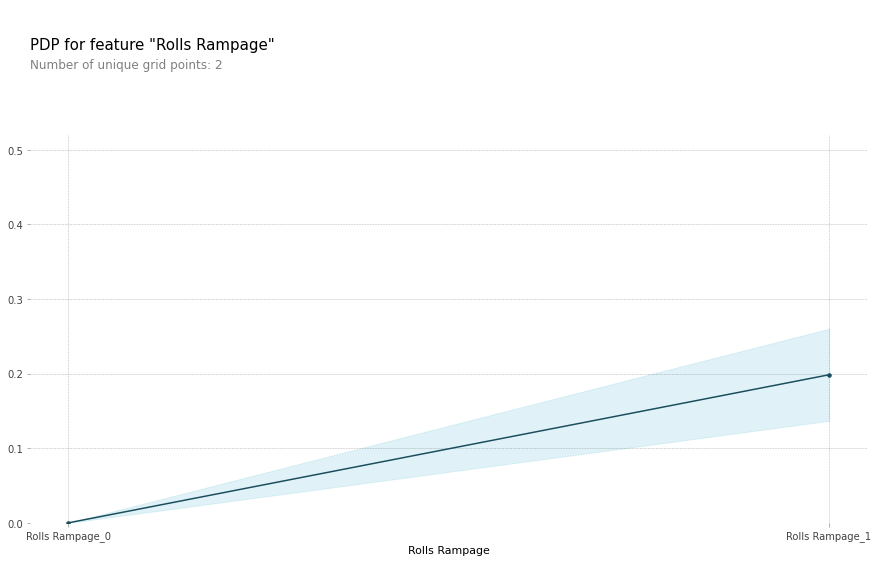

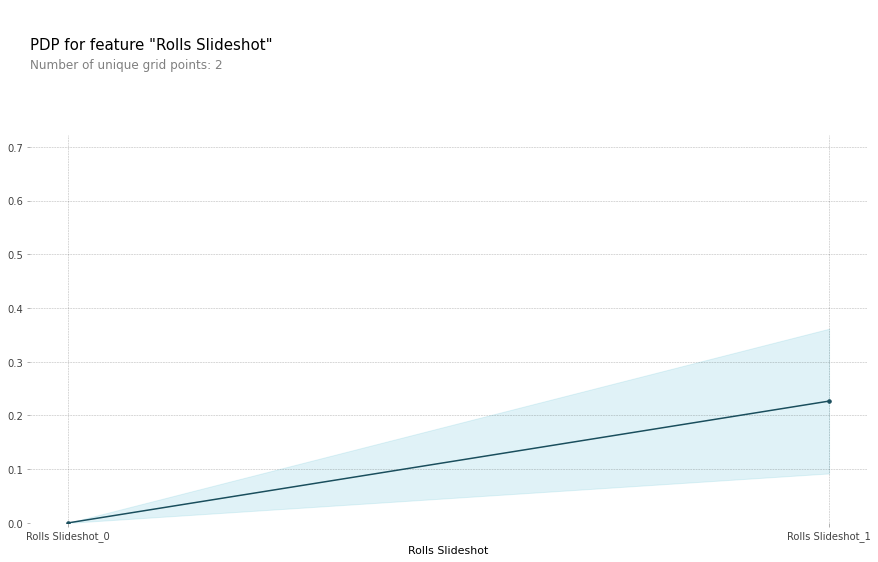

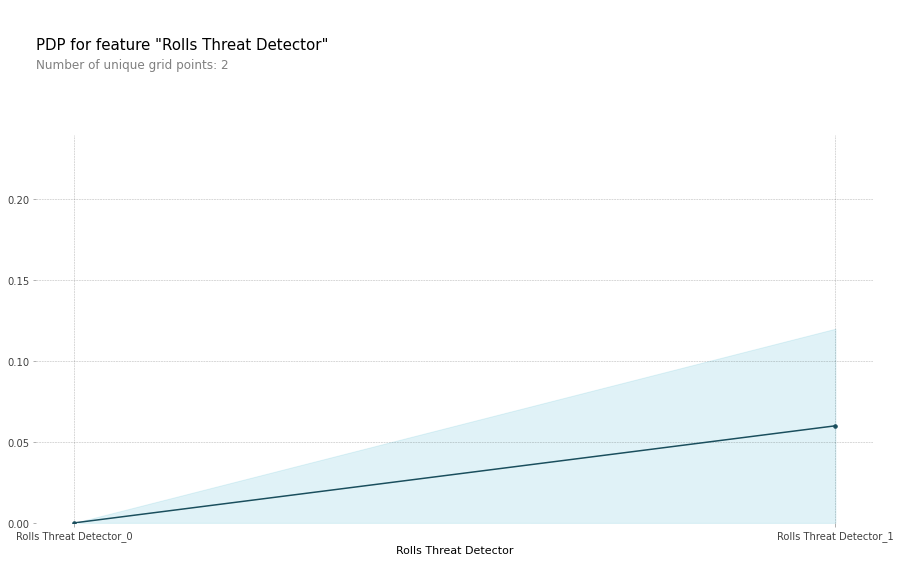

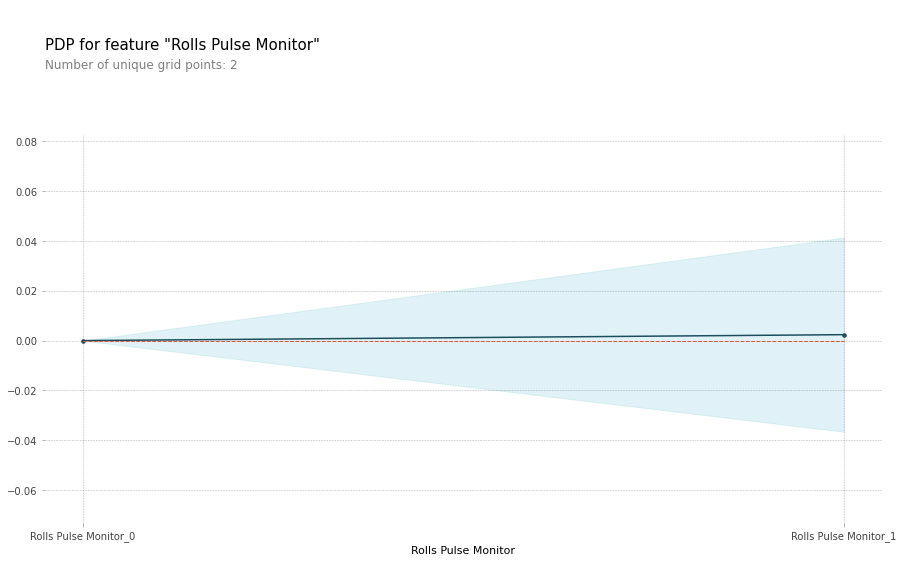

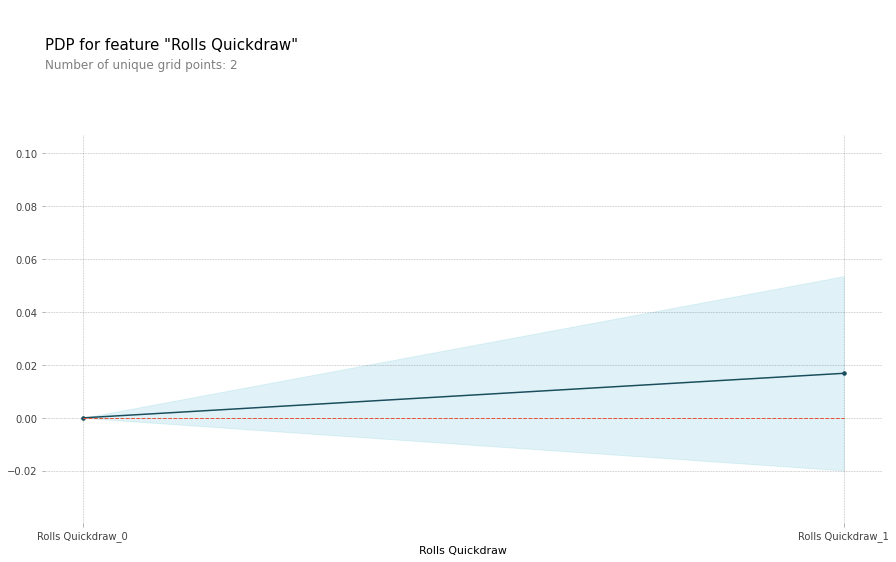

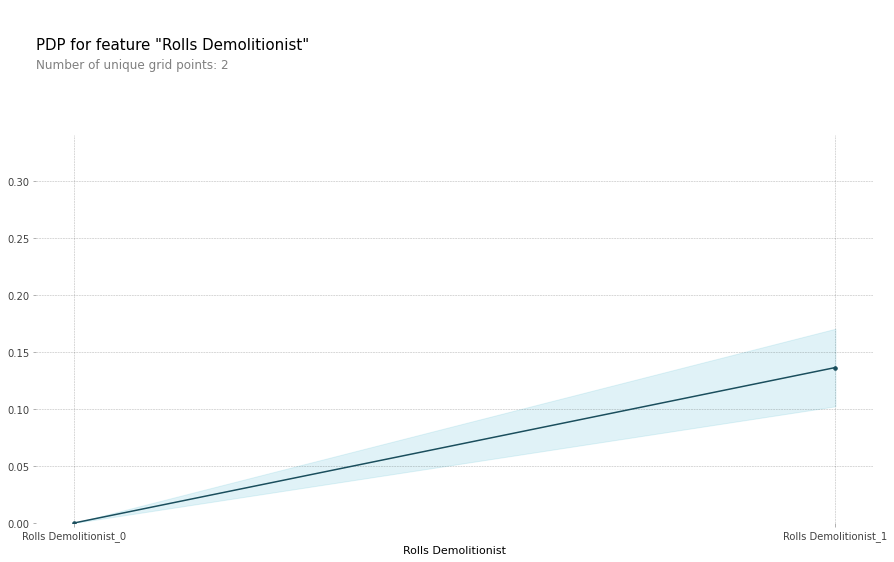

---------------------------------------------------------------------
PDP visualizations for weapon type: Auto Rifle


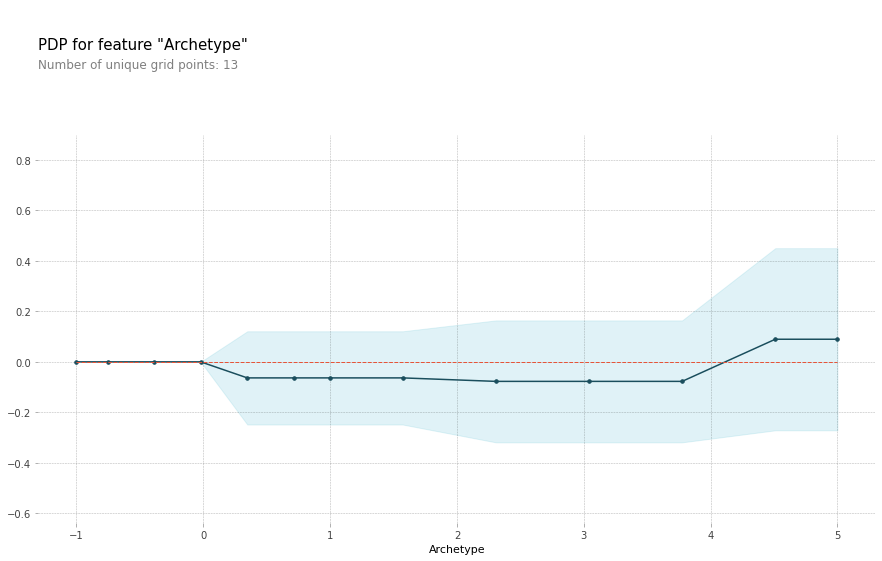

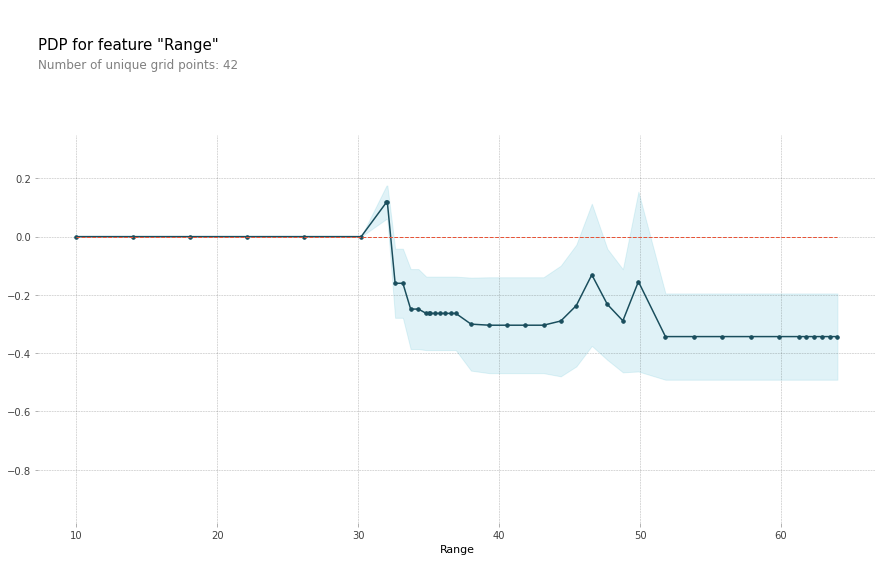

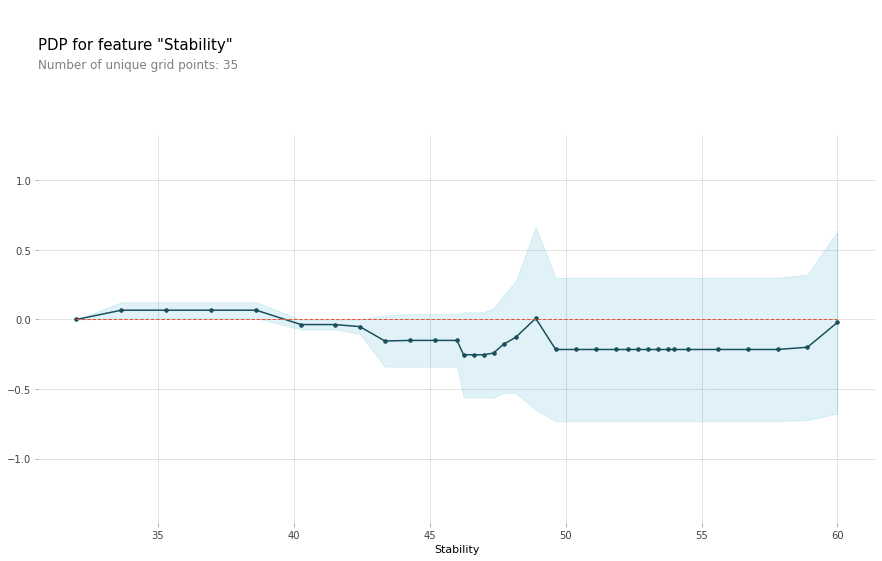

---------------------------------------------------------------------
PDP visualizations for weapon type: Submachine Gun


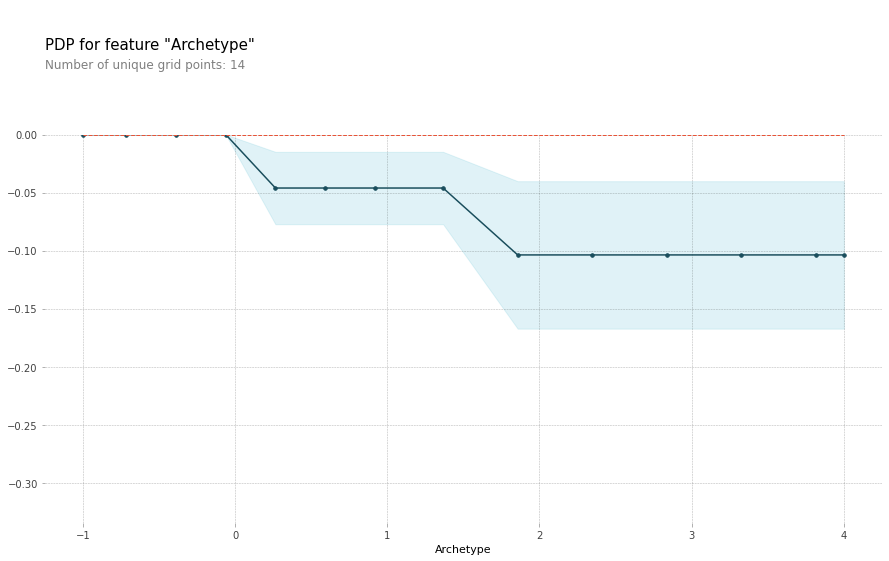

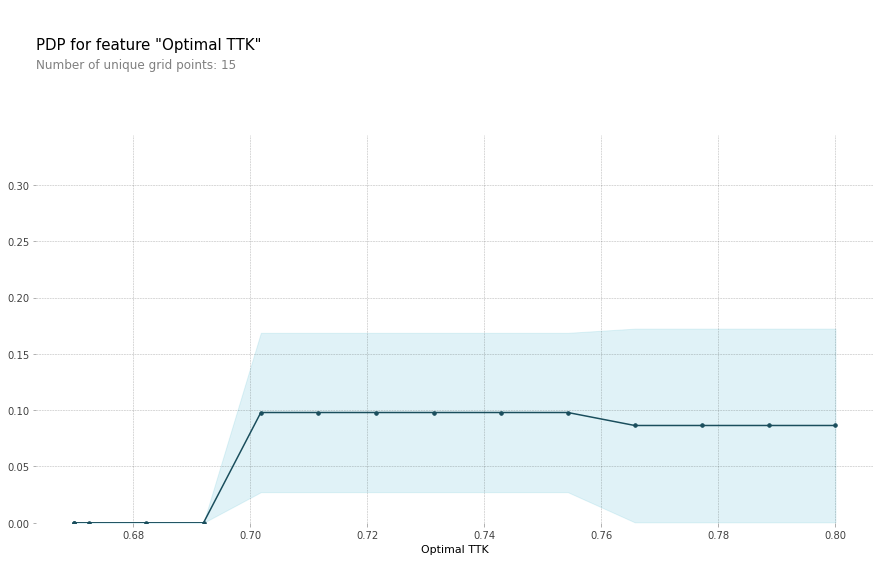

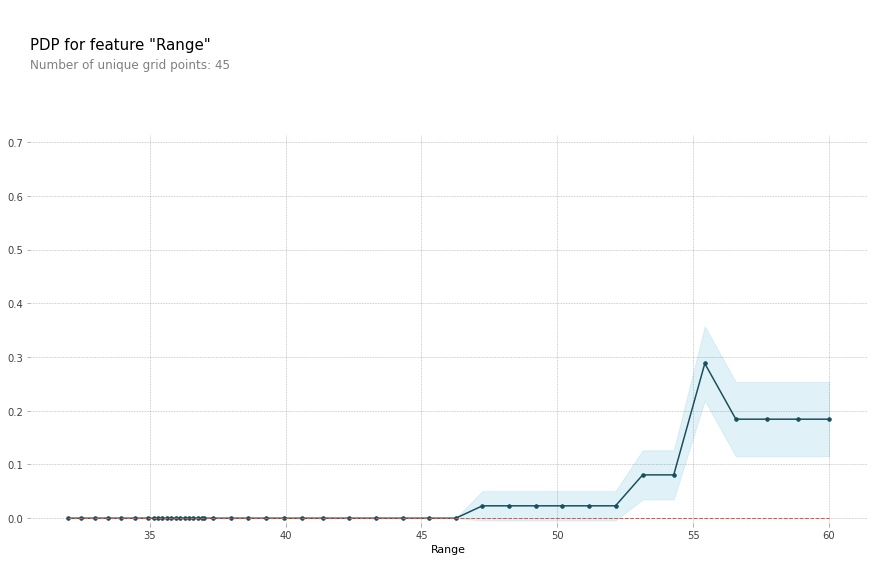

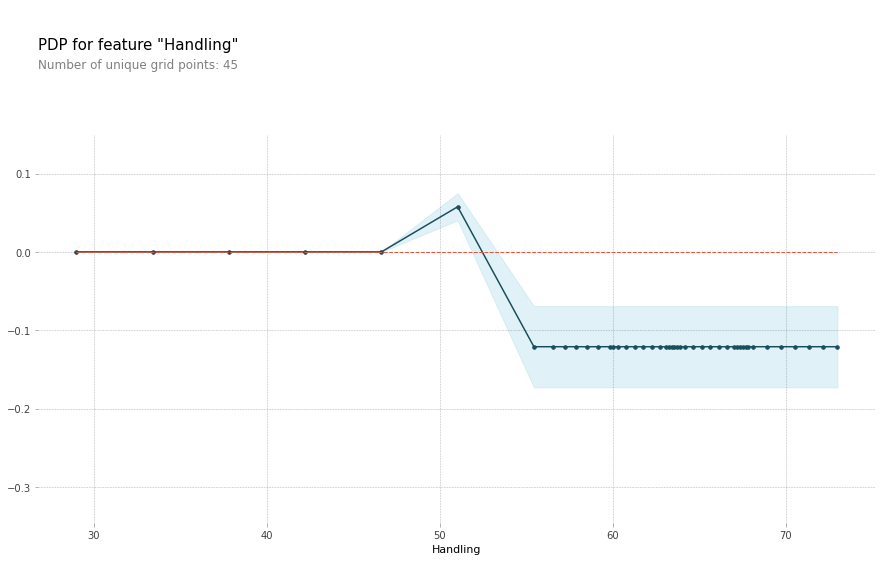

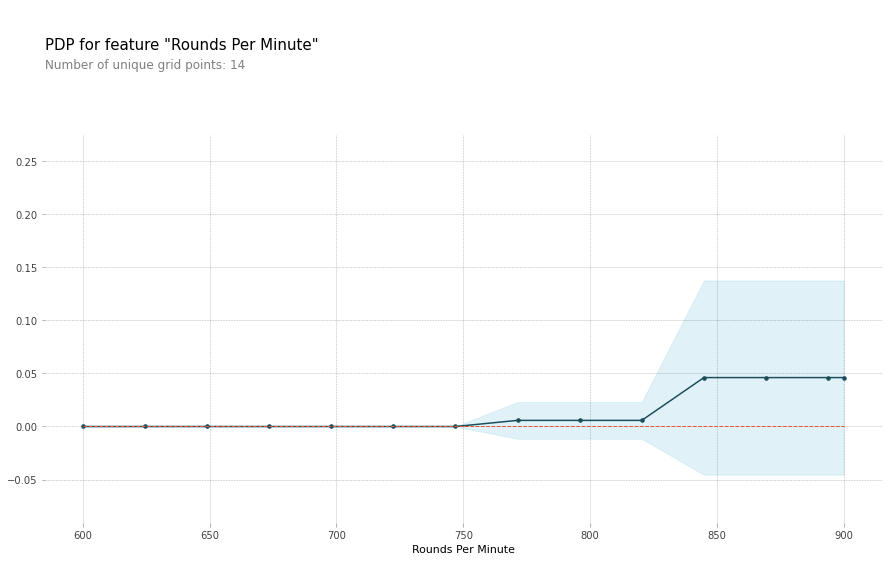

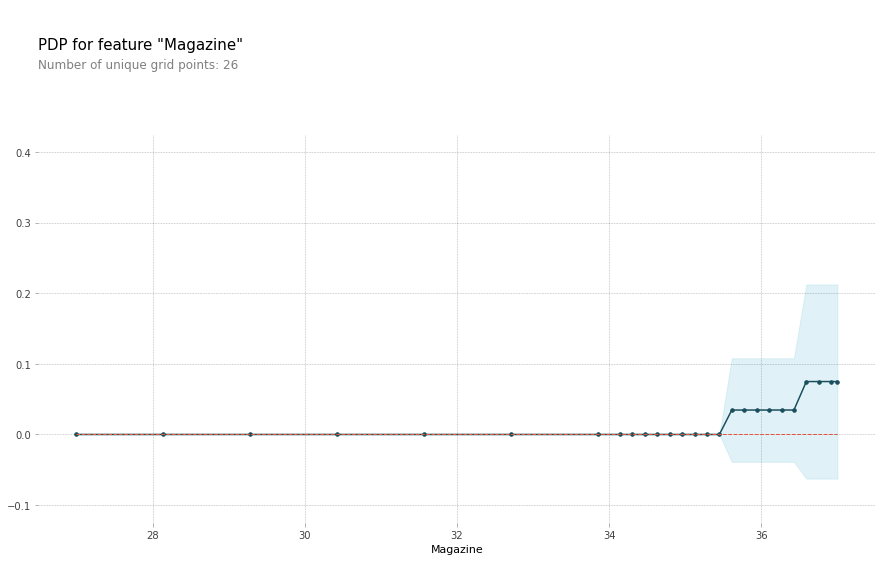

---------------------------------------------------------------------
PDP visualizations for weapon type: Pulse Rifle


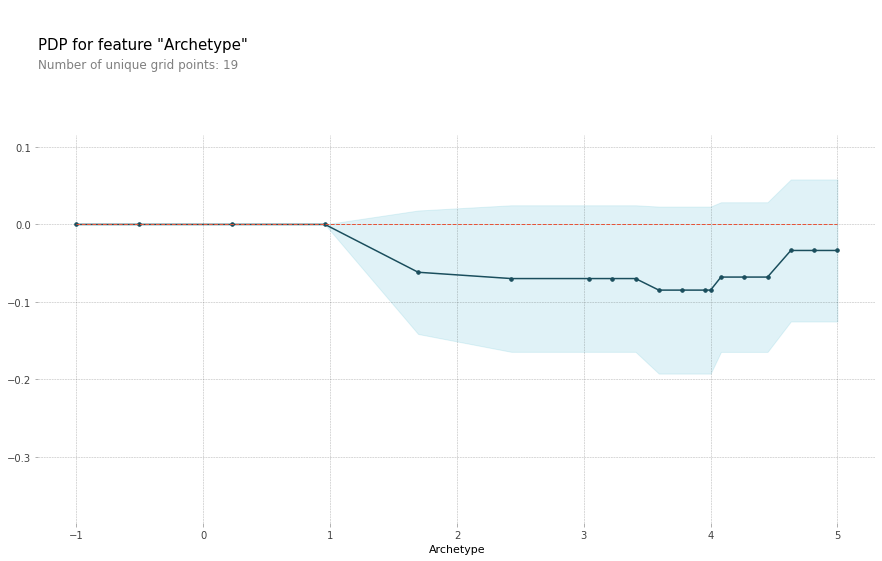

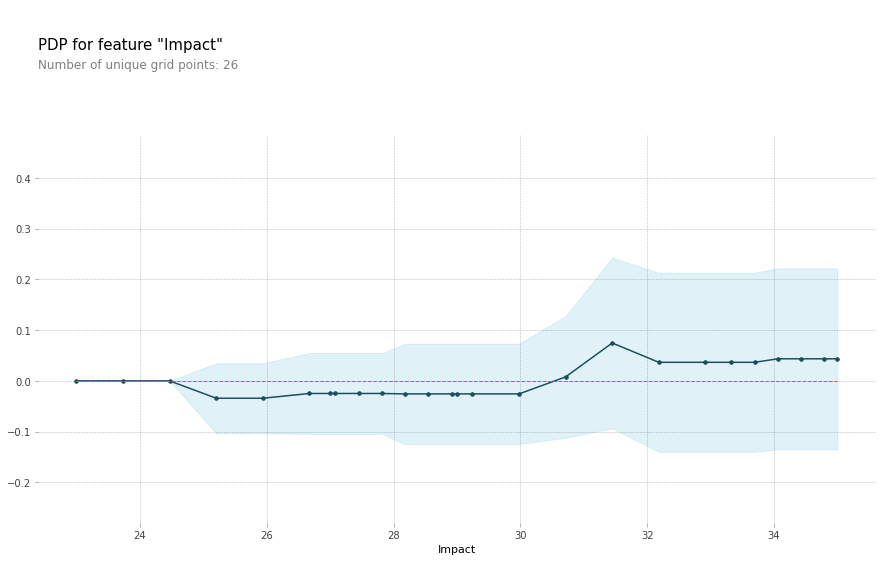

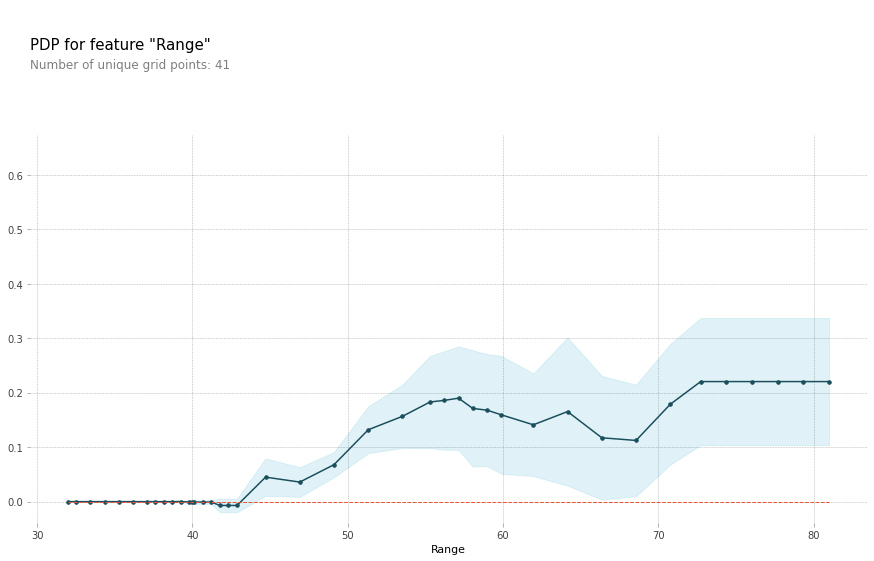

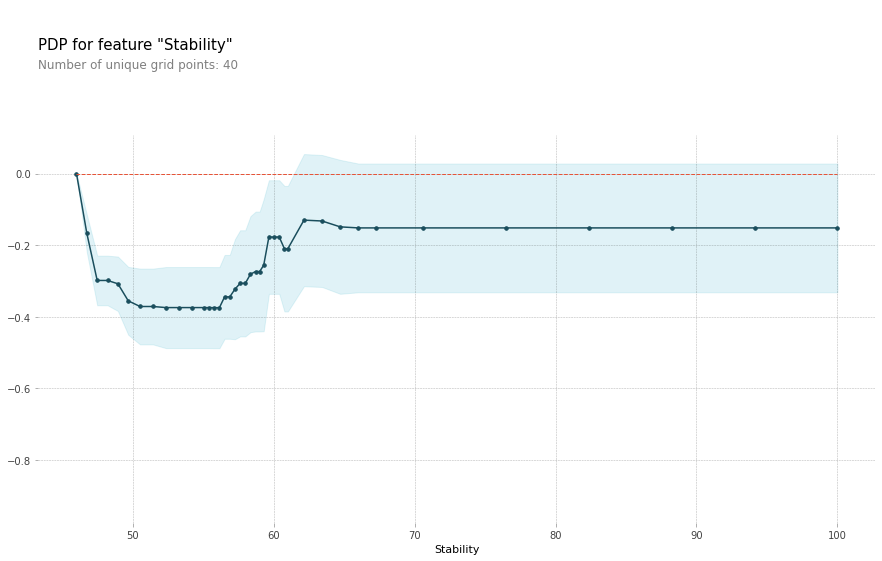

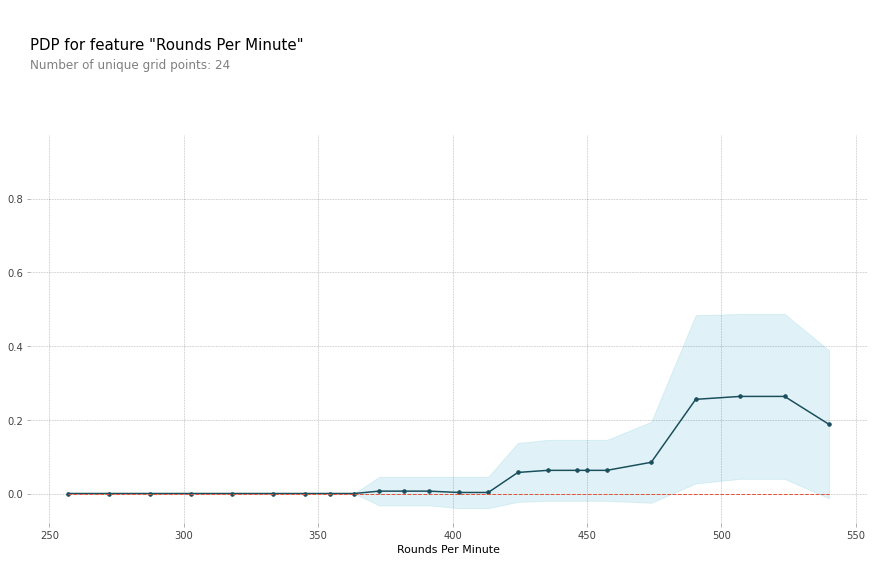

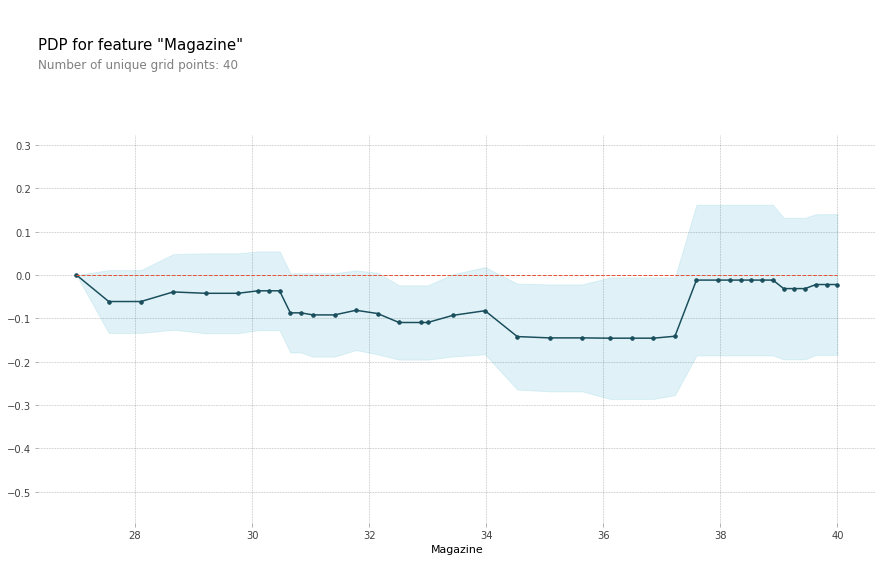

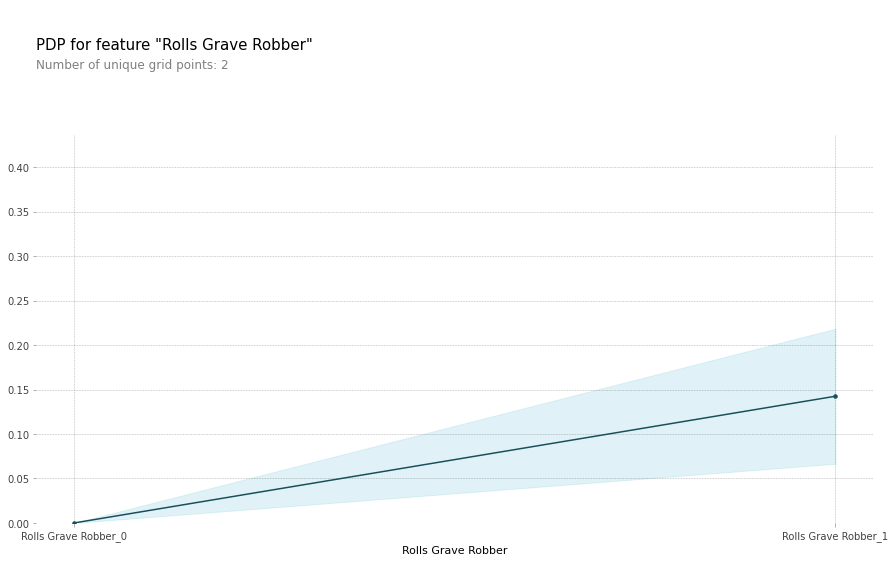

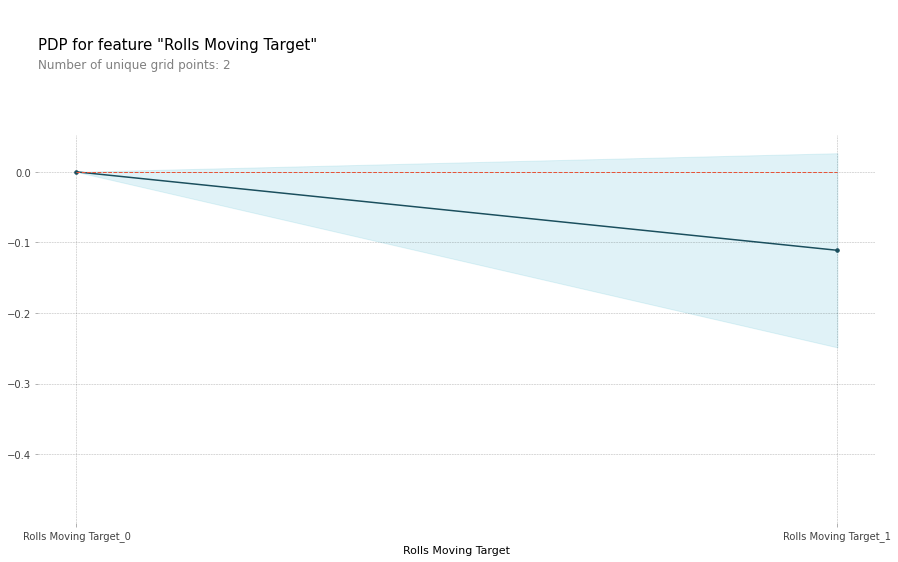

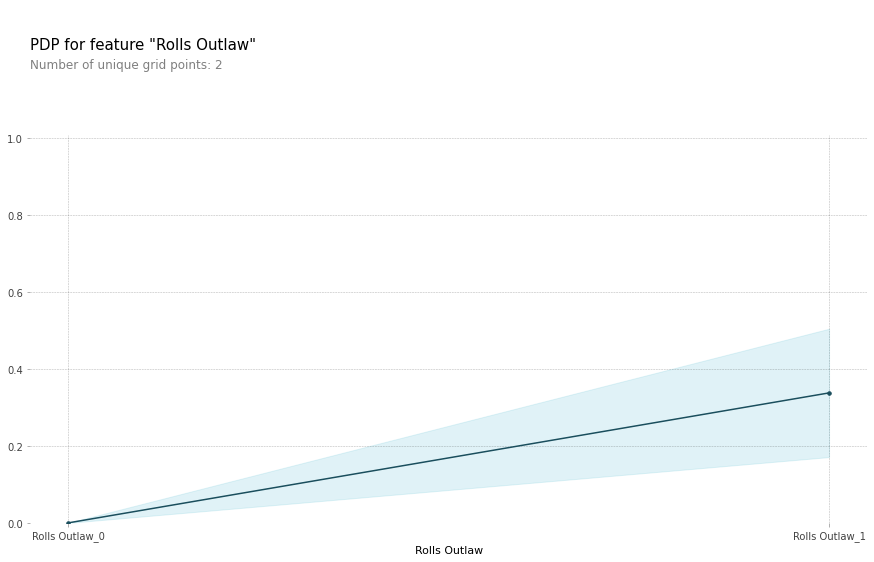

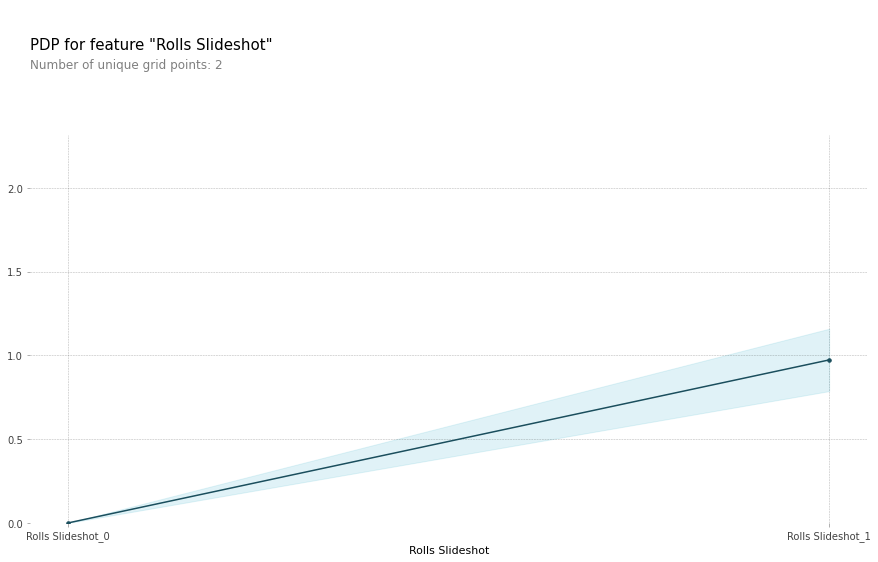

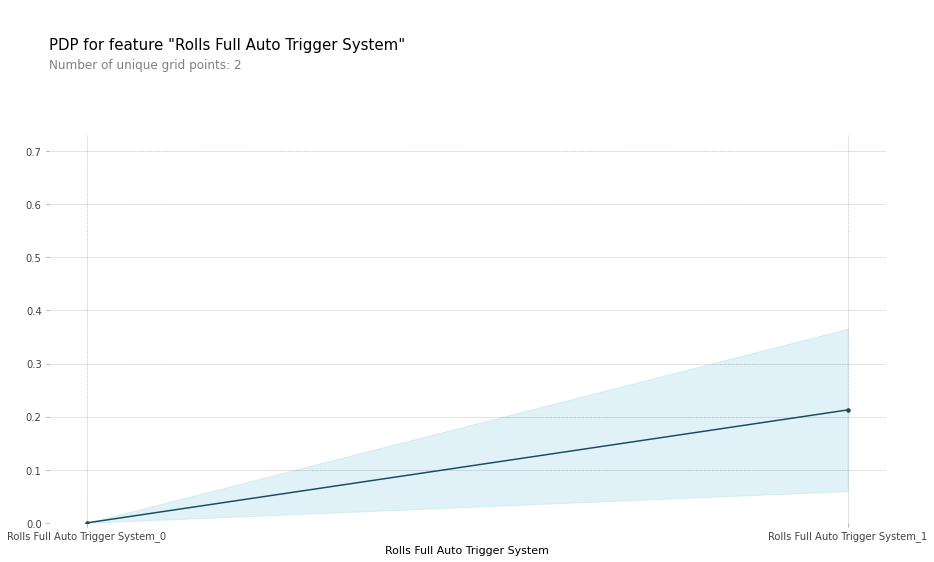

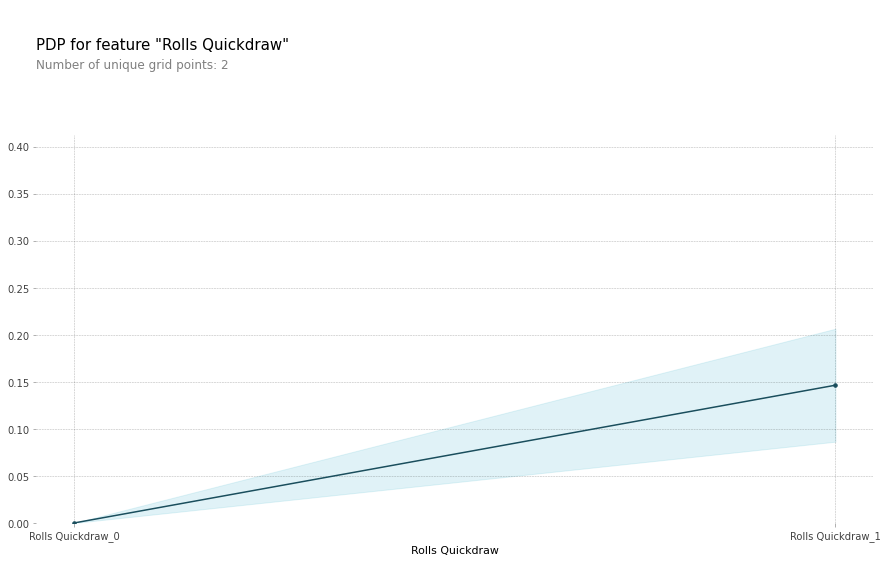

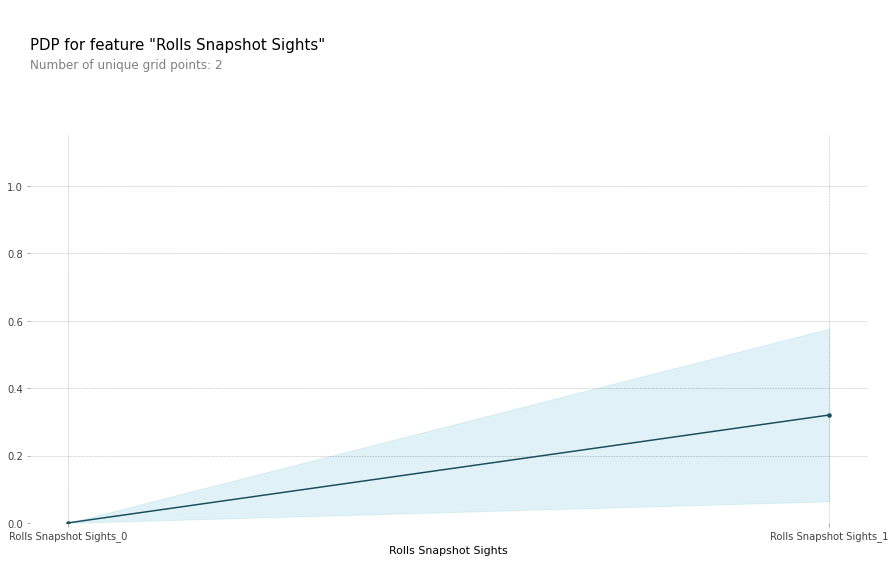

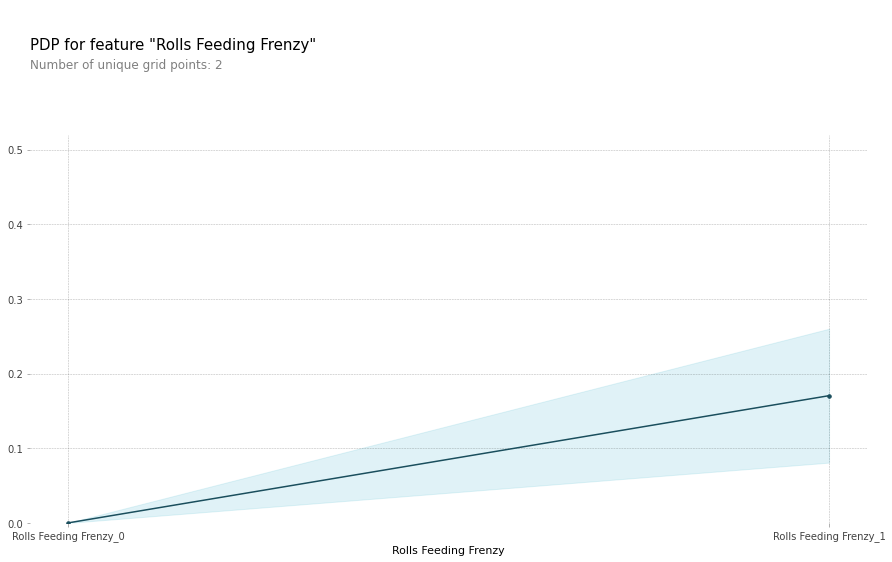

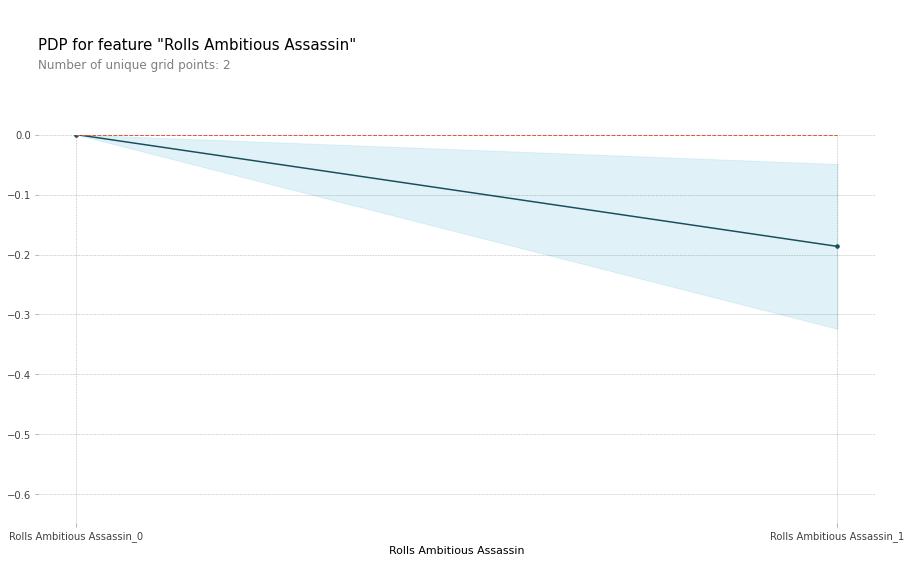

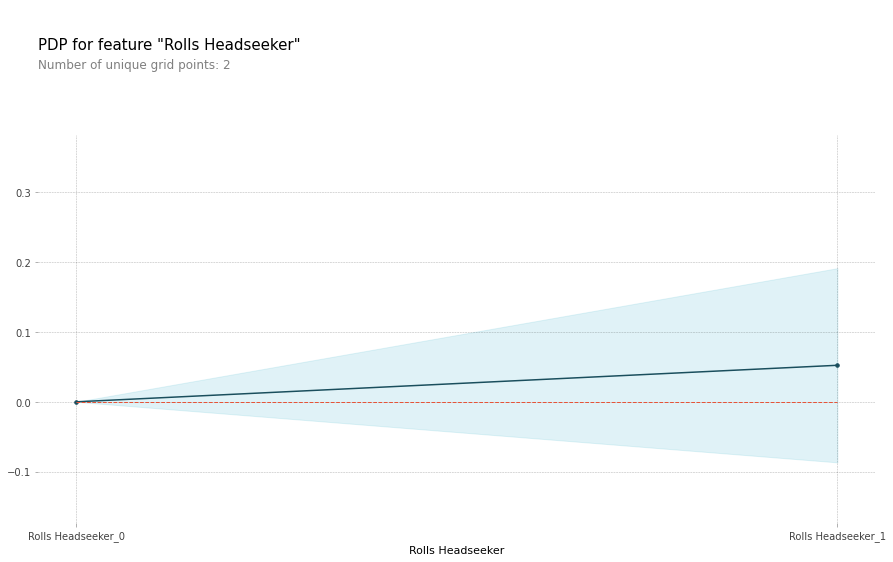

---------------------------------------------------------------------
PDP visualizations for weapon type: Grenade Launcher


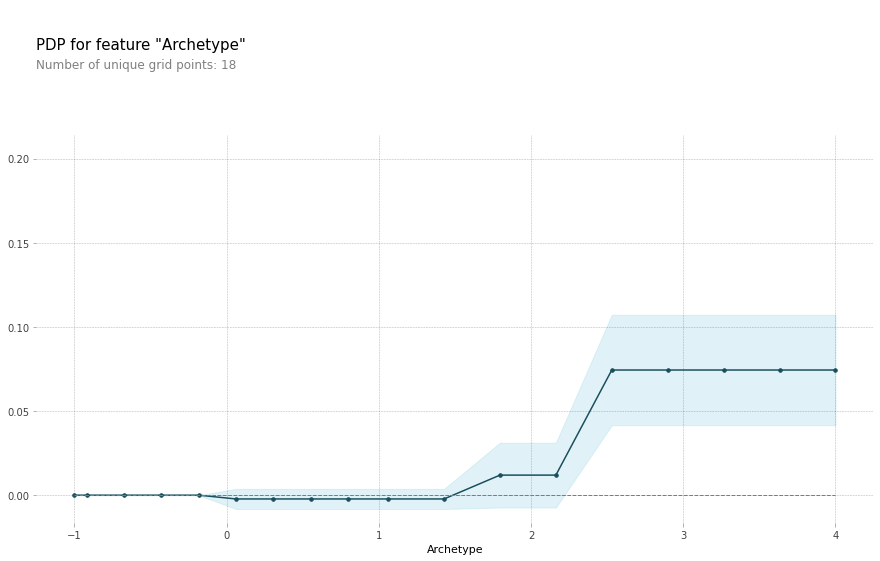

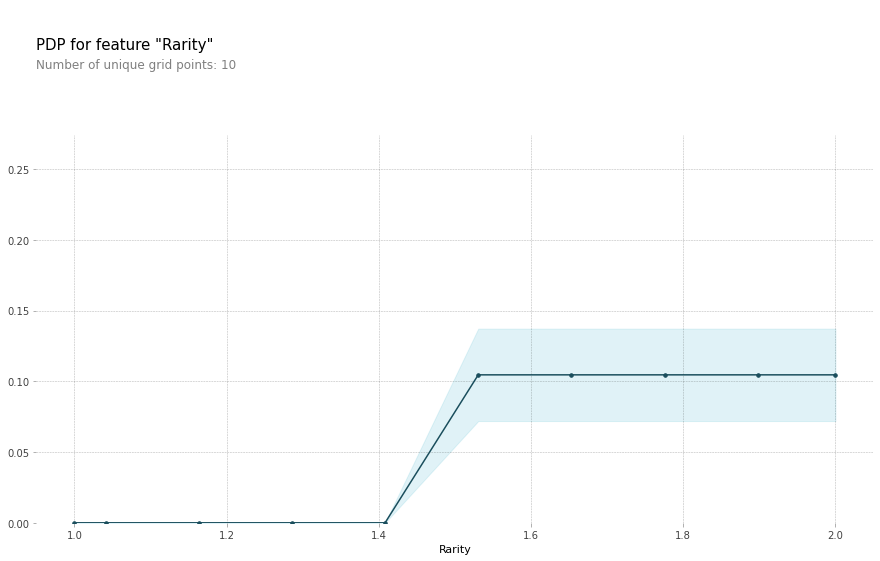

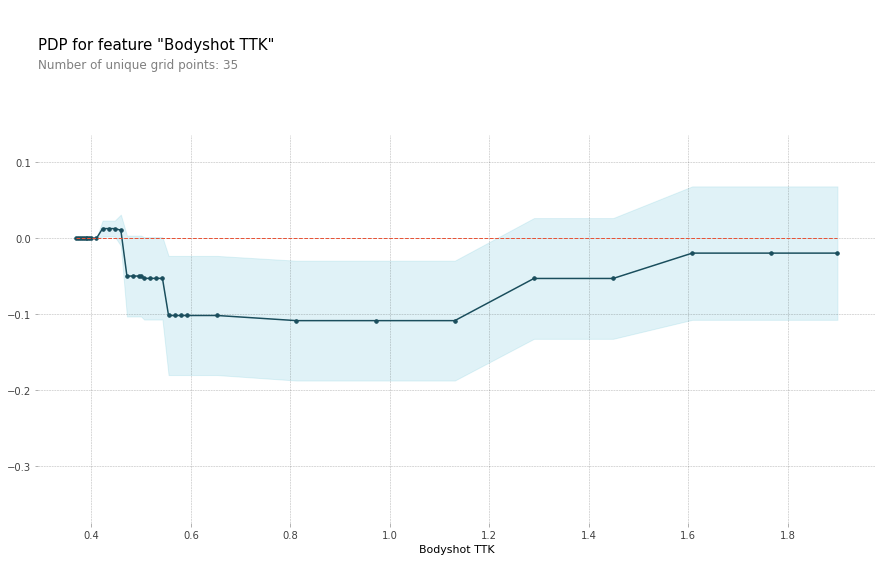

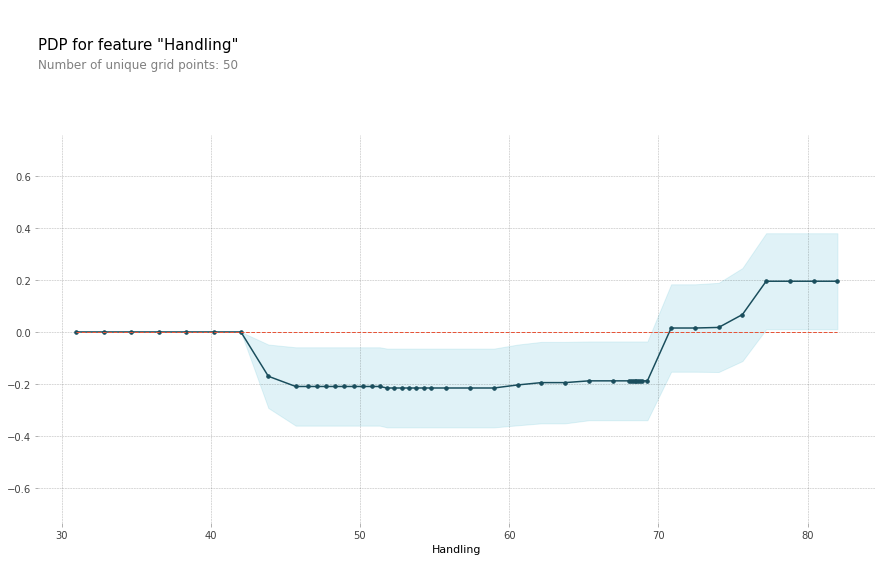

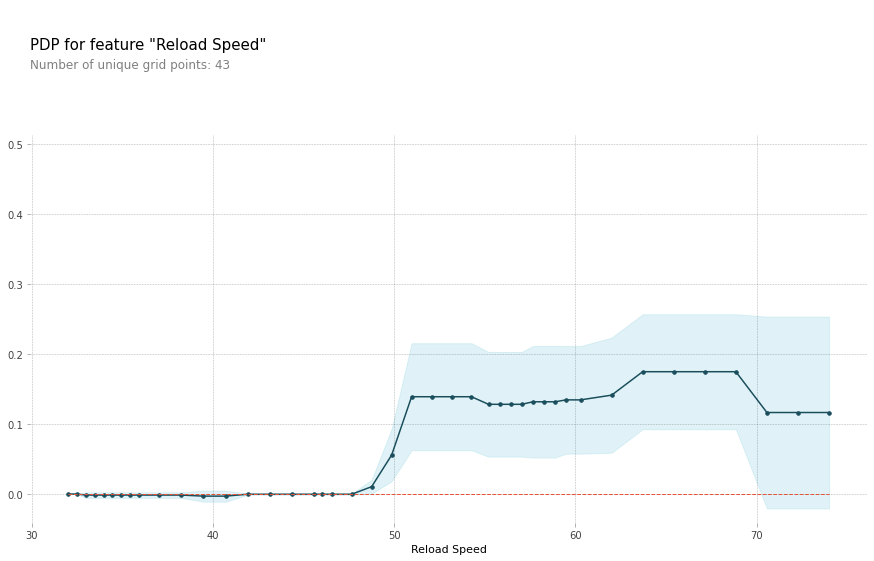

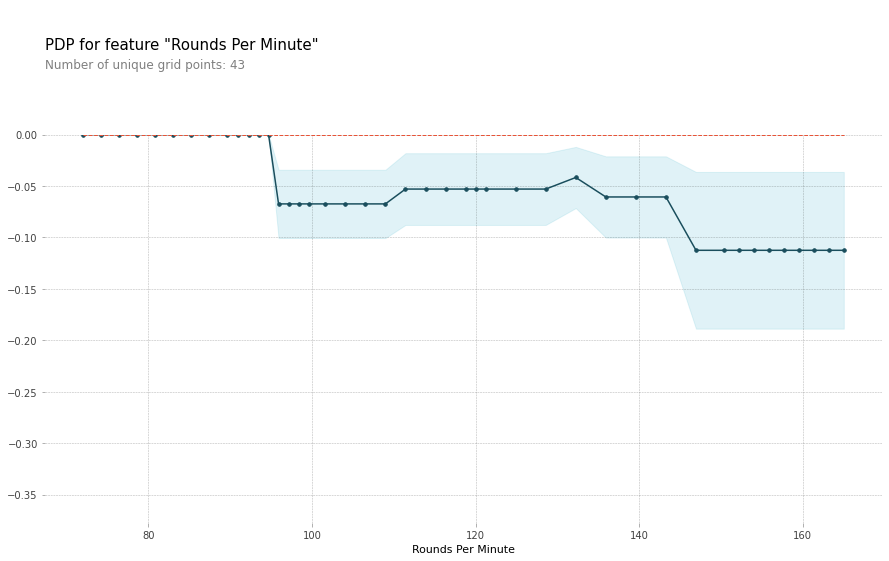

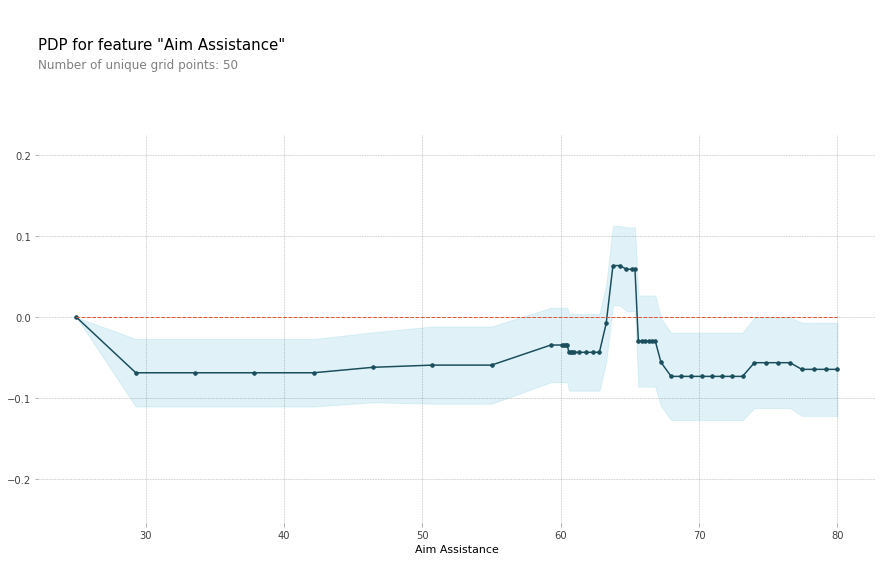

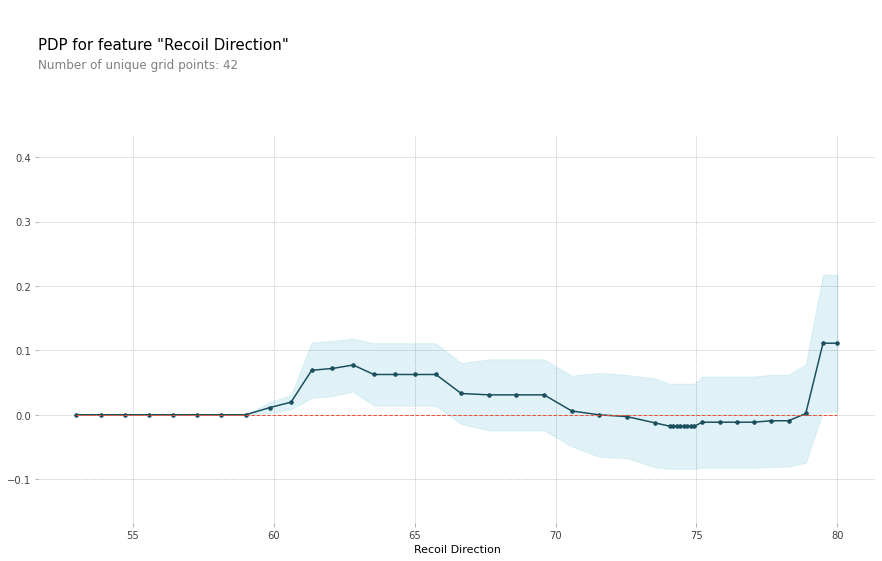

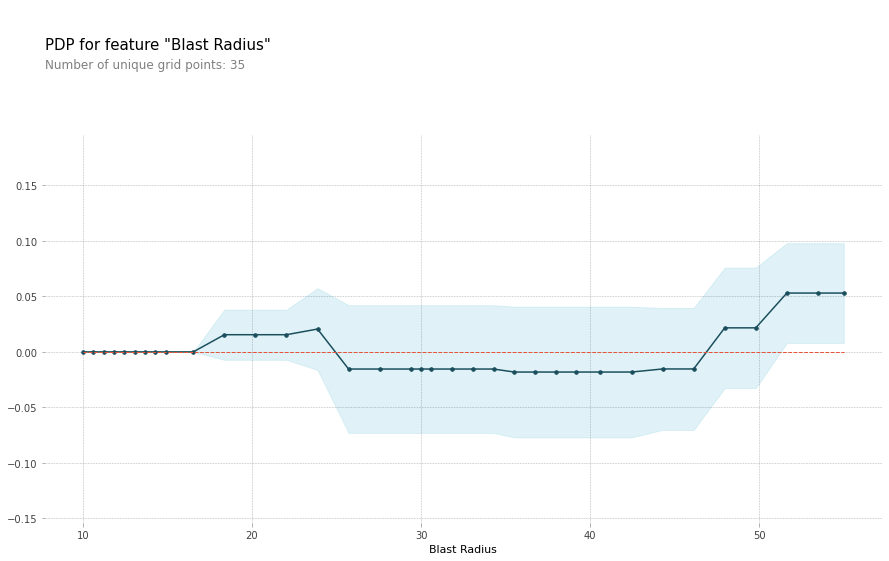

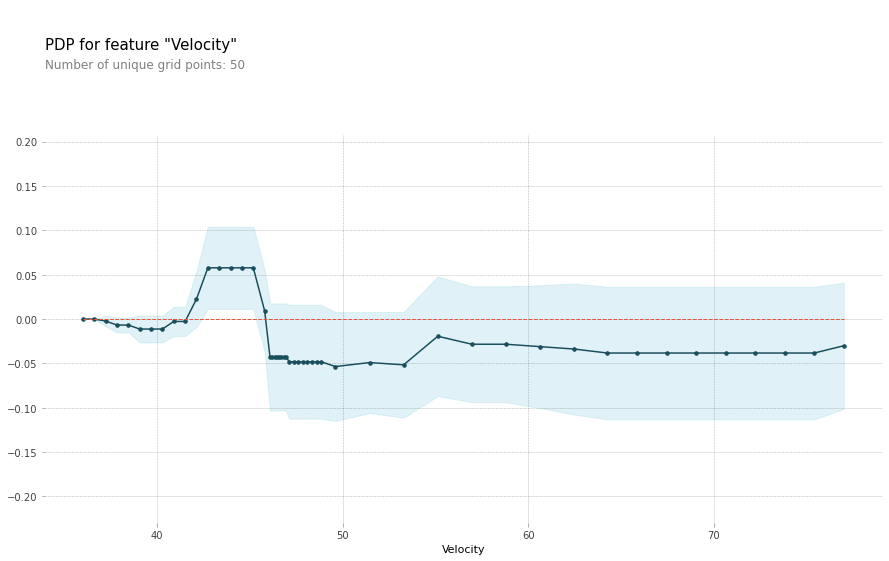

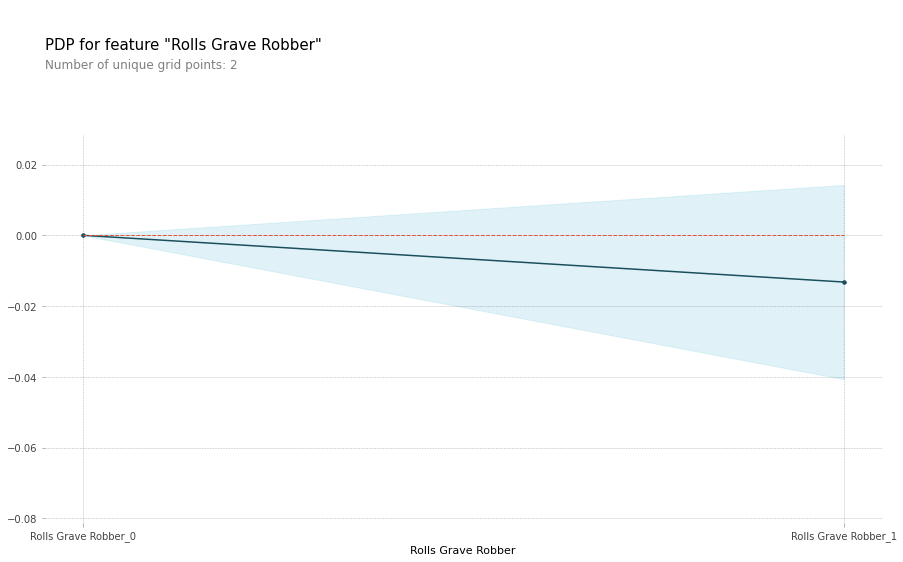

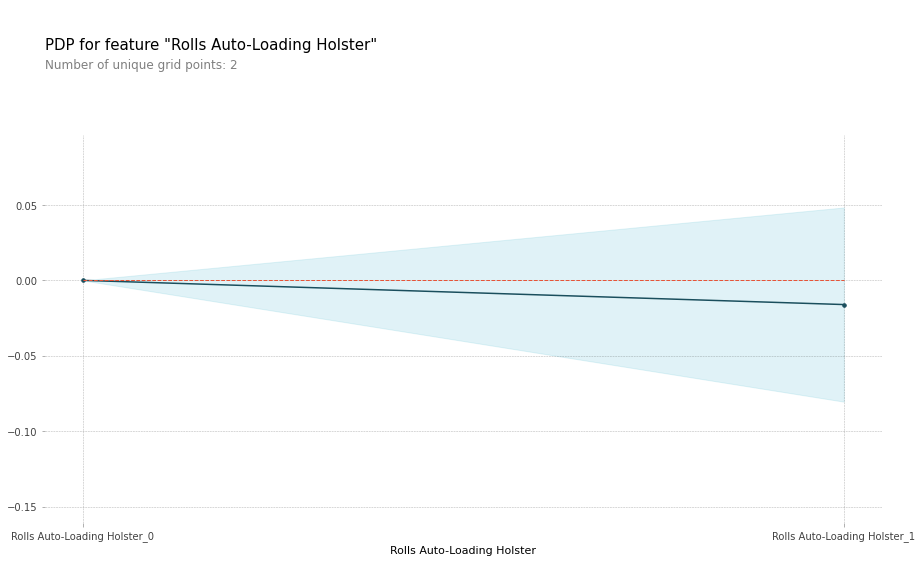

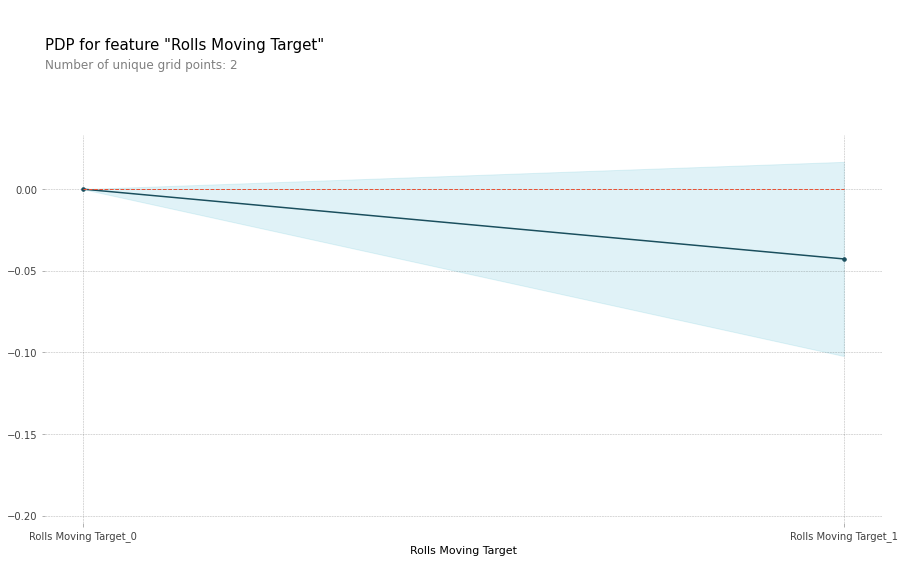

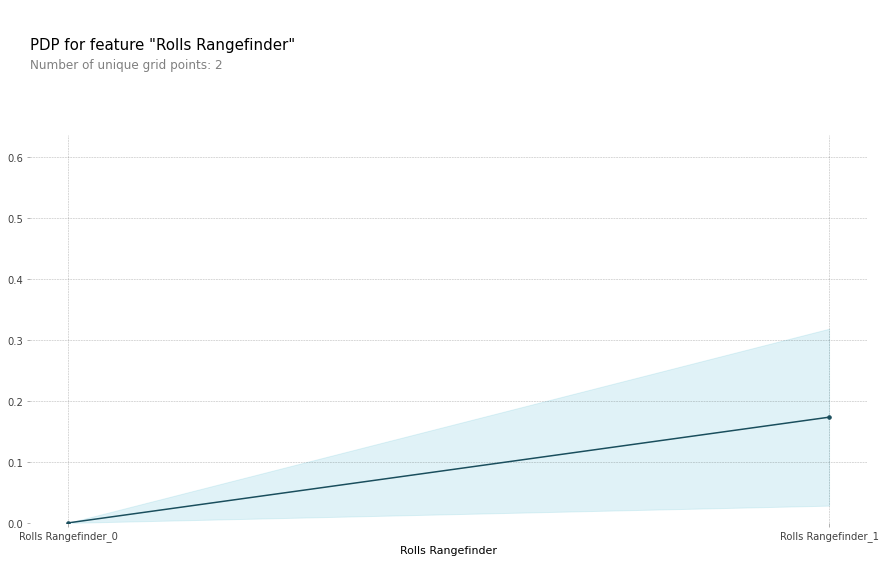

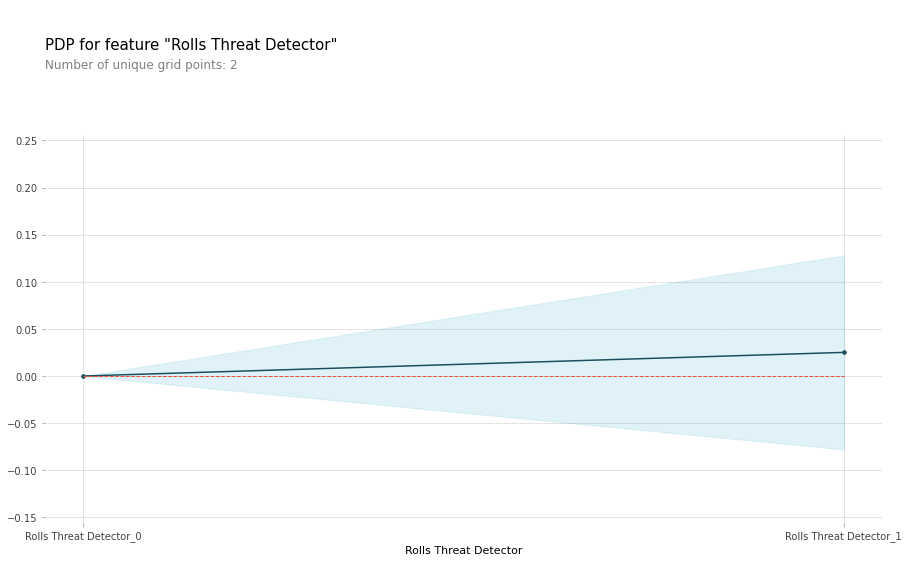

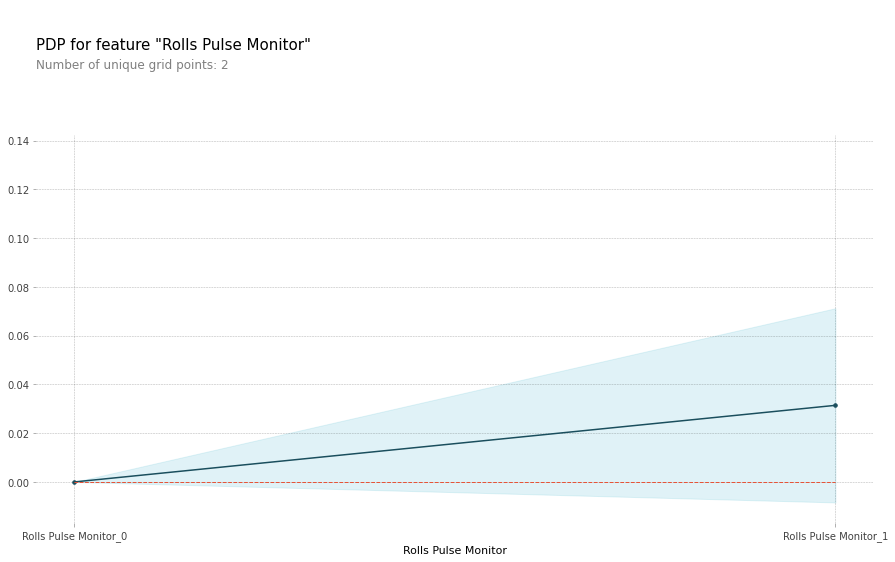

---------------------------------------------------------------------
PDP visualizations for weapon type: Fusion Rifle


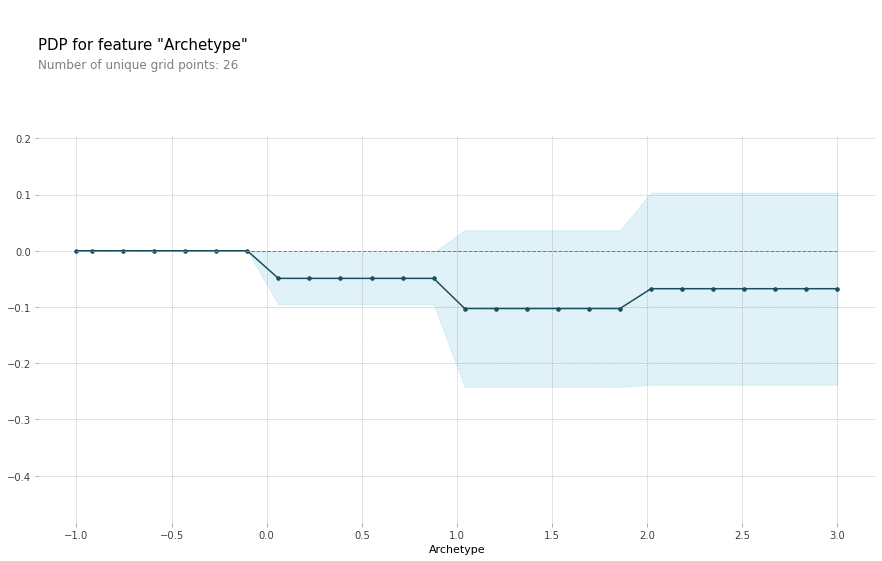

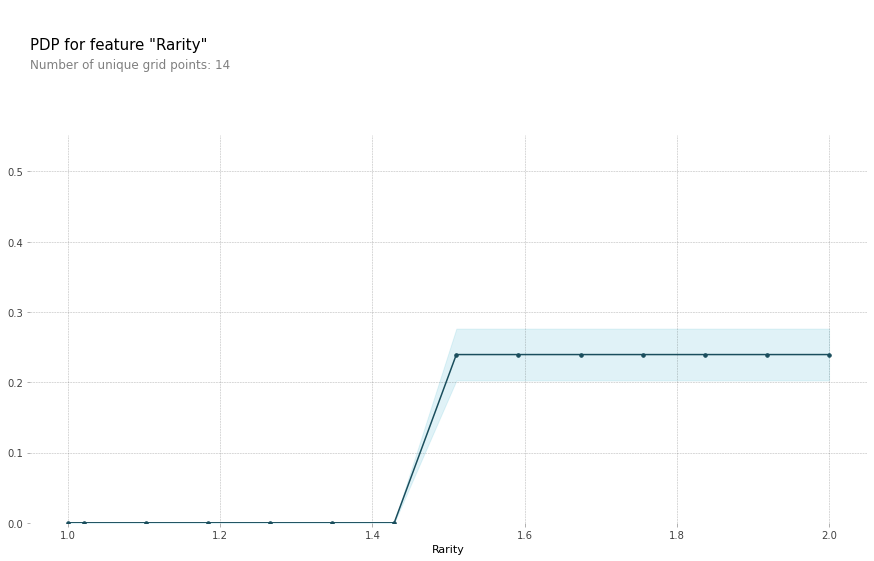

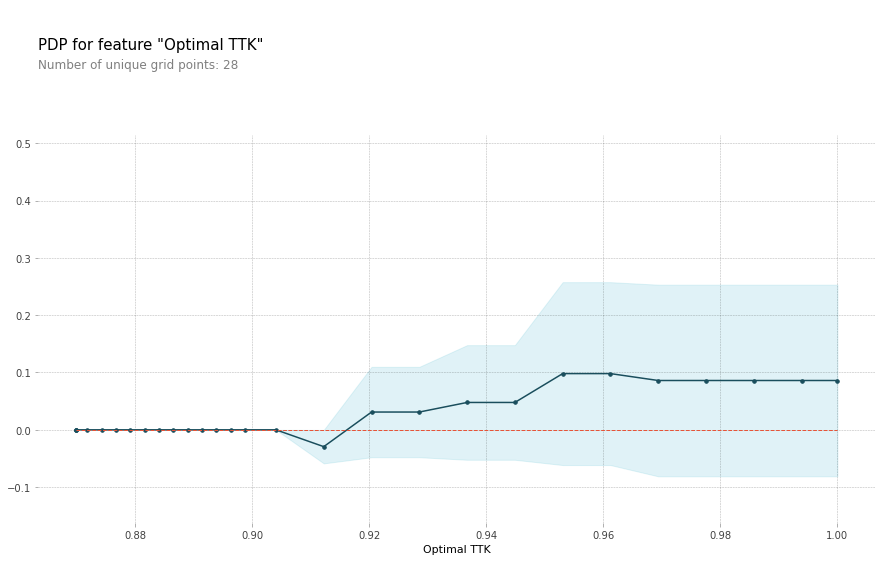

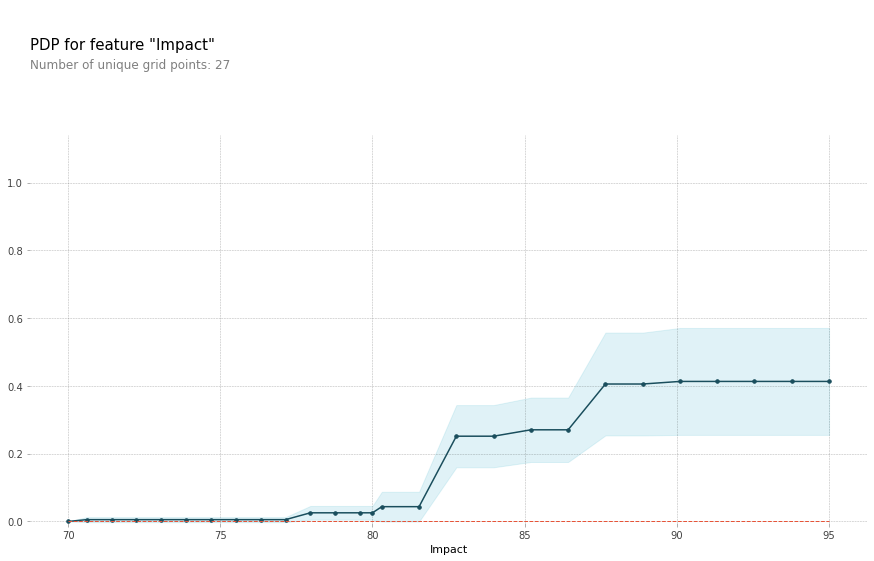

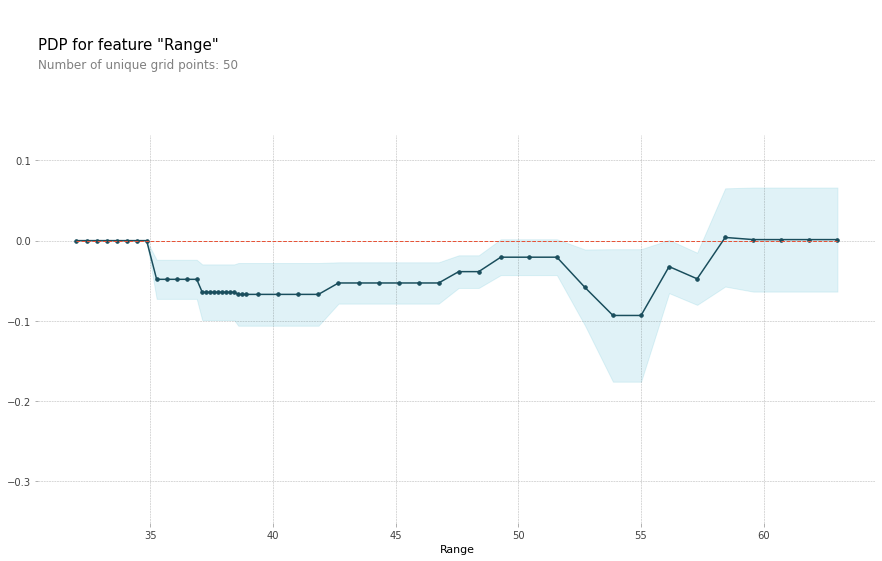

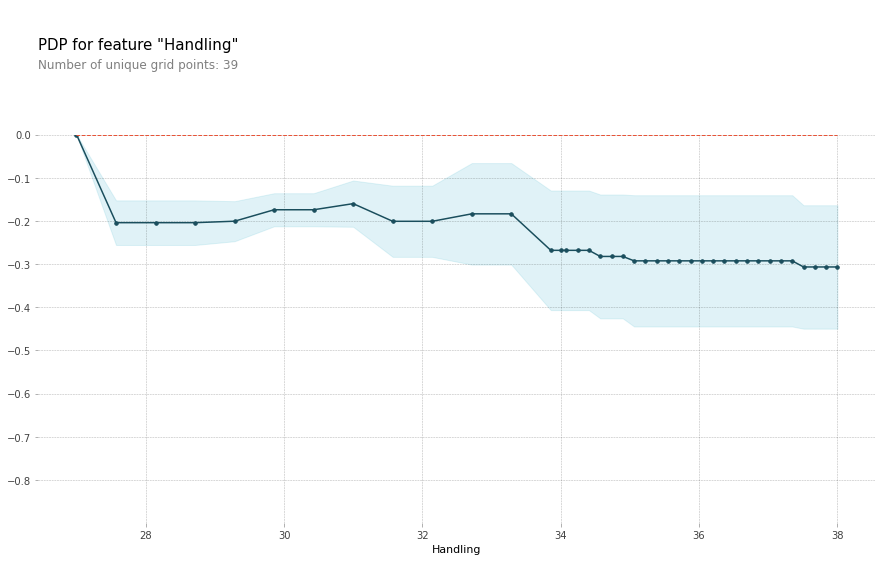

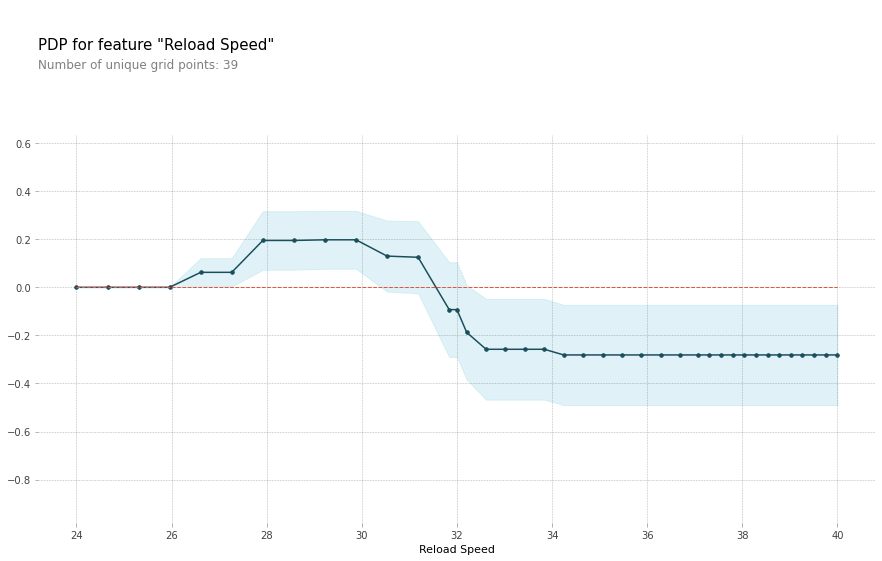

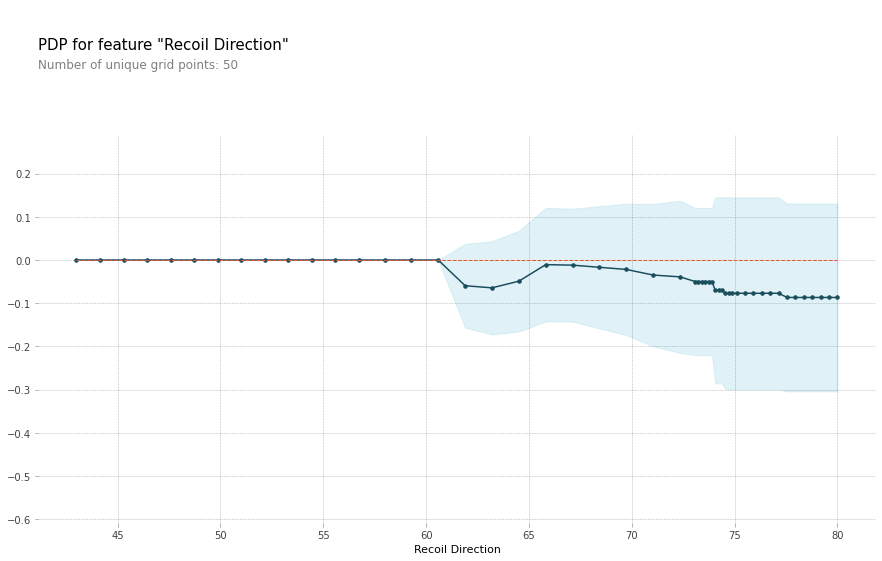

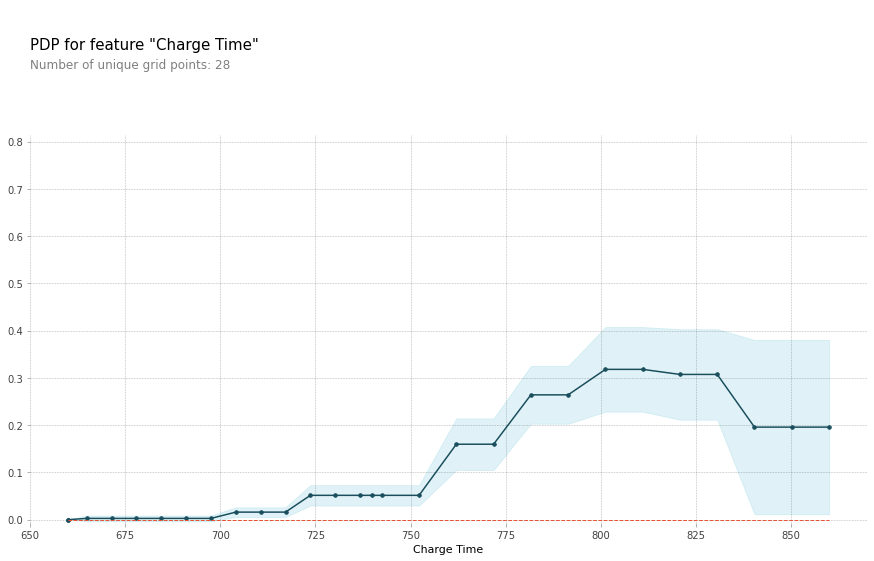

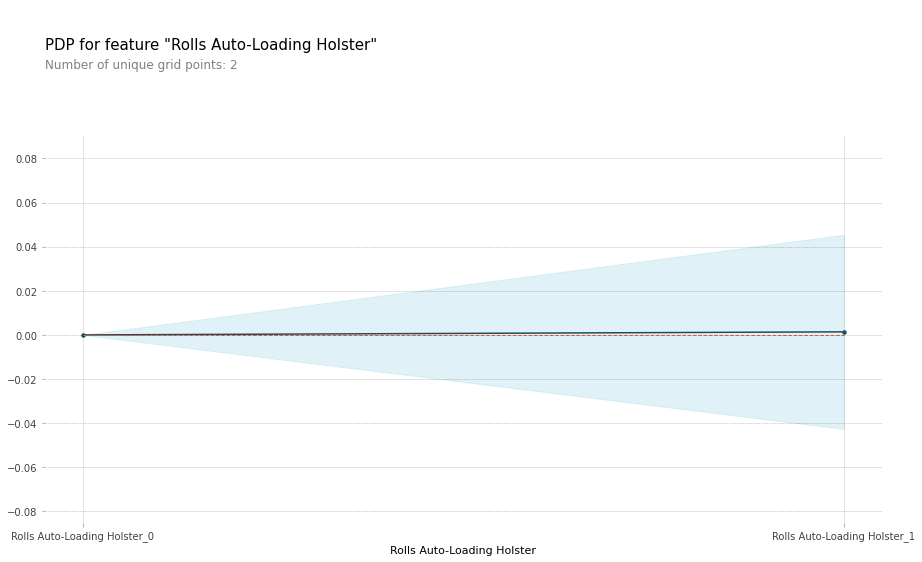

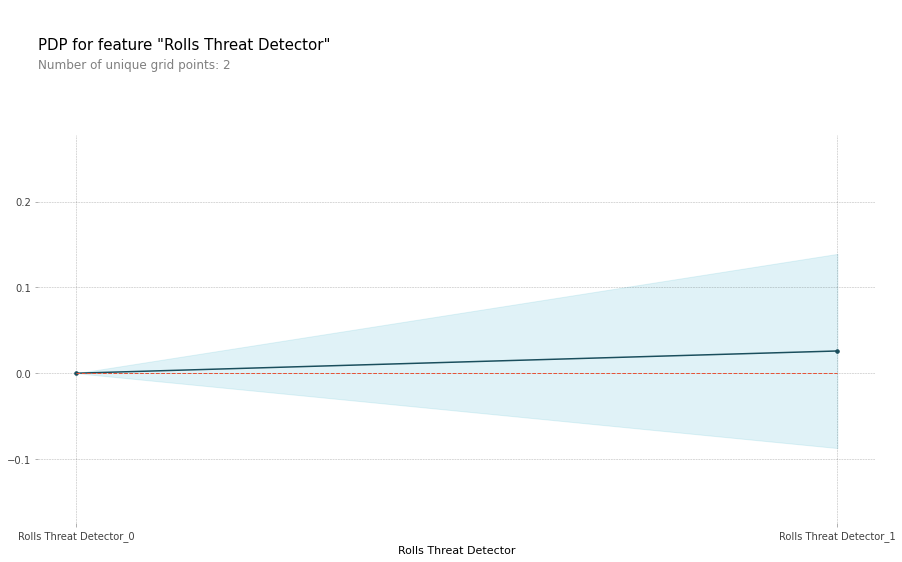

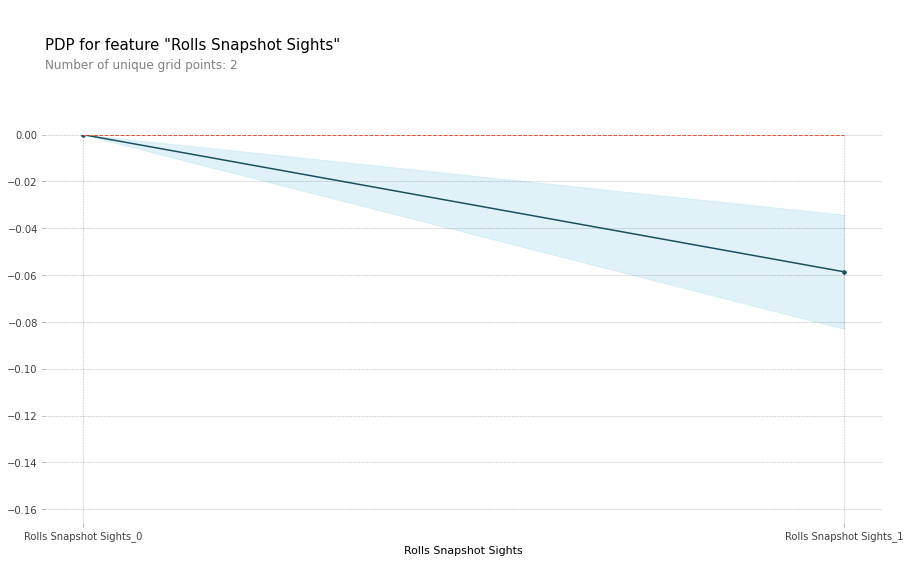

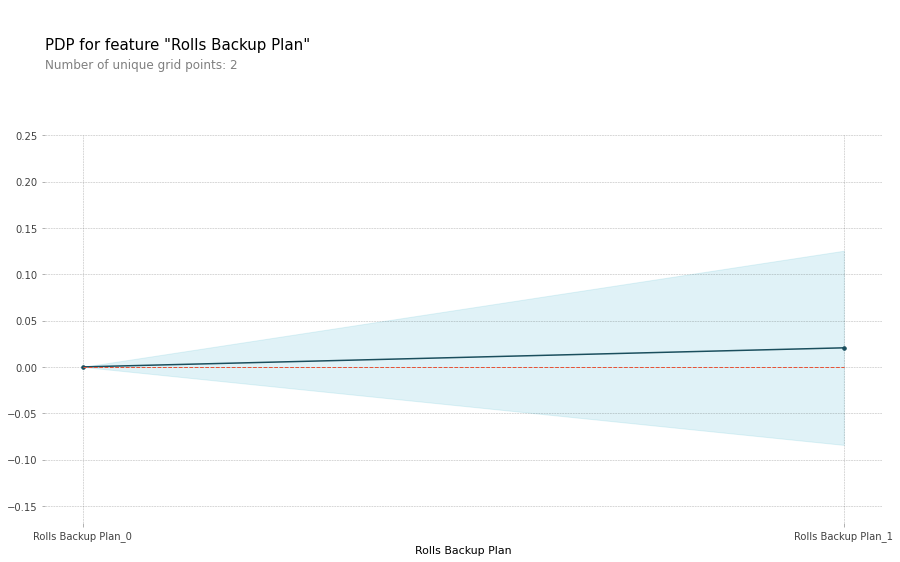

---------------------------------------------------------------------
PDP visualizations for weapon type: Combat Bow


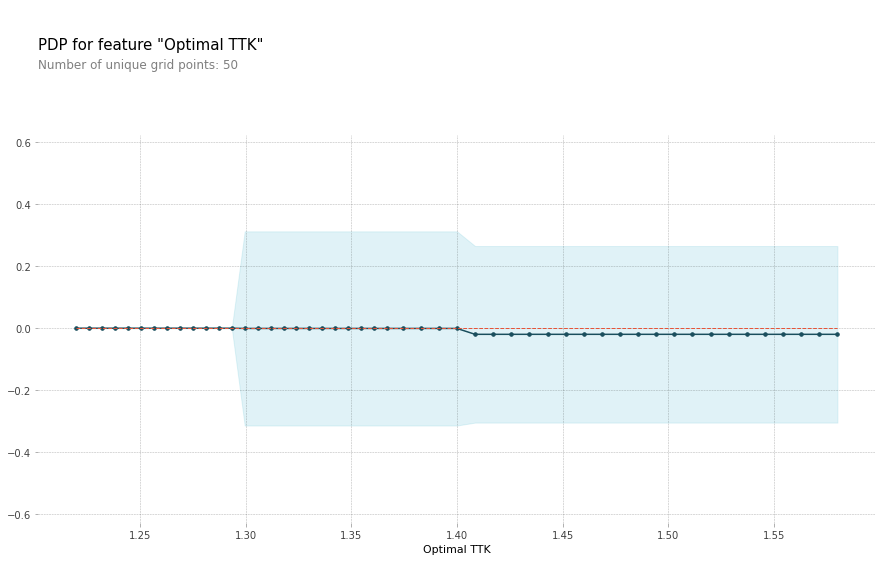

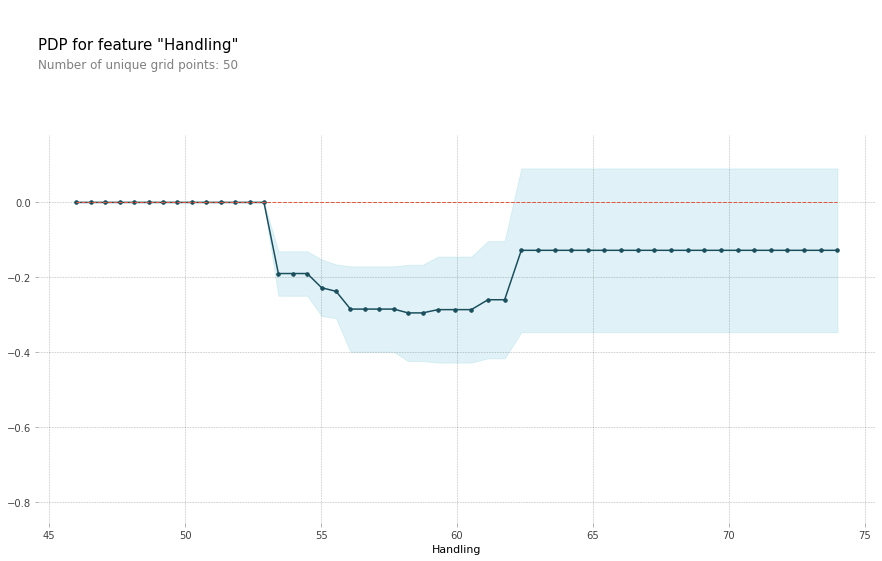

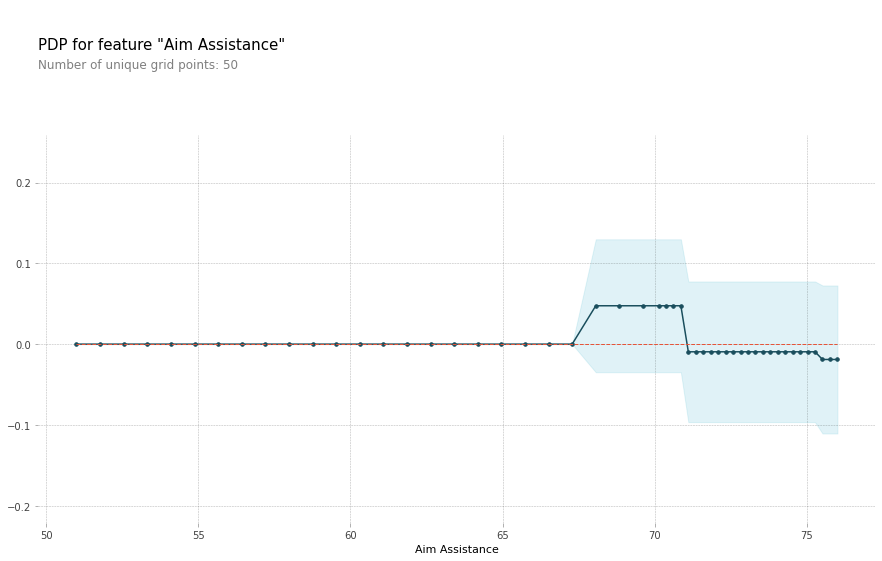

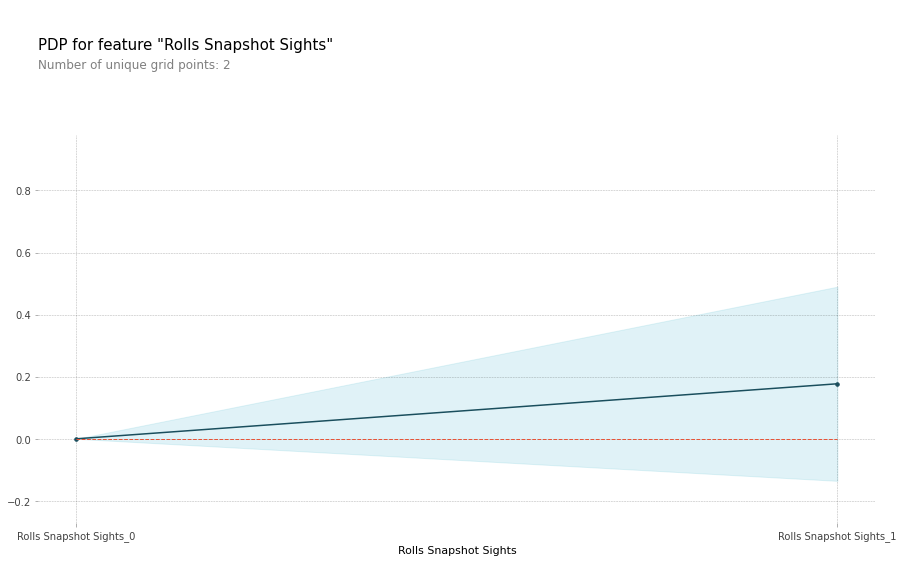

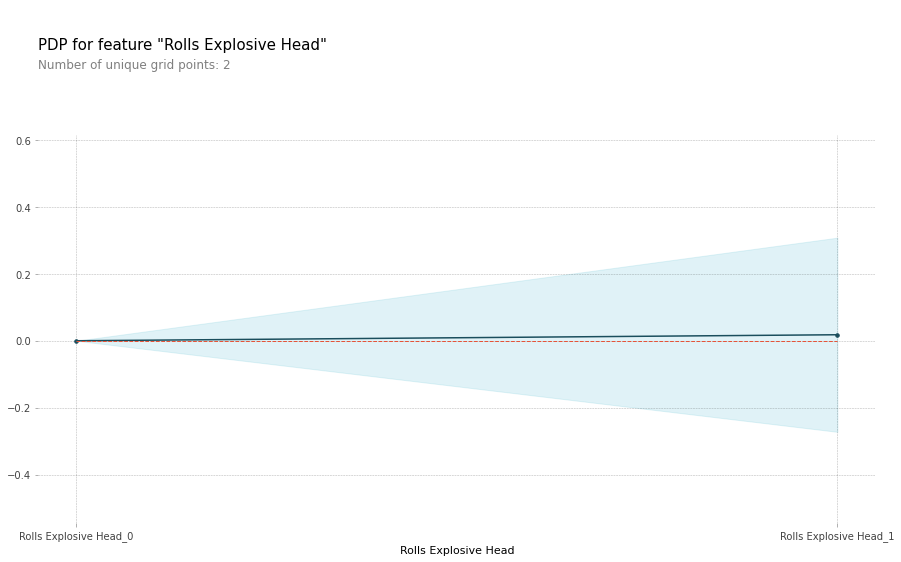

---------------------------------------------------------------------
PDP visualizations for weapon type: Sniper Rifle


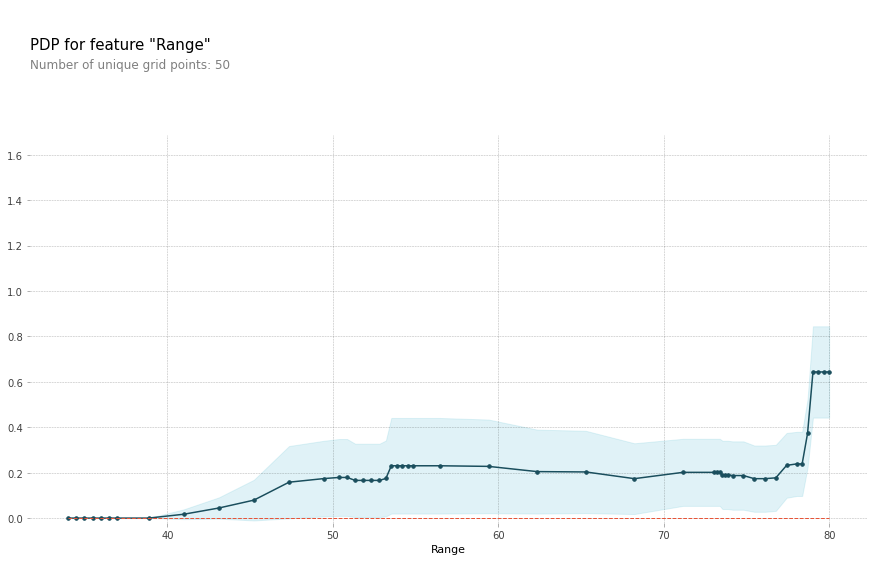

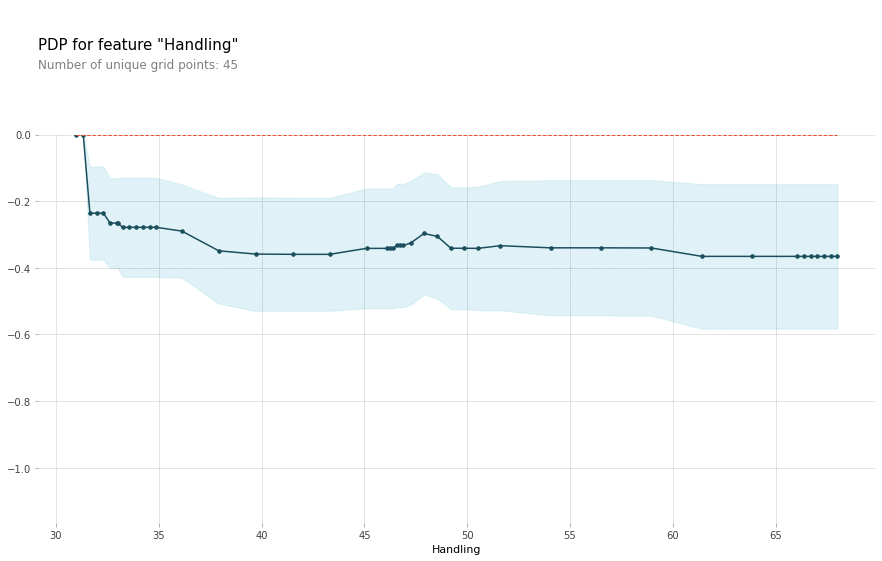

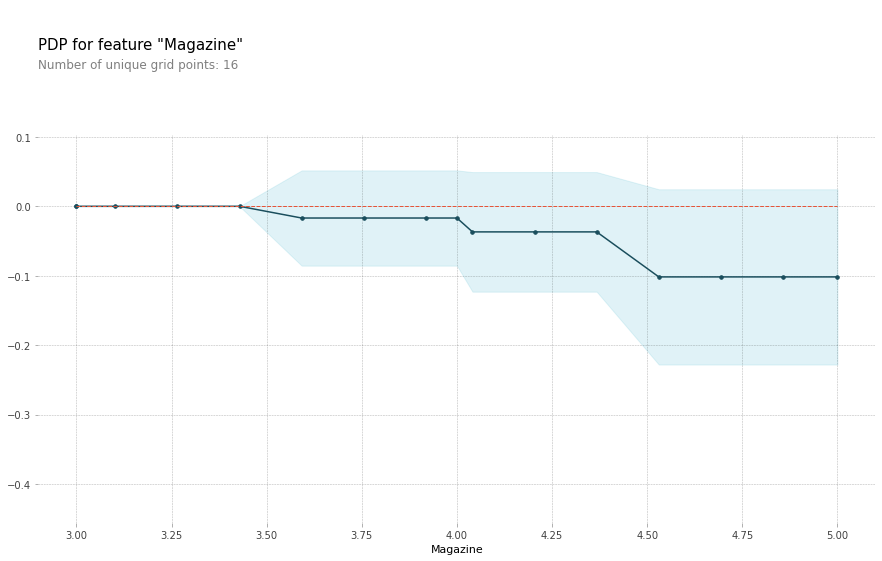

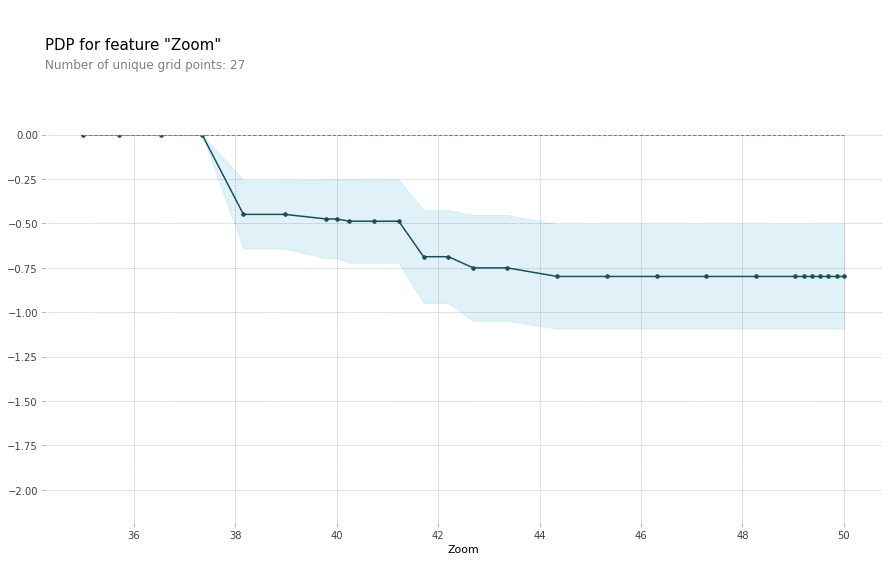

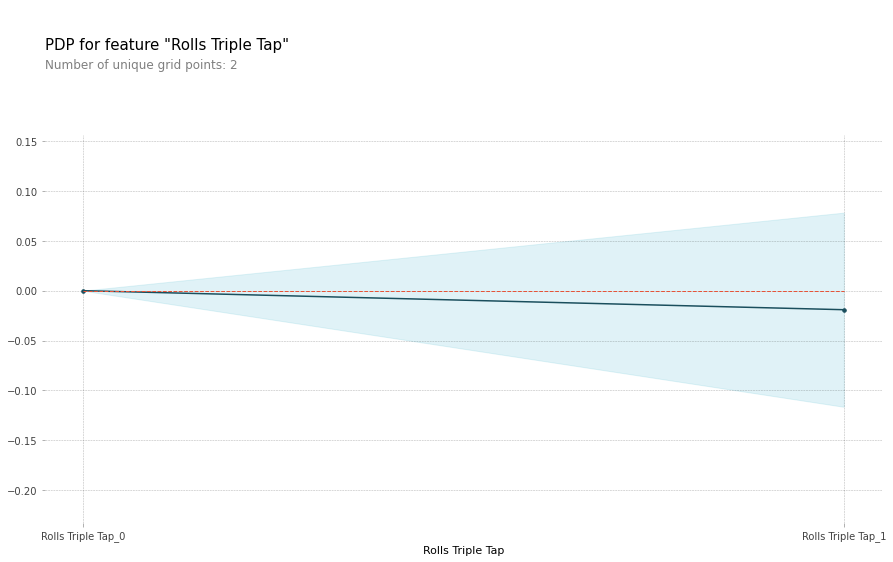

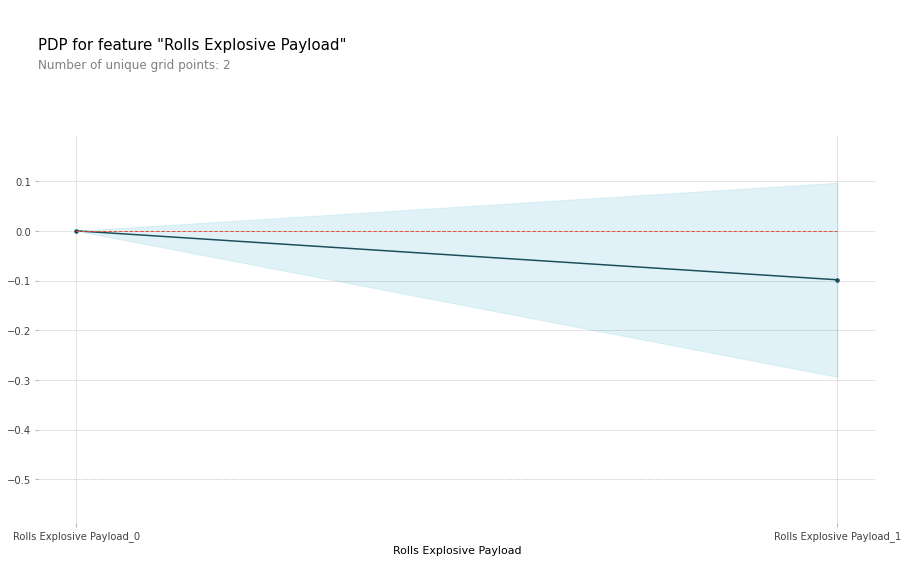

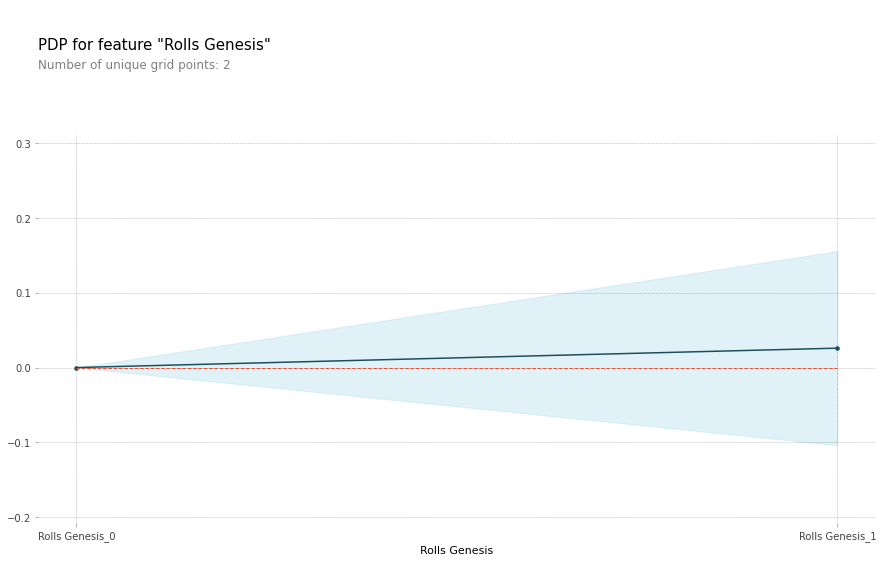

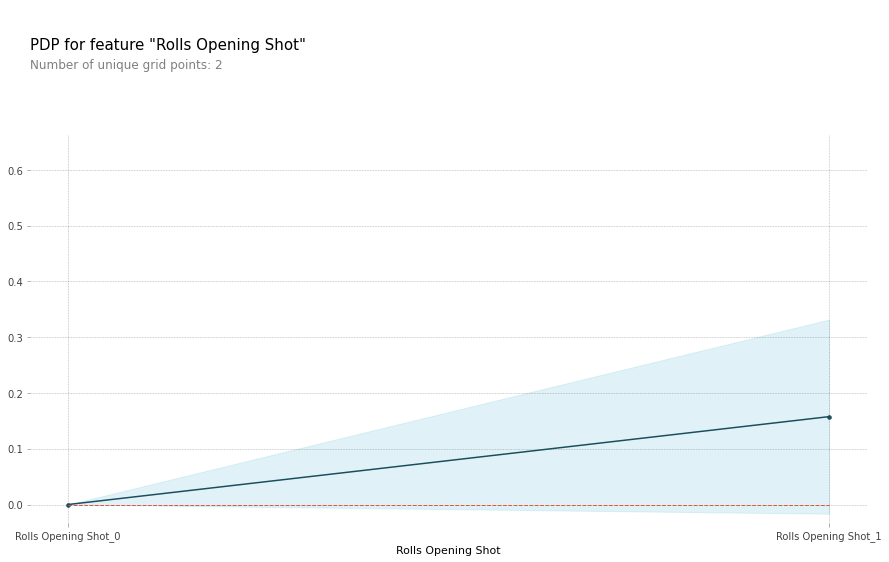

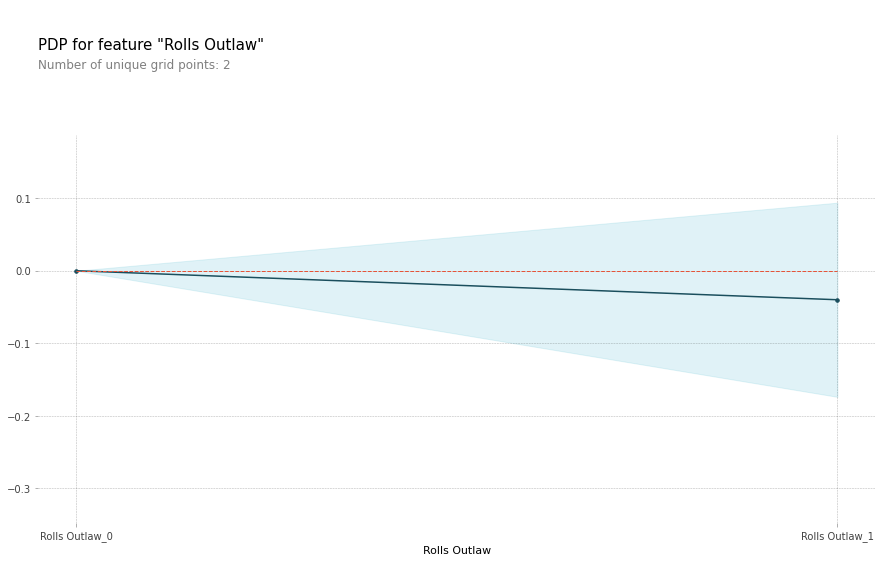

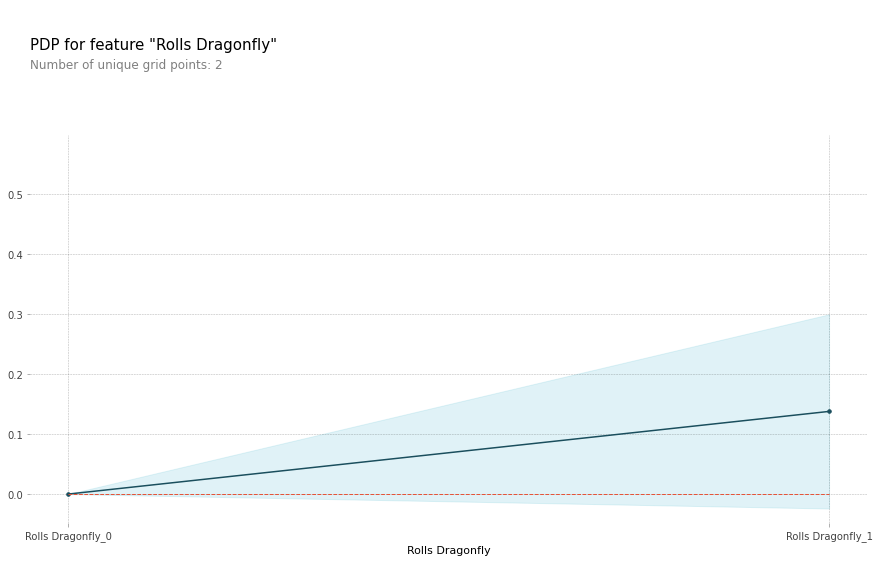

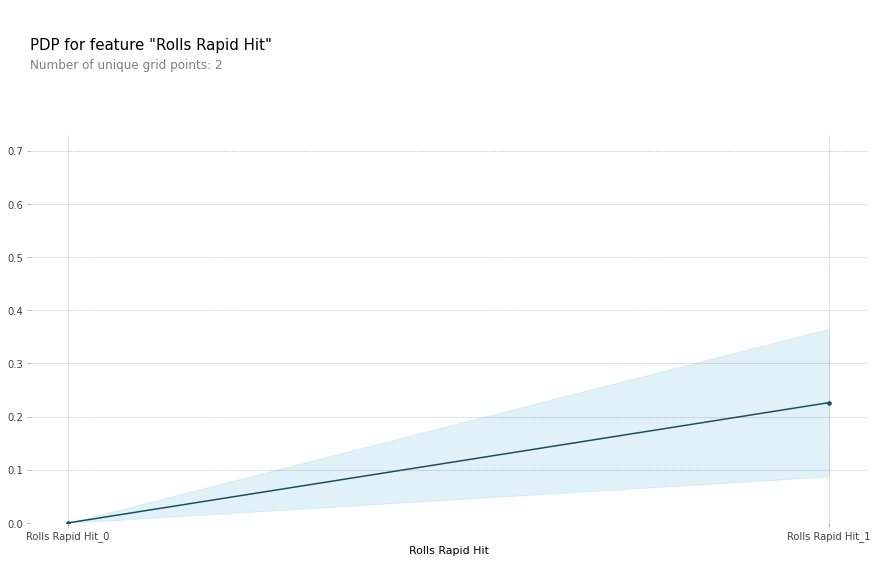

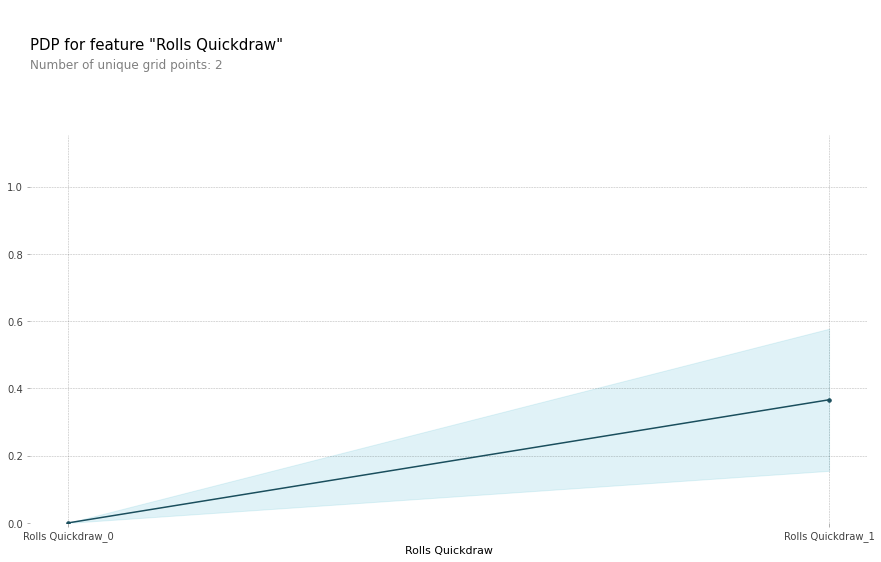

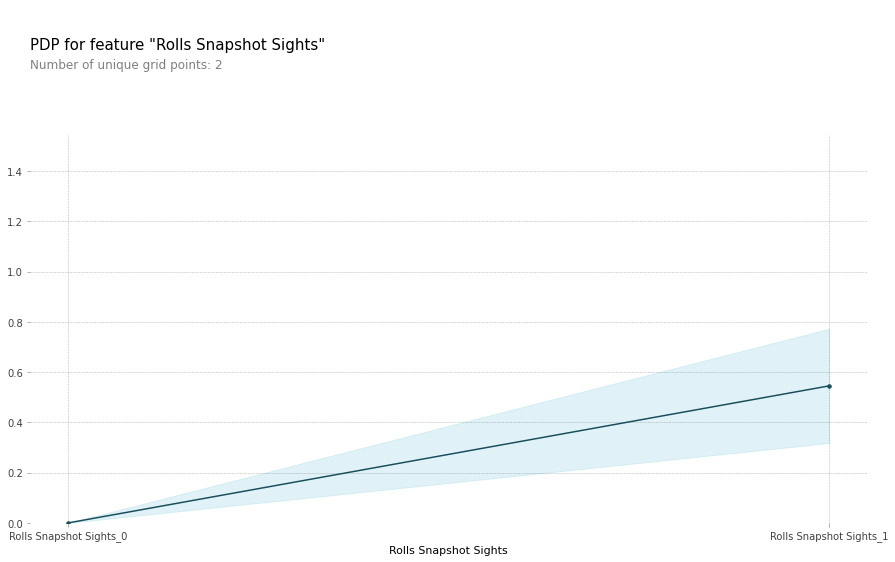

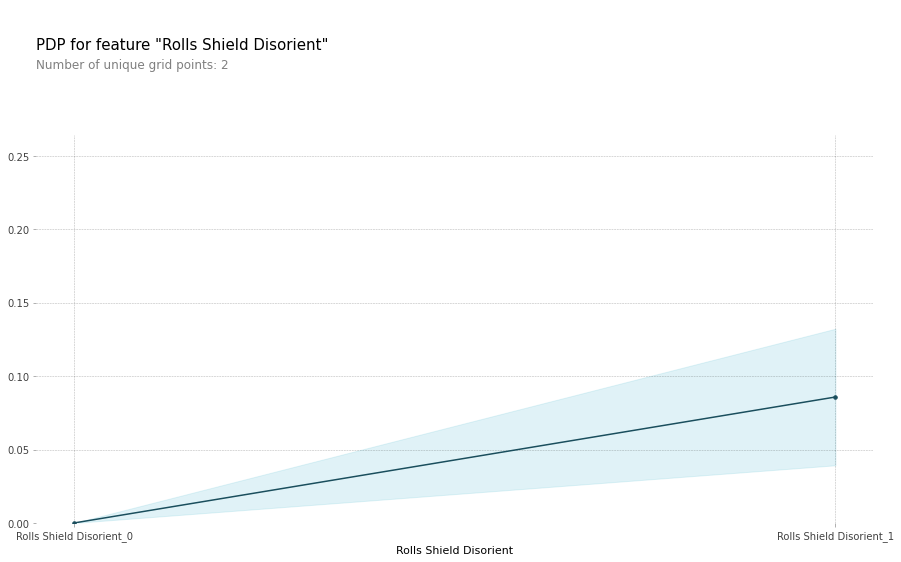

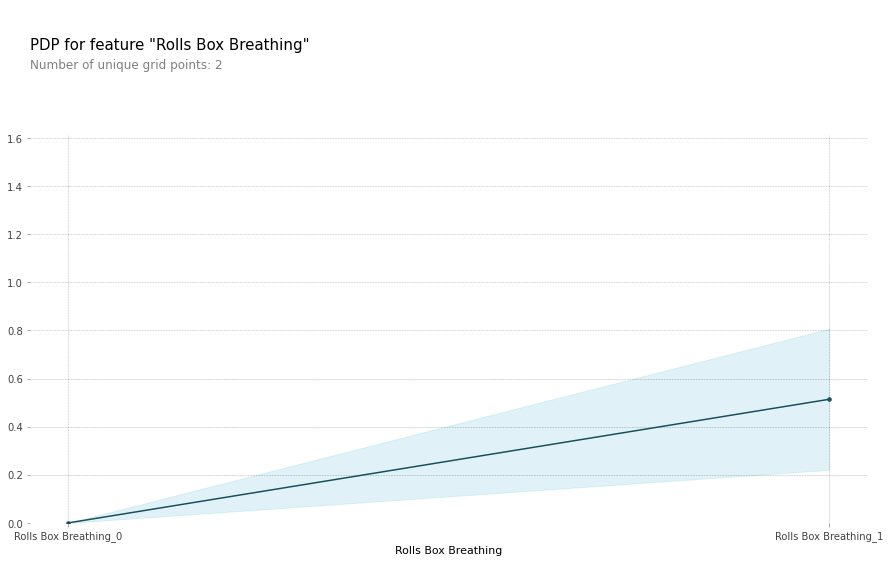

In [19]:
# See the dependance plots for each feature for each weapon
import matplotlib.pyplot as plt
%matplotlib inline
from pdpbox.pdp import pdp_isolate, pdp_plot

plt.rcParams['figure.dpi'] = 72

for wep_type in train_seperated:
  if features[wep_type].empty:  # ignore empty feature lists
    continue
  print('---------------------------------------------------------------------')
  print(f'PDP visualizations for weapon type: {wep_type}')
  for feature in features[wep_type]:
    # do the train val split
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
        X_train_encoded[wep_type], y_train[wep_type], test_size=0.2, random_state=42
    )

    # isolate the feature for pdp
    isolated = pdp_isolate(
        model=best_models[wep_type],
        dataset=X_val_split,
        model_features=features[wep_type],
        num_grid_points=50,
        feature=feature
    )

    pdp_plot(isolated, feature_name=feature)
    plt.show()